In [186]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [187]:
import azureml
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.43


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [188]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: siamese-oneshot
Azure region: eastus2
Subscription id: 2f30e659-5d70-49f7-a8cf-0ba8cabc37f6
Resource group: default-storage-eastus


## Create an Azure ML experiment
Let's create an experiment named "keras-mnist" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [189]:
from azureml.core import Experiment

script_folder = './keras-siamese'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='keras-siamese')

## Extract Fruits dataset
In order to train on the MNIST dataset we will first need to download it from Yan LeCun's web site directly and save them in a `data` folder locally.

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('./data/fruits_data_set_2017_12_27.zip', 'r')
zip_ref.extractall('./data/fruits/')
zip_ref.close()

## Show some sample images
Let's load the downloaded compressed file into numpy arrays using some utility functions included in the `utils.py` library file from the current folder. Then we use `matplotlib` to plot 30 random images from the dataset along with their labels.

In [44]:
#Image file path looks like this - C:\Users\himasing\Documents\DeepLearning\Project\fruits_data_set_2017_12_28\Training\f1\0_100.jpg
# Define root path accordingly, notice last "f1" and "f"
rootTrainingPath = "./data/fruits/Training/f"
rootTestingPath = "./data/fruits/Validation/f"

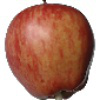

In [45]:
Image.open(rootTrainingPath + "1/2_100.jpg")

In [46]:
# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
img = load_img(rootTrainingPath + "1/0_100.jpg")
img_array = img_to_array(img)
img_array.shape

(100, 100, 3)

In [47]:
size = 2
total_sample_size = 100


def get_data_coloredImages(rootPath, size, total_sample_size, maxImages):
    #read the image
    image_p = load_img(rootPath + "1/2_100.jpg")
    image = img_to_array(image_p)
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    channels = image.shape[2]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, dim1, dim2, channels])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(33):
        for j in range(int(total_sample_size/33)):
            ind1 = 0
            ind2 = 0
            
            dir1 = rootPath + str(i+1)
            images = os.listdir(rootPath + str(i+1))
            no_images = len(images)
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(no_images - 1)
                ind2 = np.random.randint(no_images - 1)
            
            # read the two images
            #img1 = read_image('att_faces\\s' + str(i+1) + '\\' + str(ind1 + 1) + '.pgm', 'rw+')
            #img2 = read_image('att_faces\\s' + str(i+1) + '\\' + str(ind2 + 1) + '.pgm', 'rw+')
            #print(images[ind1])
            image1 = load_img(dir1 + "/" + images[ind1])
            image2 = load_img(dir1 + "/" + images[ind2])
            
            img1 = img_to_array(image1)
            img2 = img_to_array(image2)
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, :, :, :] = img1
            x_geuine_pair[count, 1, :, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, dim1, dim2, channels])
    y_imposite = np.zeros([total_sample_size, 1])
    
    #For any given class, we will take first 400 images only
    for i in range(int(total_sample_size/maxImages)):
        for j in range(maxImages):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(33)
                ind2 = np.random.randint(33)
                if ind1 != ind2:
                    break
                    
            dir1 = rootPath + str(ind1+1)
            dir2 = rootPath + str(ind2+1)
            images1 = os.listdir(dir1)
            images2 = os.listdir(dir2)
            #img1 = read_image('att_faces\\s' + str(ind1+1) + '\\' + str(j + 1) + '.pgm', 'rw+')
            #img2 = read_image('att_faces\\s' + str(ind2+1) + '\\' + str(j + 1) + '.pgm', 'rw+')

            image1 = load_img(dir1 + "/" + images1[j+1])
            image2 = load_img(dir2 + "/" + images2[j+1])
            
            img1 = img_to_array(image1)
            img2 = img_to_array(image2)
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, :, :, :] = img1
            x_imposite_pair[count, 1, :, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [48]:
x_train, y_train = get_data_coloredImages(rootTrainingPath, size, 200, 200)
x_train.shape

(400, 2, 50, 50, 3)

In [140]:
x_test, y_test = get_data_coloredImages(rootTestingPath, size, 50, 50)
x_test.shape

(100, 2, 50, 50, 3)

## Verify that data is loaded correctly and test data is different than train data

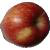

In [41]:
from keras.preprocessing.image import save_img

loadedImage = x_train[0,0,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

In [42]:
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

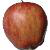

In [145]:
x_test.shape
loadedImage = x_test[0,0,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

## Upload Fruits dataset to default datastore 
A [datastore](https://docs.microsoft.com/azure/machine-learning/service/how-to-access-data) is a place where data can be stored that is then made accessible to a Run either by means of mounting or copying the data to the compute target. A datastore can either be backed by an Azure Blob Storage or and Azure File Share (ADLS will be supported in the future). For simple data handling, each workspace provides a default datastore that can be used, in case the data is not already in Blob Storage or File Share.

In [28]:
ds = ws.get_default_datastore()

In this next step, we will upload the training and test set into the workspace's default datastore, which we will then later be mount on an `AmlCompute` cluster for training.

In [16]:
ds.upload(src_dir='./data/fruits', target_path='fruits', overwrite=True, show_progress=True)

Uploading ./data/fruits/Training/f23/0_100.jpg
Uploading ./data/fruits/Training/f23/100_100.jpg
Uploading ./data/fruits/Training/f23/101_100.jpg
Uploading ./data/fruits/Training/f23/102_100.jpg
Uploading ./data/fruits/Training/f23/103_100.jpg
Uploading ./data/fruits/Training/f23/104_100.jpg
Uploading ./data/fruits/Training/f23/105_100.jpg
Uploading ./data/fruits/Training/f23/106_100.jpg
Uploading ./data/fruits/Training/f23/107_100.jpg
Uploading ./data/fruits/Training/f23/108_100.jpg
Uploading ./data/fruits/Training/f23/109_100.jpg
Uploading ./data/fruits/Training/f23/10_100.jpg
Uploading ./data/fruits/Training/f23/110_100.jpg
Uploading ./data/fruits/Training/f23/111_100.jpg
Uploading ./data/fruits/Training/f23/112_100.jpg
Uploading ./data/fruits/Training/f23/113_100.jpg
Uploading ./data/fruits/Training/f23/114_100.jpg
Uploading ./data/fruits/Training/f23/115_100.jpg
Uploading ./data/fruits/Training/f23/116_100.jpg
Uploading ./data/fruits/Training/f23/117_100.jpg
Uploading ./data/fruits

Uploaded ./data/fruits/Training/f19/141_100.jpg, 71 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/132_100.jpg, 72 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/182_100.jpg
Uploading ./data/fruits/Training/f19/183_100.jpg
Uploaded ./data/fruits/Training/f19/139_100.jpg, 73 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/138_100.jpg, 74 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/186_100.jpg
Uploaded ./data/fruits/Training/f19/147_100.jpg, 75 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/145_100.jpg, 76 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/179_100.jpg, 77 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/134_100.jpg, 78 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/172_100.jpg, 79 files out of an estimated total of 20815
Uploaded ./data/

Uploaded ./data/fruits/Training/f19/236_100.jpg, 140 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/251_100.jpg
Uploaded ./data/fruits/Training/f19/220_100.jpg, 141 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/25_100.jpg
Uploaded ./data/fruits/Training/f19/222_100.jpg, 142 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/26_100.jpg
Uploaded ./data/fruits/Training/f19/230_100.jpg, 143 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/271_100.jpg
Uploaded ./data/fruits/Training/f19/234_100.jpg, 144 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/273_100.jpg
Uploaded ./data/fruits/Training/f19/226_100.jpg, 145 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/219_100.jpg, 146 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/27_100.jpg
Uploaded ./data/fruits/Training/f19/224_100.jpg, 14

Uploaded ./data/fruits/Training/f19/34_100.jpg, 214 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/321_100.jpg, 215 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/64_100.jpg
Uploading ./data/fruits/Training/f19/65_100.jpg
Uploading ./data/fruits/Training/f19/66_100.jpg
Uploading ./data/fruits/Training/f19/67_100.jpg
Uploading ./data/fruits/Training/f19/68_100.jpg
Uploaded ./data/fruits/Training/f19/45_100.jpg, 216 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/69_100.jpg
Uploaded ./data/fruits/Training/f19/39_100.jpg, 217 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/70_100.jpg
Uploaded ./data/fruits/Training/f19/58_100.jpg, 218 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/71_100.jpg
Uploaded ./data/fruits/Training/f19/42_100.jpg, 219 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/72_100.jpg
Uploaded 

Uploaded ./data/fruits/Training/f13/116_100.jpg, 273 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/13_100.jpg
Uploaded ./data/fruits/Training/f13/104_100.jpg, 274 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/140_100.jpg
Uploaded ./data/fruits/Training/f13/114_100.jpg, 275 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/141_100.jpg
Uploading ./data/fruits/Training/f13/142_100.jpg
Uploaded ./data/fruits/Training/f13/115_100.jpg, 276 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/109_100.jpg, 277 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/143_100.jpg
Uploaded ./data/fruits/Training/f13/132_100.jpg, 278 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/120_100.jpg, 279 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/133_100.jpg, 280 files out of an estimated total of 20815
Uplo

Uploading ./data/fruits/Training/f13/20_100.jpg
Uploaded ./data/fruits/Training/f13/178_100.jpg, 355 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/201_100.jpg, 356 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/210_100.jpg
Uploaded ./data/fruits/Training/f13/194_100.jpg, 357 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/211_100.jpg
Uploaded ./data/fruits/Training/f13/189_100.jpg, 358 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/1_100.jpg, 359 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/204_100.jpg, 360 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/195_100.jpg, 361 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/212_100.jpg
Uploading ./data/fruits/Training/f13/213_100.jpg
Uploading ./data/fruits/Training/f13/214_100.jpg
Uploading ./data/fruits/Training/f13/215_100.jpg
Up

Uploaded ./data/fruits/Training/f13/252_100.jpg, 417 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/274_100.jpg
Uploaded ./data/fruits/Training/f13/236_100.jpg, 418 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/250_100.jpg, 419 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/275_100.jpg
Uploaded ./data/fruits/Training/f13/242_100.jpg, 420 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/260_100.jpg, 421 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/276_100.jpg
Uploading ./data/fruits/Training/f13/277_100.jpg
Uploaded ./data/fruits/Training/f13/246_100.jpg, 422 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/278_100.jpg
Uploading ./data/fruits/Training/f13/279_100.jpg
Uploading ./data/fruits/Training/f11/175_100.jpg
Uploaded ./data/fruits/Training/f13/251_100.jpg, 423 files out of an estimated total of 20815

Uploaded ./data/fruits/Training/f11/137_100.jpg, 491 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/161_100.jpg
Uploaded ./data/fruits/Training/f11/127_100.jpg, 492 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/162_100.jpg
Uploaded ./data/fruits/Training/f11/135_100.jpg, 493 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/163_100.jpg
Uploaded ./data/fruits/Training/f11/134_100.jpg, 494 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/164_100.jpg
Uploaded ./data/fruits/Training/f11/139_100.jpg, 495 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/165_100.jpg
Uploaded ./data/fruits/Training/f11/142_100.jpg, 496 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/166_100.jpg
Uploaded ./data/fruits/Training/f11/138_100.jpg, 497 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/167_100.jpg

Uploaded ./data/fruits/Training/f11/215_100.jpg, 584 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/233_100.jpg
Uploading ./data/fruits/Training/f11/234_100.jpg
Uploading ./data/fruits/Training/f11/235_100.jpg
Uploading ./data/fruits/Training/f11/236_100.jpg
Uploading ./data/fruits/Training/f11/237_100.jpg
Uploading ./data/fruits/Training/f11/238_100.jpg
Uploaded ./data/fruits/Training/f11/222_100.jpg, 585 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/21_100.jpg, 586 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/225_100.jpg, 587 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/212_100.jpg, 588 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/210_100.jpg, 589 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/239_100.jpg
Uploading ./data/fruits/Training/f11/23_100.jpg
Uploading ./data/fruits/Training/f11/240_100.j

Uploaded ./data/fruits/Training/f11/289_100.jpg, 648 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/278_100.jpg, 649 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/279_100.jpg, 650 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/271_100.jpg, 651 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/267_100.jpg, 652 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/274_100.jpg, 653 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/273_100.jpg, 654 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/285_100.jpg, 655 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/297_100.jpg
Uploaded ./data/fruits/Training/f11/286_100.jpg, 656 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/288_100.jpg, 657 files out of an estimated total of 20815
Uploaded ./

Uploaded ./data/fruits/Training/f11/31_100.jpg, 703 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_131_100.jpg
Uploaded ./data/fruits/Training/f11/r_112_100.jpg, 704 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_132_100.jpg
Uploaded ./data/fruits/Training/f11/r_113_100.jpg, 705 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_133_100.jpg
Uploaded ./data/fruits/Training/f11/r_106_100.jpg, 706 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_134_100.jpg
Uploaded ./data/fruits/Training/f11/r_108_100.jpg, 707 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_135_100.jpg
Uploaded ./data/fruits/Training/f11/r_116_100.jpg, 708 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_136_100.jpg
Uploaded ./data/fruits/Training/f11/r_100_100.jpg, 709 files out of an estimated total of 20815
Uploading ./data/fruits/T

Uploaded ./data/fruits/Training/f11/r_157_100.jpg, 770 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_192_100.jpg
Uploaded ./data/fruits/Training/f11/r_167_100.jpg, 771 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_193_100.jpg
Uploaded ./data/fruits/Training/f11/r_161_100.jpg, 772 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_194_100.jpg
Uploaded ./data/fruits/Training/f11/r_16_100.jpg, 773 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_195_100.jpg
Uploaded ./data/fruits/Training/f11/r_170_100.jpg, 774 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_196_100.jpg
Uploaded ./data/fruits/Training/f11/r_165_100.jpg, 775 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_197_100.jpg
Uploaded ./data/fruits/Training/f11/r_171_100.jpg, 776 files out of an estimated total of 20815
Uploading ./data/fruits

Uploading ./data/fruits/Training/f11/r_249_100.jpg
Uploading ./data/fruits/Training/f11/r_24_100.jpg
Uploading ./data/fruits/Training/f11/r_250_100.jpg
Uploaded ./data/fruits/Training/f11/r_232_100.jpg, 843 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/r_228_100.jpg, 844 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f11/r_235_100.jpg, 845 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_251_100.jpg
Uploading ./data/fruits/Training/f11/r_252_100.jpg
Uploading ./data/fruits/Training/f11/r_253_100.jpg
Uploading ./data/fruits/Training/f11/r_254_100.jpg
Uploading ./data/fruits/Training/f11/r_255_100.jpg
Uploading ./data/fruits/Training/f11/r_256_100.jpg
Uploading ./data/fruits/Training/f11/r_257_100.jpg
Uploading ./data/fruits/Training/f11/r_258_100.jpg
Uploading ./data/fruits/Training/f11/r_259_100.jpg
Uploading ./data/fruits/Training/f11/r_25_100.jpg
Uploaded ./data/fruits/Training/f11/r_237_100.jpg, 

Uploaded ./data/fruits/Training/f11/r_284_100.jpg, 912 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_31_100.jpg
Uploaded ./data/fruits/Training/f11/r_293_100.jpg, 913 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f11/r_320_100.jpg
Uploaded ./data/fruits/Training/f11/r_277_100.jpg, 914 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/27_100.jpg
Uploaded ./data/fruits/Training/f11/r_290_100.jpg, 915 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/280_100.jpg
Uploaded ./data/fruits/Training/f11/r_300_100.jpg, 916 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/281_100.jpg
Uploaded ./data/fruits/Training/f11/r_29_100.jpg, 917 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/282_100.jpg
Uploaded ./data/fruits/Training/f11/r_301_100.jpg, 918 files out of an estimated total of 20815
Uploading ./data/fruits/Training/

Uploaded ./data/fruits/Training/f13/2_100.jpg, 977 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_114_100.jpg
Uploaded ./data/fruits/Training/f13/30_100.jpg, 978 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_115_100.jpg
Uploaded ./data/fruits/Training/f13/320_100.jpg, 979 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_116_100.jpg
Uploaded ./data/fruits/Training/f13/310_100.jpg, 980 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_117_100.jpg
Uploaded ./data/fruits/Training/f13/313_100.jpg, 981 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_118_100.jpg
Uploaded ./data/fruits/Training/f13/318_100.jpg, 982 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_119_100.jpg
Uploaded ./data/fruits/Training/f13/312_100.jpg, 983 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_

Uploaded ./data/fruits/Training/f12/103_100.jpg, 1036 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/105_100.jpg, 1037 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/126_100.jpg
Uploaded ./data/fruits/Training/f12/104_100.jpg, 1038 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/r_124_100.jpg, 1039 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/127_100.jpg
Uploaded ./data/fruits/Training/f12/106_100.jpg, 1040 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/100_100.jpg, 1041 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/114_100.jpg, 1042 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/128_100.jpg
Uploading ./data/fruits/Training/f12/129_100.jpg
Uploading ./data/fruits/Training/f12/12_100.jpg
Uploading ./data/fruits/Training/f12/130_100.jpg
Uploaded ./data/fruits/Training/f12/108_

Uploaded ./data/fruits/Training/f12/149_100.jpg, 1094 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/180_100.jpg
Uploaded ./data/fruits/Training/f12/154_100.jpg, 1095 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/181_100.jpg
Uploaded ./data/fruits/Training/f12/150_100.jpg, 1096 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/164_100.jpg, 1097 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/152_100.jpg, 1098 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/167_100.jpg, 1099 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/147_100.jpg, 1100 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/159_100.jpg, 1101 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/158_100.jpg, 1102 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/0_100.jpg


Uploaded ./data/fruits/Training/f10/132_100.jpg, 1156 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/182_100.jpg
Uploaded ./data/fruits/Training/f10/129_100.jpg, 1157 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/183_100.jpg
Uploaded ./data/fruits/Training/f10/133_100.jpg, 1158 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/184_100.jpg
Uploaded ./data/fruits/Training/f10/126_100.jpg, 1159 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/185_100.jpg
Uploaded ./data/fruits/Training/f10/135_100.jpg, 1160 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/186_100.jpg
Uploaded ./data/fruits/Training/f10/12_100.jpg, 1161 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/187_100.jpg
Uploaded ./data/fruits/Training/f10/138_100.jpg, 1162 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/188_1

Uploading ./data/fruits/Training/f10/26_100.jpg
Uploaded ./data/fruits/Training/f10/248_100.jpg, 1233 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f10/258_100.jpg, 1234 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/270_100.jpg
Uploading ./data/fruits/Training/f10/271_100.jpg
Uploading ./data/fruits/Training/f10/272_100.jpg
Uploaded ./data/fruits/Training/f10/259_100.jpg, 1235 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/273_100.jpg
Uploading ./data/fruits/Training/f10/274_100.jpg
Uploading ./data/fruits/Training/f10/275_100.jpg
Uploading ./data/fruits/Training/f10/276_100.jpg
Uploading ./data/fruits/Training/f10/277_100.jpg
Uploading ./data/fruits/Training/f10/278_100.jpg
Uploading ./data/fruits/Training/f10/279_100.jpg
Uploading ./data/fruits/Training/f10/27_100.jpg
Uploading ./data/fruits/Training/f10/280_100.jpg
Uploaded ./data/fruits/Training/f10/257_100.jpg, 1236 files out of an estimated 

Uploaded ./data/fruits/Training/f10/307_100.jpg, 1288 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/37_100.jpg
Uploaded ./data/fruits/Training/f10/302_100.jpg, 1289 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/38_100.jpg
Uploaded ./data/fruits/Training/f10/304_100.jpg, 1290 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/39_100.jpg
Uploaded ./data/fruits/Training/f10/300_100.jpg, 1291 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/3_100.jpg
Uploaded ./data/fruits/Training/f10/299_100.jpg, 1292 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/40_100.jpg
Uploaded ./data/fruits/Training/f10/301_100.jpg, 1293 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/41_100.jpg
Uploaded ./data/fruits/Training/f10/316_100.jpg, 1294 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/42_100.jpg


Uploading ./data/fruits/Training/f1/154_100.jpg
Uploaded ./data/fruits/Training/f1/128_100.jpg, 1365 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/155_100.jpg
Uploading ./data/fruits/Training/f1/156_100.jpg
Uploaded ./data/fruits/Training/f1/116_100.jpg, 1366 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/133_100.jpg, 1367 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/157_100.jpg
Uploaded ./data/fruits/Training/f1/139_100.jpg, 1368 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/158_100.jpg
Uploaded ./data/fruits/Training/f1/136_100.jpg, 1369 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/159_100.jpg
Uploaded ./data/fruits/Training/f1/132_100.jpg, 1370 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/15_100.jpg
Uploading ./data/fruits/Training/f1/160_100.jpg
Uploaded ./data/fruits/Training/f1/130_100.jpg, 1371 

Uploaded ./data/fruits/Training/f1/175_100.jpg, 1423 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/207_100.jpg
Uploading ./data/fruits/Training/f1/208_100.jpg
Uploaded ./data/fruits/Training/f1/184_100.jpg, 1424 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/209_100.jpg
Uploaded ./data/fruits/Training/f1/177_100.jpg, 1425 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/178_100.jpg, 1426 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/171_100.jpg, 1427 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/20_100.jpg
Uploaded ./data/fruits/Training/f1/183_100.jpg, 1428 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/210_100.jpg
Uploading ./data/fruits/Training/f1/211_100.jpg
Uploaded ./data/fruits/Training/f1/176_100.jpg, 1429 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/212_100.jpg
Uploade

Uploaded ./data/fruits/Training/f1/248_100.jpg, 1509 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/258_100.jpg, 1510 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/123_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/124_100.jpg
Uploaded ./data/fruits/Training/f1/261_100.jpg, 1511 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/125_100.jpg
Uploaded ./data/fruits/Training/f1/259_100.jpg, 1512 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/126_100.jpg
Uploaded ./data/fruits/Training/f1/25_100.jpg, 1513 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/260_100.jpg, 1514 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/127_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/128_100.jpg
Uploaded ./data/fruits/Training/Apple Red 1/125_100.jpg, 1515 files out of an estimated total o

Uploaded ./data/fruits/Training/Apple Red 1/155_100.jpg, 1576 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/Apple Red 1/138_100.jpg, 1577 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/178_100.jpg
Uploaded ./data/fruits/Training/Apple Red 1/156_100.jpg, 1578 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/Apple Red 1/163_100.jpg, 1579 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/Apple Red 1/161_100.jpg, 1580 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/Apple Red 1/165_100.jpg, 1581 files out of an estimated total of 20815
Uploading ./data/fruits/Training/Apple Red 1/179_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/17_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/180_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/181_100.jpg
Uploading ./data/fruits/Training/Apple Red 1/182_100.jpg
Uploading ./data/fruits/Training/Apple Re

Uploaded ./data/fruits/Training/f1/262_100.jpg, 1642 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/303_100.jpg
Uploaded ./data/fruits/Training/f1/279_100.jpg, 1643 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/304_100.jpg
Uploaded ./data/fruits/Training/f1/283_100.jpg, 1644 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/305_100.jpg
Uploaded ./data/fruits/Training/f1/289_100.jpg, 1645 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/306_100.jpg
Uploaded ./data/fruits/Training/f1/281_100.jpg, 1646 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/307_100.jpg
Uploaded ./data/fruits/Training/f1/278_100.jpg, 1647 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/308_100.jpg
Uploaded ./data/fruits/Training/f1/271_100.jpg, 1648 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/309_100.jpg
Upload

Uploaded ./data/fruits/Training/f1/r_128_100.jpg, 1724 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_12_100.jpg, 1725 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_141_100.jpg, 1726 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_138_100.jpg, 1727 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_121_100.jpg, 1728 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_131_100.jpg, 1729 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_155_100.jpg
Uploading ./data/fruits/Training/f1/r_156_100.jpg
Uploading ./data/fruits/Training/f1/r_157_100.jpg
Uploading ./data/fruits/Training/f1/r_158_100.jpg
Uploading ./data/fruits/Training/f1/r_159_100.jpg
Uploading ./data/fruits/Training/f1/r_15_100.jpg
Uploading ./data/fruits/Training/f1/r_160_100.jpg
Uploaded ./data/fruits/Training/f1/r_126_100.jpg, 1730 files out of an estim

Uploaded ./data/fruits/Training/f1/r_184_100.jpg, 1788 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_194_100.jpg, 1789 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_213_100.jpg
Uploaded ./data/fruits/Training/f1/r_181_100.jpg, 1790 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_214_100.jpg
Uploading ./data/fruits/Training/f1/r_215_100.jpg
Uploaded ./data/fruits/Training/f1/r_186_100.jpg, 1791 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_216_100.jpg
Uploaded ./data/fruits/Training/f1/r_185_100.jpg, 1792 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_188_100.jpg, 1793 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_217_100.jpg
Uploaded ./data/fruits/Training/f1/r_189_100.jpg, 1794 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_218_100.jpg
Uploaded ./data/fruits/Train

Uploading ./data/fruits/Training/f1/r_270_100.jpg
Uploading ./data/fruits/Training/f1/r_271_100.jpg
Uploading ./data/fruits/Training/f1/r_272_100.jpg
Uploading ./data/fruits/Training/f1/r_273_100.jpg
Uploading ./data/fruits/Training/f1/r_274_100.jpg
Uploaded ./data/fruits/Training/f1/r_248_100.jpg, 1862 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_275_100.jpg
Uploaded ./data/fruits/Training/f1/r_253_100.jpg, 1863 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_252_100.jpg, 1864 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f1/r_276_100.jpg
Uploading ./data/fruits/Training/f1/r_277_100.jpg
Uploaded ./data/fruits/Training/f1/r_257_100.jpg, 1865 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_250_100.jpg, 1866 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_251_100.jpg, 1867 files out of an estimated total of 20815
Uploading ./data/fruits/

Uploaded ./data/fruits/Training/f1/r_2_100.jpg, 1925 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/66_100.jpg
Uploaded ./data/fruits/Training/f1/r_30_100.jpg, 1926 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f1/r_313_100.jpg, 1927 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/67_100.jpg
Uploaded ./data/fruits/Training/f1/r_311_100.jpg, 1928 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/68_100.jpg
Uploaded ./data/fruits/Training/f1/r_304_100.jpg, 1929 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/69_100.jpg
Uploading ./data/fruits/Training/f10/6_100.jpg
Uploaded ./data/fruits/Training/f1/r_310_100.jpg, 1930 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/70_100.jpg
Uploaded ./data/fruits/Training/f1/r_315_100.jpg, 1931 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/71_100.

Uploaded ./data/fruits/Training/f10/r_129_100.jpg, 2006 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_154_100.jpg
Uploaded ./data/fruits/Training/f10/r_124_100.jpg, 2007 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_155_100.jpg
Uploaded ./data/fruits/Training/f10/r_125_100.jpg, 2008 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_156_100.jpg
Uploaded ./data/fruits/Training/f10/r_12_100.jpg, 2009 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f10/r_13_100.jpg, 2010 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_157_100.jpg
Uploading ./data/fruits/Training/f10/r_158_100.jpg
Uploaded ./data/fruits/Training/f10/r_128_100.jpg, 2011 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_159_100.jpg
Uploaded ./data/fruits/Training/f10/r_133_100.jpg, 2012 files out of an estimated total of 20815
Uploading ./data/

Uploaded ./data/fruits/Training/f10/r_244_100.jpg, 2068 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_283_100.jpg
Uploaded ./data/fruits/Training/f10/r_245_100.jpg, 2069 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_284_100.jpg
Uploaded ./data/fruits/Training/f10/r_243_100.jpg, 2070 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_285_100.jpg
Uploaded ./data/fruits/Training/f10/r_240_100.jpg, 2071 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_286_100.jpg
Uploaded ./data/fruits/Training/f10/r_247_100.jpg, 2072 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_287_100.jpg
Uploaded ./data/fruits/Training/f10/r_24_100.jpg, 2073 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_288_100.jpg
Uploaded ./data/fruits/Training/f10/r_251_100.jpg, 2074 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f10/r_314_100.jpg, 2136 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_50_100.jpg
Uploaded ./data/fruits/Training/f10/r_320_100.jpg, 2137 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_51_100.jpg
Uploaded ./data/fruits/Training/f10/r_317_100.jpg, 2138 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_52_100.jpg
Uploaded ./data/fruits/Training/f10/r_325_100.jpg, 2139 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_53_100.jpg
Uploaded ./data/fruits/Training/f10/r_316_100.jpg, 2140 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_54_100.jpg
Uploaded ./data/fruits/Training/f10/r_315_100.jpg, 2141 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f10/r_55_100.jpg
Uploaded ./data/fruits/Training/f10/r_318_100.jpg, 2142 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f10/r_92_100.jpg, 2207 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f10/r_74_100.jpg, 2208 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/197_100.jpg
Uploaded ./data/fruits/Training/f10/r_84_100.jpg, 2209 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/198_100.jpg
Uploaded ./data/fruits/Training/f10/r_88_100.jpg, 2210 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/199_100.jpg
Uploading ./data/fruits/Training/f12/19_100.jpg
Uploaded ./data/fruits/Training/f10/r_89_100.jpg, 2211 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f10/r_85_100.jpg, 2212 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/1_100.jpg
Uploaded ./data/fruits/Training/f10/r_90_100.jpg, 2213 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/200_100.jpg
Uploading ./data/fruits/Training/f12/

Uploaded ./data/fruits/Training/f12/231_100.jpg, 2281 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/262_100.jpg
Uploaded ./data/fruits/Training/f12/22_100.jpg, 2282 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/23_100.jpg, 2283 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/263_100.jpg
Uploaded ./data/fruits/Training/f12/239_100.jpg, 2284 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/264_100.jpg
Uploading ./data/fruits/Training/f12/265_100.jpg
Uploaded ./data/fruits/Training/f12/221_100.jpg, 2285 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/266_100.jpg
Uploading ./data/fruits/Training/f12/267_100.jpg
Uploaded ./data/fruits/Training/f12/237_100.jpg, 2286 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/268_100.jpg
Uploaded ./data/fruits/Training/f12/238_100.jpg, 2287 files out of an estimated total of 

Uploaded ./data/fruits/Training/f12/298_100.jpg, 2359 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_111_100.jpg
Uploaded ./data/fruits/Training/f12/302_100.jpg, 2360 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/312_100.jpg, 2361 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_112_100.jpg
Uploading ./data/fruits/Training/f12/r_113_100.jpg
Uploaded ./data/fruits/Training/f12/319_100.jpg, 2362 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_114_100.jpg
Uploaded ./data/fruits/Training/f12/30_100.jpg, 2363 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_115_100.jpg
Uploaded ./data/fruits/Training/f12/309_100.jpg, 2364 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/313_100.jpg, 2365 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_116_100.jpg
Uploading ./data/fruits/Traini

Uploaded ./data/fruits/Training/f12/r_148_100.jpg, 2426 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/r_13_100.jpg, 2427 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_172_100.jpg
Uploaded ./data/fruits/Training/f12/r_141_100.jpg, 2428 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_173_100.jpg
Uploading ./data/fruits/Training/f12/r_174_100.jpg
Uploaded ./data/fruits/Training/f12/r_142_100.jpg, 2429 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_175_100.jpg
Uploaded ./data/fruits/Training/f12/r_146_100.jpg, 2430 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_176_100.jpg
Uploaded ./data/fruits/Training/f12/r_147_100.jpg, 2431 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_177_100.jpg
Uploaded ./data/fruits/Training/f12/r_14_100.jpg, 2432 files out of an estimated total of 20815
Uploading ./data/

Uploaded ./data/fruits/Training/f12/r_187_100.jpg, 2483 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_223_100.jpg
Uploaded ./data/fruits/Training/f12/r_188_100.jpg, 2484 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_224_100.jpg
Uploaded ./data/fruits/Training/f12/r_190_100.jpg, 2485 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/r_199_100.jpg, 2486 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_225_100.jpg
Uploaded ./data/fruits/Training/f12/r_209_100.jpg, 2487 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_226_100.jpg
Uploaded ./data/fruits/Training/f12/r_198_100.jpg, 2488 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_227_100.jpg
Uploaded ./data/fruits/Training/f12/r_19_100.jpg, 2489 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/r_206_100.jpg, 2490 files out o

Uploaded ./data/fruits/Training/f12/r_256_100.jpg, 2554 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_288_100.jpg
Uploaded ./data/fruits/Training/f12/r_274_100.jpg, 2555 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_289_100.jpg
Uploaded ./data/fruits/Training/f12/r_272_100.jpg, 2556 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_28_100.jpg
Uploaded ./data/fruits/Training/f12/r_268_100.jpg, 2557 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f12/r_265_100.jpg, 2558 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_291_100.jpg
Uploaded ./data/fruits/Training/f12/r_260_100.jpg, 2559 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_292_100.jpg
Uploaded ./data/fruits/Training/f12/r_267_100.jpg, 2560 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f12/r_293_100.jpg
Uploaded ./data/

Uploaded ./data/fruits/Training/f13/r_15_100.jpg, 2635 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_179_100.jpg
Uploaded ./data/fruits/Training/f13/r_160_100.jpg, 2636 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_17_100.jpg
Uploaded ./data/fruits/Training/f13/r_14_100.jpg, 2637 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_180_100.jpg
Uploaded ./data/fruits/Training/f13/r_147_100.jpg, 2638 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_181_100.jpg
Uploaded ./data/fruits/Training/f13/r_152_100.jpg, 2639 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_182_100.jpg
Uploaded ./data/fruits/Training/f13/r_153_100.jpg, 2640 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_183_100.jpg
Uploaded ./data/fruits/Training/f13/r_145_100.jpg, 2641 files out of an estimated total of 20815
Uploading ./data/f

Uploaded ./data/fruits/Training/f13/r_202_100.jpg, 2703 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_23_100.jpg
Uploaded ./data/fruits/Training/f13/r_216_100.jpg, 2704 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_240_100.jpg
Uploaded ./data/fruits/Training/f13/r_217_100.jpg, 2705 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_241_100.jpg
Uploaded ./data/fruits/Training/f13/r_221_100.jpg, 2706 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_242_100.jpg
Uploaded ./data/fruits/Training/f13/r_220_100.jpg, 2707 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/r_208_100.jpg, 2708 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_243_100.jpg
Uploaded ./data/fruits/Training/f13/r_203_100.jpg, 2709 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_244_100.jpg
Uploaded ./data/

Uploaded ./data/fruits/Training/f13/r_262_100.jpg, 2777 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f13/r_284_100.jpg, 2778 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_306_100.jpg
Uploaded ./data/fruits/Training/f13/r_267_100.jpg, 2779 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_307_100.jpg
Uploaded ./data/fruits/Training/f13/r_281_100.jpg, 2780 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_308_100.jpg
Uploaded ./data/fruits/Training/f13/r_290_100.jpg, 2781 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_309_100.jpg
Uploading ./data/fruits/Training/f13/r_30_100.jpg
Uploaded ./data/fruits/Training/f13/r_274_100.jpg, 2782 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f13/r_310_100.jpg
Uploaded ./data/fruits/Training/f13/r_285_100.jpg, 2783 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f14/117_100.jpg, 2853 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/153_100.jpg
Uploaded ./data/fruits/Training/f14/126_100.jpg, 2854 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/154_100.jpg
Uploaded ./data/fruits/Training/f14/127_100.jpg, 2855 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/155_100.jpg
Uploaded ./data/fruits/Training/f14/122_100.jpg, 2856 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/156_100.jpg
Uploaded ./data/fruits/Training/f14/133_100.jpg, 2857 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/157_100.jpg
Uploaded ./data/fruits/Training/f14/132_100.jpg, 2858 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/158_100.jpg
Uploaded ./data/fruits/Training/f14/137_100.jpg, 2859 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/159_

Uploaded ./data/fruits/Training/f14/191_100.jpg, 2924 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/217_100.jpg
Uploaded ./data/fruits/Training/f14/17_100.jpg, 2925 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/218_100.jpg
Uploaded ./data/fruits/Training/f14/189_100.jpg, 2926 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/219_100.jpg
Uploaded ./data/fruits/Training/f14/195_100.jpg, 2927 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/21_100.jpg
Uploaded ./data/fruits/Training/f14/197_100.jpg, 2928 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/220_100.jpg
Uploaded ./data/fruits/Training/f14/196_100.jpg, 2929 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/221_100.jpg
Uploaded ./data/fruits/Training/f14/192_100.jpg, 2930 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/222_10

Uploaded ./data/fruits/Training/f14/24_100.jpg, 2992 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/279_100.jpg
Uploaded ./data/fruits/Training/f14/248_100.jpg, 2993 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/254_100.jpg, 2994 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/27_100.jpg
Uploaded ./data/fruits/Training/f14/263_100.jpg, 2995 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/252_100.jpg, 2996 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/280_100.jpg
Uploaded ./data/fruits/Training/f14/255_100.jpg, 2997 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/281_100.jpg
Uploading ./data/fruits/Training/f14/282_100.jpg
Uploaded ./data/fruits/Training/f14/259_100.jpg, 2998 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/283_100.jpg
Uploading ./data/fruits/Training/f14/284_10

Uploaded ./data/fruits/Training/f14/r_103_100.jpg, 3058 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/308_100.jpg, 3059 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_126_100.jpg
Uploaded ./data/fruits/Training/f14/307_100.jpg, 3060 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_127_100.jpg
Uploaded ./data/fruits/Training/f14/304_100.jpg, 3061 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_128_100.jpg
Uploaded ./data/fruits/Training/f14/302_100.jpg, 3062 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_129_100.jpg
Uploading ./data/fruits/Training/f14/r_12_100.jpg
Uploaded ./data/fruits/Training/f14/r_101_100.jpg, 3063 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_130_100.jpg
Uploaded ./data/fruits/Training/f14/r_110_100.jpg, 3064 files out of an estimated total of 20815
Uploading ./data/fruits/

Uploaded ./data/fruits/Training/f14/r_16_100.jpg, 3133 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/r_163_100.jpg, 3134 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_194_100.jpg
Uploading ./data/fruits/Training/f14/r_195_100.jpg
Uploaded ./data/fruits/Training/f14/r_167_100.jpg, 3135 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_196_100.jpg
Uploaded ./data/fruits/Training/f14/r_174_100.jpg, 3136 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/r_166_100.jpg, 3137 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_197_100.jpg
Uploading ./data/fruits/Training/f14/r_198_100.jpg
Uploaded ./data/fruits/Training/f14/r_168_100.jpg, 3138 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_199_100.jpg
Uploaded ./data/fruits/Training/f14/r_171_100.jpg, 3139 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f14/r_221_100.jpg, 3195 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_249_100.jpg
Uploading ./data/fruits/Training/f14/r_24_100.jpg
Uploaded ./data/fruits/Training/f14/r_216_100.jpg, 3196 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_250_100.jpg
Uploaded ./data/fruits/Training/f14/r_218_100.jpg, 3197 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_251_100.jpg
Uploaded ./data/fruits/Training/f14/r_226_100.jpg, 3198 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_252_100.jpg
Uploaded ./data/fruits/Training/f14/r_217_100.jpg, 3199 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f14/r_227_100.jpg, 3200 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_254_100.jpg
Uploading ./data/fruits/Training/f14/r_253_100.jpg
Uploaded ./data/fruits/Training/f14/r_228_100.jpg, 3201 files 

Uploaded ./data/fruits/Training/f14/r_274_100.jpg, 3252 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_300_100.jpg
Uploaded ./data/fruits/Training/f14/r_272_100.jpg, 3253 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_301_100.jpg
Uploaded ./data/fruits/Training/f14/r_276_100.jpg, 3254 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_302_100.jpg
Uploaded ./data/fruits/Training/f14/r_27_100.jpg, 3255 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_303_100.jpg
Uploaded ./data/fruits/Training/f14/r_277_100.jpg, 3256 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_304_100.jpg
Uploaded ./data/fruits/Training/f14/r_278_100.jpg, 3257 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f14/r_305_100.jpg
Uploaded ./data/fruits/Training/f14/r_282_100.jpg, 3258 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f15/137_100.jpg, 3322 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/163_100.jpg
Uploaded ./data/fruits/Training/f15/13_100.jpg, 3323 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/164_100.jpg
Uploaded ./data/fruits/Training/f15/132_100.jpg, 3324 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/165_100.jpg
Uploaded ./data/fruits/Training/f15/144_100.jpg, 3325 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/140_100.jpg, 3326 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/166_100.jpg
Uploaded ./data/fruits/Training/f15/143_100.jpg, 3327 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/167_100.jpg
Uploaded ./data/fruits/Training/f15/141_100.jpg, 3328 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/168_100.jpg
Uploaded ./data/fruits/Training/f15/145_10

Uploaded ./data/fruits/Training/f15/190_100.jpg, 3382 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/217_100.jpg
Uploaded ./data/fruits/Training/f15/186_100.jpg, 3383 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/218_100.jpg
Uploaded ./data/fruits/Training/f15/194_100.jpg, 3384 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/219_100.jpg
Uploaded ./data/fruits/Training/f15/199_100.jpg, 3385 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/198_100.jpg, 3386 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/21_100.jpg
Uploaded ./data/fruits/Training/f15/200_100.jpg, 3387 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/220_100.jpg
Uploading ./data/fruits/Training/f15/221_100.jpg
Uploaded ./data/fruits/Training/f15/201_100.jpg, 3388 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/222_1

Uploading ./data/fruits/Training/f15/269_100.jpg
Uploaded ./data/fruits/Training/f15/243_100.jpg, 3440 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/240_100.jpg, 3441 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/26_100.jpg
Uploaded ./data/fruits/Training/f15/23_100.jpg, 3442 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/270_100.jpg
Uploaded ./data/fruits/Training/f15/245_100.jpg, 3443 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/271_100.jpg
Uploading ./data/fruits/Training/f15/272_100.jpg
Uploaded ./data/fruits/Training/f15/241_100.jpg, 3444 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/273_100.jpg
Uploaded ./data/fruits/Training/f15/242_100.jpg, 3445 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/274_100.jpg
Uploaded ./data/fruits/Training/f15/24_100.jpg, 3446 files out of an estimated total of 2

Uploaded ./data/fruits/Training/f15/27_100.jpg, 3503 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/39_100.jpg
Uploaded ./data/fruits/Training/f15/306_100.jpg, 3504 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/3_100.jpg
Uploaded ./data/fruits/Training/f15/308_100.jpg, 3505 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/41_100.jpg
Uploaded ./data/fruits/Training/f15/287_100.jpg, 3506 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/44_100.jpg
Uploaded ./data/fruits/Training/f15/301_100.jpg, 3507 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/46_100.jpg
Uploaded ./data/fruits/Training/f15/309_100.jpg, 3508 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/47_100.jpg
Uploaded ./data/fruits/Training/f15/302_100.jpg, 3509 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/48_100.jpg
U

Uploaded ./data/fruits/Training/f15/r_119_100.jpg, 3571 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_174_100.jpg
Uploaded ./data/fruits/Training/f15/r_121_100.jpg, 3572 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/r_115_100.jpg, 3573 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_175_100.jpg
Uploading ./data/fruits/Training/f15/r_176_100.jpg
Uploaded ./data/fruits/Training/f15/r_117_100.jpg, 3574 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_177_100.jpg
Uploaded ./data/fruits/Training/f15/r_125_100.jpg, 3575 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_178_100.jpg
Uploaded ./data/fruits/Training/f15/r_127_100.jpg, 3576 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_179_100.jpg
Uploaded ./data/fruits/Training/f15/r_113_100.jpg, 3577 files out of an estimated total of 20815
Uploading ./dat

Uploaded ./data/fruits/Training/f15/r_204_100.jpg, 3631 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_234_100.jpg
Uploaded ./data/fruits/Training/f15/r_198_100.jpg, 3632 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_235_100.jpg
Uploaded ./data/fruits/Training/f15/r_207_100.jpg, 3633 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_236_100.jpg
Uploaded ./data/fruits/Training/f15/r_210_100.jpg, 3634 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_237_100.jpg
Uploaded ./data/fruits/Training/f15/r_205_100.jpg, 3635 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_238_100.jpg
Uploaded ./data/fruits/Training/f15/r_208_100.jpg, 3636 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/r_201_100.jpg, 3637 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_239_100.jpg
Uploaded ./data

Uploaded ./data/fruits/Training/f15/r_263_100.jpg, 3694 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_326_100.jpg
Uploaded ./data/fruits/Training/f15/r_302_100.jpg, 3695 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_327_100.jpg
Uploaded ./data/fruits/Training/f15/r_266_100.jpg, 3696 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_32_100.jpg
Uploaded ./data/fruits/Training/f15/r_26_100.jpg, 3697 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_33_100.jpg
Uploaded ./data/fruits/Training/f15/r_269_100.jpg, 3698 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_34_100.jpg
Uploaded ./data/fruits/Training/f15/r_268_100.jpg, 3699 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_35_100.jpg
Uploaded ./data/fruits/Training/f15/r_304_100.jpg, 3700 files out of an estimated total of 20815
Uploaded ./data/frui

Uploaded ./data/fruits/Training/f15/r_70_100.jpg, 3757 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/r_63_100.jpg, 3758 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_92_100.jpg
Uploaded ./data/fruits/Training/f15/r_74_100.jpg, 3759 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_93_100.jpg
Uploaded ./data/fruits/Training/f15/r_59_100.jpg, 3760 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_94_100.jpg
Uploading ./data/fruits/Training/f15/r_95_100.jpg
Uploaded ./data/fruits/Training/f15/r_62_100.jpg, 3761 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f15/r_66_100.jpg, 3762 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f15/r_97_100.jpg
Uploading ./data/fruits/Training/f15/r_96_100.jpg
Uploaded ./data/fruits/Training/f15/r_75_100.jpg, 3763 files out of an estimated total of 20815
Uploading ./data/fruits/Trai

Uploaded ./data/fruits/Training/f16/130_100.jpg, 3828 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/157_100.jpg
Uploaded ./data/fruits/Training/f16/11_100.jpg, 3829 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/158_100.jpg
Uploaded ./data/fruits/Training/f16/128_100.jpg, 3830 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/159_100.jpg
Uploaded ./data/fruits/Training/f16/129_100.jpg, 3831 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/15_100.jpg
Uploaded ./data/fruits/Training/f16/131_100.jpg, 3832 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/160_100.jpg
Uploaded ./data/fruits/Training/f16/133_100.jpg, 3833 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/135_100.jpg, 3834 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/161_100.jpg
Uploading ./data/fruits/Training/f16/162_10

Uploaded ./data/fruits/Training/f16/183_100.jpg, 3890 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/186_100.jpg, 3891 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/211_100.jpg
Uploading ./data/fruits/Training/f16/212_100.jpg
Uploading ./data/fruits/Training/f16/213_100.jpg
Uploaded ./data/fruits/Training/f16/174_100.jpg, 3892 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/214_100.jpg
Uploaded ./data/fruits/Training/f16/189_100.jpg, 3893 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/215_100.jpg
Uploaded ./data/fruits/Training/f16/18_100.jpg, 3894 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/216_100.jpg
Uploaded ./data/fruits/Training/f16/177_100.jpg, 3895 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/182_100.jpg, 3896 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/217_1

Uploading ./data/fruits/Training/f16/265_100.jpg
Uploaded ./data/fruits/Training/f16/239_100.jpg, 3949 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/266_100.jpg
Uploaded ./data/fruits/Training/f16/232_100.jpg, 3950 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/240_100.jpg, 3951 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/267_100.jpg
Uploading ./data/fruits/Training/f16/268_100.jpg
Uploaded ./data/fruits/Training/f16/241_100.jpg, 3952 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/269_100.jpg
Uploaded ./data/fruits/Training/f16/233_100.jpg, 3953 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/26_100.jpg
Uploaded ./data/fruits/Training/f16/245_100.jpg, 3954 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/270_100.jpg
Uploaded ./data/fruits/Training/f16/242_100.jpg, 3955 files out of an estimated total of

Uploaded ./data/fruits/Training/f16/298_100.jpg, 4009 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/31_100.jpg
Uploaded ./data/fruits/Training/f16/296_100.jpg, 4010 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/320_100.jpg
Uploaded ./data/fruits/Training/f16/294_100.jpg, 4011 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_0_100.jpg
Uploaded ./data/fruits/Training/f16/302_100.jpg, 4012 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_100_100.jpg
Uploaded ./data/fruits/Training/f16/28_100.jpg, 4013 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_101_100.jpg
Uploaded ./data/fruits/Training/f16/291_100.jpg, 4014 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_102_100.jpg
Uploaded ./data/fruits/Training/f16/285_100.jpg, 4015 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/

Uploaded ./data/fruits/Training/f16/r_129_100.jpg, 4073 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_127_100.jpg, 4074 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_156_100.jpg
Uploading ./data/fruits/Training/f16/r_157_100.jpg
Uploaded ./data/fruits/Training/f16/r_128_100.jpg, 4075 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_137_100.jpg, 4076 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_136_100.jpg, 4077 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_158_100.jpg
Uploading ./data/fruits/Training/f16/r_159_100.jpg
Uploading ./data/fruits/Training/f16/r_15_100.jpg
Uploaded ./data/fruits/Training/f16/r_134_100.jpg, 4078 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_160_100.jpg
Uploaded ./data/fruits/Training/f16/r_138_100.jpg, 4079 files out of an estimated total of 20815
Uploaded ./data/

Uploaded ./data/fruits/Training/f16/r_180_100.jpg, 4141 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_216_100.jpg
Uploading ./data/fruits/Training/f16/r_217_100.jpg
Uploaded ./data/fruits/Training/f16/r_195_100.jpg, 4142 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_218_100.jpg
Uploaded ./data/fruits/Training/f16/r_208_100.jpg, 4143 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_18_100.jpg, 4144 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_219_100.jpg
Uploaded ./data/fruits/Training/f16/r_190_100.jpg, 4145 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_21_100.jpg
Uploaded ./data/fruits/Training/f16/r_193_100.jpg, 4146 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_220_100.jpg
Uploaded ./data/fruits/Training/f16/r_192_100.jpg, 4147 files out of an estimated total of 20815
Uploading ./data/

Uploaded ./data/fruits/Training/f16/r_244_100.jpg, 4204 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_274_100.jpg
Uploaded ./data/fruits/Training/f16/r_246_100.jpg, 4205 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_275_100.jpg
Uploaded ./data/fruits/Training/f16/r_252_100.jpg, 4206 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_248_100.jpg, 4207 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_276_100.jpg
Uploaded ./data/fruits/Training/f16/r_251_100.jpg, 4208 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_277_100.jpg
Uploaded ./data/fruits/Training/f16/r_254_100.jpg, 4209 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_278_100.jpg
Uploaded ./data/fruits/Training/f16/r_249_100.jpg, 4210 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f16/r_279_100.jpg
Uploading ./dat

Uploading ./data/fruits/Training/f17/108_100.jpg
Uploaded ./data/fruits/Training/f16/r_296_100.jpg, 4267 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/109_100.jpg
Uploaded ./data/fruits/Training/f16/r_2_100.jpg, 4268 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/10_100.jpg
Uploaded ./data/fruits/Training/f16/r_304_100.jpg, 4269 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f16/r_299_100.jpg, 4270 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/110_100.jpg
Uploaded ./data/fruits/Training/f16/r_302_100.jpg, 4271 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/111_100.jpg
Uploading ./data/fruits/Training/f17/112_100.jpg
Uploaded ./data/fruits/Training/f16/r_317_100.jpg, 4272 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/113_100.jpg
Uploaded ./data/fruits/Training/f16/r_306_100.jpg, 4273 files out of an estima

Uploaded ./data/fruits/Training/f17/141_100.jpg, 4331 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/167_100.jpg
Uploaded ./data/fruits/Training/f17/130_100.jpg, 4332 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/168_100.jpg
Uploaded ./data/fruits/Training/f17/13_100.jpg, 4333 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/169_100.jpg
Uploaded ./data/fruits/Training/f17/131_100.jpg, 4334 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/16_100.jpg
Uploaded ./data/fruits/Training/f17/137_100.jpg, 4335 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/170_100.jpg
Uploaded ./data/fruits/Training/f17/139_100.jpg, 4336 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/171_100.jpg
Uploaded ./data/fruits/Training/f17/150_100.jpg, 4337 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/172_10

Uploaded ./data/fruits/Training/f17/198_100.jpg, 4398 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/197_100.jpg, 4399 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/227_100.jpg
Uploaded ./data/fruits/Training/f17/1_100.jpg, 4400 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/228_100.jpg
Uploading ./data/fruits/Training/f17/229_100.jpg
Uploaded ./data/fruits/Training/f17/207_100.jpg, 4401 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/205_100.jpg, 4402 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/200_100.jpg, 4403 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/22_100.jpg
Uploaded ./data/fruits/Training/f17/19_100.jpg, 4404 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/230_100.jpg
Uploaded ./data/fruits/Training/f17/204_100.jpg, 4405 files out of an estimated total of 20815

Uploaded ./data/fruits/Training/f17/253_100.jpg, 4456 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/27_100.jpg
Uploaded ./data/fruits/Training/f17/237_100.jpg, 4457 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/280_100.jpg
Uploaded ./data/fruits/Training/f17/255_100.jpg, 4458 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/281_100.jpg
Uploaded ./data/fruits/Training/f17/256_100.jpg, 4459 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/282_100.jpg
Uploaded ./data/fruits/Training/f17/258_100.jpg, 4460 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/283_100.jpg
Uploaded ./data/fruits/Training/f17/252_100.jpg, 4461 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/284_100.jpg
Uploaded ./data/fruits/Training/f17/268_100.jpg, 4462 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/285_1

Uploaded ./data/fruits/Training/f17/298_100.jpg, 4524 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/30_100.jpg, 4525 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_119_100.jpg
Uploaded ./data/fruits/Training/f17/319_100.jpg, 4526 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_11_100.jpg
Uploaded ./data/fruits/Training/f17/306_100.jpg, 4527 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_120_100.jpg
Uploaded ./data/fruits/Training/f17/r_102_100.jpg, 4528 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/295_100.jpg, 4529 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_121_100.jpg
Uploading ./data/fruits/Training/f17/r_122_100.jpg
Uploaded ./data/fruits/Training/f17/290_100.jpg, 4530 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_123_100.jpg
Uploading ./data/fruits/Train

Uploaded ./data/fruits/Training/f17/r_129_100.jpg, 4584 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/r_130_100.jpg, 4585 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/r_132_100.jpg, 4586 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_171_100.jpg
Uploading ./data/fruits/Training/f17/r_172_100.jpg
Uploaded ./data/fruits/Training/f17/r_147_100.jpg, 4587 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f17/r_151_100.jpg, 4588 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_173_100.jpg
Uploaded ./data/fruits/Training/f17/r_153_100.jpg, 4589 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_174_100.jpg
Uploading ./data/fruits/Training/f17/r_175_100.jpg
Uploaded ./data/fruits/Training/f17/r_154_100.jpg, 4590 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_176_100.jpg
Uploaded ./data

Uploaded ./data/fruits/Training/f17/r_205_100.jpg, 4653 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_234_100.jpg
Uploaded ./data/fruits/Training/f17/r_201_100.jpg, 4654 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_235_100.jpg
Uploading ./data/fruits/Training/f17/r_236_100.jpg
Uploaded ./data/fruits/Training/f17/r_21_100.jpg, 4655 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_237_100.jpg
Uploaded ./data/fruits/Training/f17/r_20_100.jpg, 4656 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_238_100.jpg
Uploaded ./data/fruits/Training/f17/r_211_100.jpg, 4657 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_239_100.jpg
Uploaded ./data/fruits/Training/f17/r_213_100.jpg, 4658 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_23_100.jpg
Uploaded ./data/fruits/Training/f17/r_218_100.jpg, 4659 files ou

Uploaded ./data/fruits/Training/f17/r_267_100.jpg, 4718 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_293_100.jpg
Uploaded ./data/fruits/Training/f17/r_26_100.jpg, 4719 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_294_100.jpg
Uploaded ./data/fruits/Training/f17/r_262_100.jpg, 4720 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_295_100.jpg
Uploaded ./data/fruits/Training/f17/r_273_100.jpg, 4721 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_296_100.jpg
Uploaded ./data/fruits/Training/f17/r_263_100.jpg, 4722 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_297_100.jpg
Uploaded ./data/fruits/Training/f17/r_281_100.jpg, 4723 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f17/r_298_100.jpg
Uploading ./data/fruits/Training/f17/r_299_100.jpg
Uploaded ./data/fruits/Training/f17/r_278_100.jpg, 4724 files 

Uploaded ./data/fruits/Training/f18/112_100.jpg, 4789 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/136_100.jpg
Uploaded ./data/fruits/Training/f18/108_100.jpg, 4790 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/137_100.jpg
Uploaded ./data/fruits/Training/f18/102_100.jpg, 4791 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/138_100.jpg
Uploaded ./data/fruits/Training/f18/105_100.jpg, 4792 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/139_100.jpg
Uploaded ./data/fruits/Training/f18/106_100.jpg, 4793 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/13_100.jpg
Uploaded ./data/fruits/Training/f18/100_100.jpg, 4794 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/140_100.jpg
Uploaded ./data/fruits/Training/f18/114_100.jpg, 4795 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/141_1

Uploading ./data/fruits/Training/f18/1_100.jpg
Uploaded ./data/fruits/Training/f18/173_100.jpg, 4861 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/200_100.jpg
Uploaded ./data/fruits/Training/f18/166_100.jpg, 4862 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/201_100.jpg
Uploaded ./data/fruits/Training/f18/163_100.jpg, 4863 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/202_100.jpg
Uploaded ./data/fruits/Training/f18/17_100.jpg, 4864 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/203_100.jpg
Uploaded ./data/fruits/Training/f18/182_100.jpg, 4865 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/204_100.jpg
Uploaded ./data/fruits/Training/f18/170_100.jpg, 4866 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/180_100.jpg, 4867 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/205_100

Uploading ./data/fruits/Training/f18/254_100.jpg
Uploaded ./data/fruits/Training/f18/21_100.jpg, 4921 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/255_100.jpg
Uploaded ./data/fruits/Training/f18/232_100.jpg, 4922 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/256_100.jpg
Uploaded ./data/fruits/Training/f18/234_100.jpg, 4923 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/257_100.jpg
Uploaded ./data/fruits/Training/f18/22_100.jpg, 4924 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/258_100.jpg
Uploaded ./data/fruits/Training/f18/23_100.jpg, 4925 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/259_100.jpg
Uploaded ./data/fruits/Training/f18/229_100.jpg, 4926 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/228_100.jpg, 4927 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/25_100.

Uploaded ./data/fruits/Training/f18/279_100.jpg, 4991 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/317_100.jpg
Uploading ./data/fruits/Training/f18/318_100.jpg
Uploaded ./data/fruits/Training/f18/290_100.jpg, 4992 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/319_100.jpg
Uploaded ./data/fruits/Training/f18/281_100.jpg, 4993 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/31_100.jpg
Uploaded ./data/fruits/Training/f18/297_100.jpg, 4994 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/320_100.jpg
Uploaded ./data/fruits/Training/f18/294_100.jpg, 4995 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_0_100.jpg
Uploaded ./data/fruits/Training/f18/298_100.jpg, 4996 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_100_100.jpg
Uploaded ./data/fruits/Training/f18/296_100.jpg, 4997 files out of an estimated total 

Uploaded ./data/fruits/Training/f18/r_127_100.jpg, 5058 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_156_100.jpg
Uploading ./data/fruits/Training/f18/r_157_100.jpg
Uploaded ./data/fruits/Training/f18/r_138_100.jpg, 5059 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_135_100.jpg, 5060 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_158_100.jpg
Uploaded ./data/fruits/Training/f18/r_12_100.jpg, 5061 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_159_100.jpg
Uploaded ./data/fruits/Training/f18/r_136_100.jpg, 5062 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_15_100.jpg
Uploaded ./data/fruits/Training/f18/r_134_100.jpg, 5063 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_160_100.jpg
Uploading ./data/fruits/Training/f18/r_161_100.jpg
Uploaded ./data/fruits/Training/f18/r_124_100.jpg, 5064 files o

Uploaded ./data/fruits/Training/f18/r_181_100.jpg, 5115 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_208_100.jpg
Uploaded ./data/fruits/Training/f18/r_187_100.jpg, 5116 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_209_100.jpg
Uploaded ./data/fruits/Training/f18/r_185_100.jpg, 5117 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_182_100.jpg, 5118 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_20_100.jpg
Uploaded ./data/fruits/Training/f18/r_189_100.jpg, 5119 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_210_100.jpg
Uploaded ./data/fruits/Training/f18/r_183_100.jpg, 5120 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_184_100.jpg, 5121 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_211_100.jpg
Uploading ./data/fruits/Training/f18/r_212_100.jpg
Uploading ./data

Uploading ./data/fruits/Training/f18/r_269_100.jpg
Uploaded ./data/fruits/Training/f18/r_239_100.jpg, 5183 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_26_100.jpg
Uploaded ./data/fruits/Training/f18/r_231_100.jpg, 5184 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_270_100.jpg
Uploaded ./data/fruits/Training/f18/r_245_100.jpg, 5185 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_271_100.jpg
Uploaded ./data/fruits/Training/f18/r_235_100.jpg, 5186 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_233_100.jpg, 5187 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_272_100.jpg
Uploaded ./data/fruits/Training/f18/r_225_100.jpg, 5188 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f18/r_273_100.jpg
Uploading ./data/fruits/Training/f18/r_274_100.jpg
Uploaded ./data/fruits/Training/f18/r_249_100.jpg, 5189 files 

Uploaded ./data/fruits/Training/f18/r_300_100.jpg, 5248 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_29_100.jpg, 5249 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f18/r_297_100.jpg, 5250 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/83_100.jpg
Uploading ./data/fruits/Training/f19/84_100.jpg
Uploading ./data/fruits/Training/f19/85_100.jpg
Uploaded ./data/fruits/Training/f18/r_295_100.jpg, 5251 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/86_100.jpg
Uploaded ./data/fruits/Training/f18/r_301_100.jpg, 5252 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/87_100.jpg
Uploaded ./data/fruits/Training/f18/r_304_100.jpg, 5253 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/88_100.jpg
Uploaded ./data/fruits/Training/f18/r_306_100.jpg, 5254 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f

Uploaded ./data/fruits/Training/f19/r_11_100.jpg, 5310 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_18_100.jpg
Uploaded ./data/fruits/Training/f19/r_112_100.jpg, 5311 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_19_100.jpg
Uploading ./data/fruits/Training/f19/r_1_100.jpg
Uploaded ./data/fruits/Training/f19/r_115_100.jpg, 5312 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_203_100.jpg
Uploaded ./data/fruits/Training/f19/r_107_100.jpg, 5313 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_204_100.jpg
Uploaded ./data/fruits/Training/f19/r_120_100.jpg, 5314 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_205_100.jpg
Uploading ./data/fruits/Training/f19/r_206_100.jpg
Uploaded ./data/fruits/Training/f19/r_116_100.jpg, 5315 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_207_100.jpg
Uploaded ./data

Uploaded ./data/fruits/Training/f19/r_233_100.jpg, 5376 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_262_100.jpg
Uploaded ./data/fruits/Training/f19/r_229_100.jpg, 5377 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_263_100.jpg
Uploaded ./data/fruits/Training/f19/r_242_100.jpg, 5378 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_264_100.jpg
Uploaded ./data/fruits/Training/f19/r_241_100.jpg, 5379 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_265_100.jpg
Uploaded ./data/fruits/Training/f19/r_238_100.jpg, 5380 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_266_100.jpg
Uploaded ./data/fruits/Training/f19/r_232_100.jpg, 5381 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_267_100.jpg
Uploaded ./data/fruits/Training/f19/r_243_100.jpg, 5382 files out of an estimated total of 20815
Uploading ./dat

Uploaded ./data/fruits/Training/f19/r_292_100.jpg, 5446 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_325_100.jpg
Uploaded ./data/fruits/Training/f19/r_303_100.jpg, 5447 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_326_100.jpg
Uploaded ./data/fruits/Training/f19/r_290_100.jpg, 5448 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_327_100.jpg
Uploaded ./data/fruits/Training/f19/r_299_100.jpg, 5449 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_32_100.jpg
Uploaded ./data/fruits/Training/f19/r_300_100.jpg, 5450 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/r_298_100.jpg, 5451 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_33_100.jpg
Uploaded ./data/fruits/Training/f19/r_29_100.jpg, 5453 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/r_306_100.jpg, 5454 files out of 

Uploaded ./data/fruits/Training/f19/r_54_100.jpg, 5505 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_95_100.jpg
Uploading ./data/fruits/Training/f19/r_96_100.jpg
Uploaded ./data/fruits/Training/f19/r_55_100.jpg, 5506 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_97_100.jpg
Uploaded ./data/fruits/Training/f19/r_58_100.jpg, 5507 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f19/r_62_100.jpg, 5508 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_98_100.jpg
Uploaded ./data/fruits/Training/f19/r_65_100.jpg, 5509 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_99_100.jpg
Uploaded ./data/fruits/Training/f19/r_53_100.jpg, 5510 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f19/r_9_100.jpg
Uploaded ./data/fruits/Training/f19/r_64_100.jpg, 5511 files out of an estimated total of 20815
Uploading ./data/fruits/Train

Uploaded ./data/fruits/Training/f2/128_100.jpg, 5575 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/127_100.jpg, 5576 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/12_100.jpg, 5577 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/158_100.jpg
Uploading ./data/fruits/Training/f2/159_100.jpg
Uploaded ./data/fruits/Training/f2/130_100.jpg, 5578 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/132_100.jpg, 5579 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/15_100.jpg
Uploaded ./data/fruits/Training/f2/134_100.jpg, 5580 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/138_100.jpg, 5581 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/160_100.jpg
Uploaded ./data/fruits/Training/f2/136_100.jpg, 5582 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/161_100.jpg
Uploaded .

Uploaded ./data/fruits/Training/f2/19_100.jpg, 5651 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/1_100.jpg, 5652 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/226_100.jpg
Uploaded ./data/fruits/Training/f2/205_100.jpg, 5653 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/206_100.jpg, 5654 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/227_100.jpg
Uploading ./data/fruits/Training/f2/228_100.jpg
Uploaded ./data/fruits/Training/f2/204_100.jpg, 5655 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/229_100.jpg
Uploading ./data/fruits/Training/f2/22_100.jpg
Uploading ./data/fruits/Training/f2/230_100.jpg
Uploaded ./data/fruits/Training/f2/207_100.jpg, 5656 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/203_100.jpg, 5657 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/231_100.jpg
Uploaded .

Uploaded ./data/fruits/Training/f2/268_100.jpg, 5724 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/284_100.jpg
Uploaded ./data/fruits/Training/f2/278_100.jpg, 5725 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/285_100.jpg
Uploading ./data/fruits/Training/f2/286_100.jpg
Uploaded ./data/fruits/Training/f2/264_100.jpg, 5726 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/287_100.jpg
Uploading ./data/fruits/Training/f2/288_100.jpg
Uploading ./data/fruits/Training/f2/289_100.jpg
Uploading ./data/fruits/Training/f2/28_100.jpg
Uploading ./data/fruits/Training/f2/290_100.jpg
Uploading ./data/fruits/Training/f2/291_100.jpg
Uploading ./data/fruits/Training/f2/292_100.jpg
Uploading ./data/fruits/Training/f2/293_100.jpg
Uploading ./data/fruits/Training/f2/294_100.jpg
Uploading ./data/fruits/Training/f2/295_100.jpg
Uploaded ./data/fruits/Training/f2/25_100.jpg, 5727 files out of an estimated total of 20815
Up

Uploaded ./data/fruits/Training/f2/313_100.jpg, 5784 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/318_100.jpg, 5785 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_125_100.jpg
Uploaded ./data/fruits/Training/f2/r_101_100.jpg, 5786 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_126_100.jpg
Uploading ./data/fruits/Training/f2/r_127_100.jpg
Uploaded ./data/fruits/Training/f2/r_104_100.jpg, 5787 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_128_100.jpg
Uploaded ./data/fruits/Training/f2/r_0_100.jpg, 5788 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_129_100.jpg
Uploaded ./data/fruits/Training/f2/r_10_100.jpg, 5789 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_12_100.jpg
Uploaded ./data/fruits/Training/f2/r_100_100.jpg, 5790 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/

Uploaded ./data/fruits/Training/f2/r_157_100.jpg, 5851 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_186_100.jpg
Uploaded ./data/fruits/Training/f2/r_161_100.jpg, 5852 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_187_100.jpg
Uploaded ./data/fruits/Training/f2/r_15_100.jpg, 5853 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_188_100.jpg
Uploaded ./data/fruits/Training/f2/r_154_100.jpg, 5854 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/r_164_100.jpg, 5855 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_189_100.jpg
Uploading ./data/fruits/Training/f2/r_18_100.jpg
Uploaded ./data/fruits/Training/f2/r_168_100.jpg, 5856 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_190_100.jpg
Uploaded ./data/fruits/Training/f2/r_163_100.jpg, 5857 files out of an estimated total of 20815
Uploading ./data/fruits/Traini

Uploaded ./data/fruits/Training/f2/r_221_100.jpg, 5920 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_248_100.jpg
Uploaded ./data/fruits/Training/f2/r_225_100.jpg, 5921 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_249_100.jpg
Uploaded ./data/fruits/Training/f2/r_215_100.jpg, 5922 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_24_100.jpg
Uploaded ./data/fruits/Training/f2/r_214_100.jpg, 5923 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_250_100.jpg
Uploaded ./data/fruits/Training/f2/r_224_100.jpg, 5924 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f2/r_223_100.jpg, 5925 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_251_100.jpg
Uploaded ./data/fruits/Training/f2/r_227_100.jpg, 5926 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_252_100.jpg
Uploading ./data/fruits/Train

Uploaded ./data/fruits/Training/f2/r_278_100.jpg, 5982 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_303_100.jpg
Uploaded ./data/fruits/Training/f2/r_276_100.jpg, 5983 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_304_100.jpg
Uploaded ./data/fruits/Training/f2/r_297_100.jpg, 5984 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_305_100.jpg
Uploaded ./data/fruits/Training/f2/r_274_100.jpg, 5985 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_306_100.jpg
Uploaded ./data/fruits/Training/f2/r_283_100.jpg, 5986 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_307_100.jpg
Uploaded ./data/fruits/Training/f2/r_279_100.jpg, 5987 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2/r_308_100.jpg
Uploaded ./data/fruits/Training/f2/r_27_100.jpg, 5988 files out of an estimated total of 20815
Uploading ./data/fruits/Train

Uploaded ./data/fruits/Training/f20/11_100.jpg, 6051 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/144_100.jpg
Uploaded ./data/fruits/Training/f20/0_100.jpg, 6052 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/145_100.jpg
Uploaded ./data/fruits/Training/f20/121_100.jpg, 6053 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/118_100.jpg, 6054 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/130_100.jpg, 6055 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/146_100.jpg
Uploading ./data/fruits/Training/f20/147_100.jpg
Uploading ./data/fruits/Training/f20/148_100.jpg
Uploaded ./data/fruits/Training/f20/124_100.jpg, 6056 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/149_100.jpg
Uploaded ./data/fruits/Training/f20/129_100.jpg, 6057 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/123_100.

Uploaded ./data/fruits/Training/f20/171_100.jpg, 6117 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/203_100.jpg
Uploaded ./data/fruits/Training/f20/177_100.jpg, 6118 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/204_100.jpg
Uploaded ./data/fruits/Training/f20/173_100.jpg, 6119 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/205_100.jpg
Uploaded ./data/fruits/Training/f20/178_100.jpg, 6120 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/206_100.jpg
Uploaded ./data/fruits/Training/f20/180_100.jpg, 6121 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/174_100.jpg, 6122 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/207_100.jpg
Uploading ./data/fruits/Training/f20/208_100.jpg
Uploaded ./data/fruits/Training/f20/189_100.jpg, 6123 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/18_10

Uploaded ./data/fruits/Training/f20/239_100.jpg, 6186 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/234_100.jpg, 6187 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/266_100.jpg
Uploading ./data/fruits/Training/f20/267_100.jpg
Uploaded ./data/fruits/Training/f20/23_100.jpg, 6188 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/268_100.jpg
Uploaded ./data/fruits/Training/f20/240_100.jpg, 6189 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/269_100.jpg
Uploaded ./data/fruits/Training/f20/243_100.jpg, 6190 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/26_100.jpg
Uploaded ./data/fruits/Training/f20/237_100.jpg, 6191 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/270_100.jpg
Uploaded ./data/fruits/Training/f20/244_100.jpg, 6192 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/271_10

Uploaded ./data/fruits/Training/f20/r_100_100.jpg, 6250 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/291_100.jpg, 6251 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_125_100.jpg
Uploaded ./data/fruits/Training/f20/r_0_100.jpg, 6252 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_126_100.jpg
Uploaded ./data/fruits/Training/f20/290_100.jpg, 6253 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_127_100.jpg
Uploaded ./data/fruits/Training/f20/31_100.jpg, 6254 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_128_100.jpg
Uploaded ./data/fruits/Training/f20/29_100.jpg, 6255 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_129_100.jpg
Uploaded ./data/fruits/Training/f20/r_103_100.jpg, 6256 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_12_100.jpg
Uploading ./data/fruits/Trai

Uploaded ./data/fruits/Training/f20/r_171_100.jpg, 6327 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_195_100.jpg
Uploaded ./data/fruits/Training/f20/r_152_100.jpg, 6328 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_196_100.jpg
Uploaded ./data/fruits/Training/f20/r_169_100.jpg, 6329 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_197_100.jpg
Uploaded ./data/fruits/Training/f20/r_173_100.jpg, 6330 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_198_100.jpg
Uploaded ./data/fruits/Training/f20/r_167_100.jpg, 6331 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/r_168_100.jpg, 6332 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_199_100.jpg
Uploaded ./data/fruits/Training/f20/r_174_100.jpg, 6333 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_19_100.jpg
Uploaded ./data/

Uploaded ./data/fruits/Training/f20/r_229_100.jpg, 6401 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/r_224_100.jpg, 6402 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_261_100.jpg
Uploaded ./data/fruits/Training/f20/r_227_100.jpg, 6403 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f20/r_236_100.jpg, 6404 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_262_100.jpg
Uploading ./data/fruits/Training/f20/r_263_100.jpg
Uploading ./data/fruits/Training/f20/r_264_100.jpg
Uploaded ./data/fruits/Training/f20/r_237_100.jpg, 6405 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_265_100.jpg
Uploaded ./data/fruits/Training/f20/r_239_100.jpg, 6406 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_266_100.jpg
Uploaded ./data/fruits/Training/f20/r_238_100.jpg, 6407 files out of an estimated total of 20815
Uploading ./dat

Uploading ./data/fruits/Training/f20/r_310_100.jpg
Uploaded ./data/fruits/Training/f20/r_285_100.jpg, 6457 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_311_100.jpg
Uploaded ./data/fruits/Training/f20/r_286_100.jpg, 6458 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_312_100.jpg
Uploaded ./data/fruits/Training/f20/r_297_100.jpg, 6459 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_313_100.jpg
Uploaded ./data/fruits/Training/f20/r_294_100.jpg, 6460 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_314_100.jpg
Uploaded ./data/fruits/Training/f20/r_283_100.jpg, 6461 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_315_100.jpg
Uploaded ./data/fruits/Training/f20/r_288_100.jpg, 6462 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f20/r_316_100.jpg
Uploaded ./data/fruits/Training/f20/r_291_100.jpg, 6463 files

Uploaded ./data/fruits/Training/f21/118_100.jpg, 6524 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/178_100.jpg
Uploaded ./data/fruits/Training/f21/120_100.jpg, 6525 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/179_100.jpg
Uploaded ./data/fruits/Training/f21/127_100.jpg, 6526 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/17_100.jpg
Uploaded ./data/fruits/Training/f21/137_100.jpg, 6527 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/180_100.jpg
Uploaded ./data/fruits/Training/f21/14_100.jpg, 6528 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/181_100.jpg
Uploaded ./data/fruits/Training/f21/139_100.jpg, 6529 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/182_100.jpg
Uploaded ./data/fruits/Training/f21/13_100.jpg, 6530 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/183_100

Uploaded ./data/fruits/Training/f21/204_100.jpg, 6588 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/235_100.jpg
Uploading ./data/fruits/Training/f21/236_100.jpg
Uploaded ./data/fruits/Training/f21/202_100.jpg, 6589 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/237_100.jpg
Uploaded ./data/fruits/Training/f21/209_100.jpg, 6590 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/20_100.jpg, 6591 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/238_100.jpg
Uploading ./data/fruits/Training/f21/239_100.jpg
Uploaded ./data/fruits/Training/f21/211_100.jpg, 6592 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/23_100.jpg
Uploaded ./data/fruits/Training/f21/219_100.jpg, 6593 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/240_100.jpg
Uploaded ./data/fruits/Training/f21/214_100.jpg, 6594 files out of an estimated total of 

Uploaded ./data/fruits/Training/f21/305_100.jpg, 6653 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/306_100.jpg, 6654 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/41_100.jpg
Uploading ./data/fruits/Training/f21/42_100.jpg
Uploading ./data/fruits/Training/f21/43_100.jpg
Uploaded ./data/fruits/Training/f21/308_100.jpg, 6655 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/44_100.jpg
Uploaded ./data/fruits/Training/f21/313_100.jpg, 6656 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/45_100.jpg
Uploaded ./data/fruits/Training/f21/311_100.jpg, 6657 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/46_100.jpg
Uploaded ./data/fruits/Training/f21/315_100.jpg, 6658 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/47_100.jpg
Uploaded ./data/fruits/Training/f21/310_100.jpg, 6659 files out of an estimated total of 20815

Uploaded ./data/fruits/Training/f21/72_100.jpg, 6713 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_100_100.jpg
Uploaded ./data/fruits/Training/f21/70_100.jpg, 6714 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_101_100.jpg
Uploaded ./data/fruits/Training/f21/75_100.jpg, 6715 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_102_100.jpg
Uploaded ./data/fruits/Training/f21/68_100.jpg, 6716 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_103_100.jpg
Uploaded ./data/fruits/Training/f21/73_100.jpg, 6717 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_104_100.jpg
Uploaded ./data/fruits/Training/f21/71_100.jpg, 6718 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_105_100.jpg
Uploaded ./data/fruits/Training/f21/76_100.jpg, 6719 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21

Uploaded ./data/fruits/Training/f21/r_142_100.jpg, 6773 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/r_146_100.jpg, 6774 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_177_100.jpg
Uploading ./data/fruits/Training/f21/r_178_100.jpg
Uploaded ./data/fruits/Training/f21/r_150_100.jpg, 6775 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_179_100.jpg
Uploaded ./data/fruits/Training/f21/r_119_100.jpg, 6776 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_17_100.jpg
Uploaded ./data/fruits/Training/f21/r_149_100.jpg, 6777 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_180_100.jpg
Uploaded ./data/fruits/Training/f21/r_148_100.jpg, 6778 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_181_100.jpg
Uploaded ./data/fruits/Training/f21/r_117_100.jpg, 6779 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f21/r_217_100.jpg, 6834 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_23_100.jpg
Uploaded ./data/fruits/Training/f21/r_208_100.jpg, 6835 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_240_100.jpg
Uploaded ./data/fruits/Training/f21/r_203_100.jpg, 6836 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_241_100.jpg
Uploaded ./data/fruits/Training/f21/r_21_100.jpg, 6837 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_242_100.jpg
Uploaded ./data/fruits/Training/f21/r_209_100.jpg, 6838 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_243_100.jpg
Uploaded ./data/fruits/Training/f21/r_211_100.jpg, 6839 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_244_100.jpg
Uploaded ./data/fruits/Training/f21/r_210_100.jpg, 6840 files out of an estimated total of 20815
Uploading ./data/

Uploaded ./data/fruits/Training/f21/r_315_100.jpg, 6904 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_46_100.jpg
Uploaded ./data/fruits/Training/f21/r_319_100.jpg, 6905 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_47_100.jpg
Uploaded ./data/fruits/Training/f21/r_317_100.jpg, 6906 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_48_100.jpg
Uploaded ./data/fruits/Training/f21/r_320_100.jpg, 6907 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_49_100.jpg
Uploaded ./data/fruits/Training/f21/r_308_100.jpg, 6908 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_50_100.jpg
Uploaded ./data/fruits/Training/f21/r_316_100.jpg, 6909 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/r_269_100.jpg, 6910 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f21/r_51_100.jpg
Uploaded ./data/fruit

Uploaded ./data/fruits/Training/f21/r_88_100.jpg, 6974 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/114_100.jpg
Uploaded ./data/fruits/Training/f21/r_90_100.jpg, 6975 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/115_100.jpg
Uploaded ./data/fruits/Training/f21/r_81_100.jpg, 6976 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/116_100.jpg
Uploaded ./data/fruits/Training/f21/r_91_100.jpg, 6977 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/r_8_100.jpg, 6978 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f21/r_84_100.jpg, 6979 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/117_100.jpg
Uploaded ./data/fruits/Training/f21/r_93_100.jpg, 6980 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/118_100.jpg
Uploaded ./data/fruits/Training/f21/r_95_100.jpg, 6981 files out of an estimated tot

Uploaded ./data/fruits/Training/f22/146_100.jpg, 7039 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/173_100.jpg
Uploaded ./data/fruits/Training/f22/145_100.jpg, 7040 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f22/14_100.jpg, 7041 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/174_100.jpg
Uploaded ./data/fruits/Training/f22/143_100.jpg, 7042 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/175_100.jpg
Uploading ./data/fruits/Training/f22/176_100.jpg
Uploaded ./data/fruits/Training/f22/142_100.jpg, 7043 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f22/144_100.jpg, 7044 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/177_100.jpg
Uploading ./data/fruits/Training/f22/178_100.jpg
Uploaded ./data/fruits/Training/f22/150_100.jpg, 7045 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/179_1

Uploaded ./data/fruits/Training/f22/196_100.jpg, 7100 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f22/190_100.jpg, 7101 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/227_100.jpg
Uploaded ./data/fruits/Training/f22/208_100.jpg, 7102 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/228_100.jpg
Uploaded ./data/fruits/Training/f22/199_100.jpg, 7103 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/229_100.jpg
Uploading ./data/fruits/Training/f22/22_100.jpg
Uploading ./data/fruits/Training/f22/230_100.jpg
Uploaded ./data/fruits/Training/f22/202_100.jpg, 7104 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/231_100.jpg
Uploaded ./data/fruits/Training/f22/203_100.jpg, 7105 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/232_100.jpg
Uploaded ./data/fruits/Training/f22/198_100.jpg, 7106 files out of an estimated total of

Uploaded ./data/fruits/Training/f22/268_100.jpg, 7172 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/293_100.jpg
Uploaded ./data/fruits/Training/f22/265_100.jpg, 7173 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/294_100.jpg
Uploaded ./data/fruits/Training/f22/273_100.jpg, 7174 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/295_100.jpg
Uploaded ./data/fruits/Training/f22/272_100.jpg, 7175 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/296_100.jpg
Uploaded ./data/fruits/Training/f22/26_100.jpg, 7176 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/297_100.jpg
Uploaded ./data/fruits/Training/f22/264_100.jpg, 7177 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/298_100.jpg
Uploaded ./data/fruits/Training/f22/275_100.jpg, 7178 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f22/299_1

Uploaded ./data/fruits/Training/f23/143_100.jpg, 7245 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/167_100.jpg
Uploaded ./data/fruits/Training/f23/139_100.jpg, 7246 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/168_100.jpg
Uploaded ./data/fruits/Training/f22/320_100.jpg, 7247 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/169_100.jpg
Uploaded ./data/fruits/Training/f22/318_100.jpg, 7248 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/16_100.jpg
Uploaded ./data/fruits/Training/f23/141_100.jpg, 7249 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/170_100.jpg
Uploaded ./data/fruits/Training/f23/138_100.jpg, 7250 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/171_100.jpg
Uploaded ./data/fruits/Training/f23/145_100.jpg, 7251 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/172_1

Uploaded ./data/fruits/Training/f23/184_100.jpg, 7302 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/179_100.jpg, 7303 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/218_100.jpg
Uploaded ./data/fruits/Training/f23/193_100.jpg, 7304 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/219_100.jpg
Uploading ./data/fruits/Training/f23/21_100.jpg
Uploaded ./data/fruits/Training/f23/182_100.jpg, 7305 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/195_100.jpg, 7306 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/220_100.jpg
Uploading ./data/fruits/Training/f23/221_100.jpg
Uploaded ./data/fruits/Training/f23/1_100.jpg, 7307 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/222_100.jpg
Uploaded ./data/fruits/Training/f23/194_100.jpg, 7308 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/223_100

Uploaded ./data/fruits/Training/f23/253_100.jpg, 7367 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/246_100.jpg, 7368 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/276_100.jpg
Uploading ./data/fruits/Training/f23/277_100.jpg
Uploaded ./data/fruits/Training/f23/247_100.jpg, 7369 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/278_100.jpg
Uploaded ./data/fruits/Training/f23/255_100.jpg, 7370 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/279_100.jpg
Uploading ./data/fruits/Training/f23/27_100.jpg
Uploaded ./data/fruits/Training/f23/257_100.jpg, 7371 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/280_100.jpg
Uploaded ./data/fruits/Training/f23/254_100.jpg, 7372 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/281_100.jpg
Uploaded ./data/fruits/Training/f23/24_100.jpg, 7373 files out of an estimated total of 

Uploaded ./data/fruits/Training/f23/307_100.jpg, 7428 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_10_100.jpg
Uploaded ./data/fruits/Training/f23/306_100.jpg, 7429 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_110_100.jpg
Uploaded ./data/fruits/Training/f23/318_100.jpg, 7430 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_111_100.jpg
Uploaded ./data/fruits/Training/f23/302_100.jpg, 7431 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_112_100.jpg
Uploaded ./data/fruits/Training/f23/309_100.jpg, 7432 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_113_100.jpg
Uploaded ./data/fruits/Training/f23/30_100.jpg, 7433 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/311_100.jpg, 7434 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_114_100.jpg
Uploaded ./data/fruits/Training

Uploaded ./data/fruits/Training/f23/r_145_100.jpg, 7488 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_163_100.jpg
Uploaded ./data/fruits/Training/f23/r_138_100.jpg, 7489 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_164_100.jpg
Uploading ./data/fruits/Training/f23/r_165_100.jpg
Uploaded ./data/fruits/Training/f23/r_13_100.jpg, 7490 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_166_100.jpg
Uploaded ./data/fruits/Training/f23/r_135_100.jpg, 7491 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/r_142_100.jpg, 7492 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/r_136_100.jpg, 7493 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_167_100.jpg
Uploading ./data/fruits/Training/f23/r_168_100.jpg
Uploading ./data/fruits/Training/f23/r_169_100.jpg
Uploaded ./data/fruits/Training/f23/r_134_100.jpg, 7494 files 

Uploaded ./data/fruits/Training/f23/r_197_100.jpg, 7551 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_220_100.jpg
Uploaded ./data/fruits/Training/f23/r_18_100.jpg, 7552 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_221_100.jpg
Uploaded ./data/fruits/Training/f23/r_191_100.jpg, 7553 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_222_100.jpg
Uploaded ./data/fruits/Training/f23/r_196_100.jpg, 7554 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_223_100.jpg
Uploaded ./data/fruits/Training/f23/r_193_100.jpg, 7555 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_224_100.jpg
Uploaded ./data/fruits/Training/f23/r_204_100.jpg, 7556 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_225_100.jpg
Uploaded ./data/fruits/Training/f23/r_198_100.jpg, 7557 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f23/r_251_100.jpg, 7621 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_284_100.jpg
Uploaded ./data/fruits/Training/f23/r_254_100.jpg, 7622 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_285_100.jpg
Uploaded ./data/fruits/Training/f23/r_261_100.jpg, 7623 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_286_100.jpg
Uploaded ./data/fruits/Training/f23/r_255_100.jpg, 7624 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_287_100.jpg
Uploaded ./data/fruits/Training/f23/r_263_100.jpg, 7625 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_288_100.jpg
Uploaded ./data/fruits/Training/f23/r_256_100.jpg, 7626 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f23/r_289_100.jpg
Uploaded ./data/fruits/Training/f23/r_259_100.jpg, 7627 files out of an estimated total of 20815
Uploading ./dat

Uploaded ./data/fruits/Training/f23/r_319_100.jpg, 7688 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f23/r_309_100.jpg, 7689 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/122_100.jpg
Uploading ./data/fruits/Training/f24/123_100.jpg
Uploaded ./data/fruits/Training/f23/r_315_100.jpg, 7690 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/124_100.jpg
Uploaded ./data/fruits/Training/f23/r_31_100.jpg, 7691 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/125_100.jpg
Uploaded ./data/fruits/Training/f23/r_320_100.jpg, 7692 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/126_100.jpg
Uploaded ./data/fruits/Training/f24/100_100.jpg, 7693 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/127_100.jpg
Uploaded ./data/fruits/Training/f23/r_312_100.jpg, 7694 files out of an estimated total of 20815
Uploaded ./data/fruits/Trainin

Uploaded ./data/fruits/Training/f24/155_100.jpg, 7756 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/184_100.jpg
Uploaded ./data/fruits/Training/f24/149_100.jpg, 7757 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/185_100.jpg
Uploaded ./data/fruits/Training/f24/157_100.jpg, 7758 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/186_100.jpg
Uploaded ./data/fruits/Training/f24/13_100.jpg, 7759 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/146_100.jpg, 7760 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/187_100.jpg
Uploading ./data/fruits/Training/f24/188_100.jpg
Uploaded ./data/fruits/Training/f24/165_100.jpg, 7761 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/189_100.jpg
Uploaded ./data/fruits/Training/f24/160_100.jpg, 7762 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/18_10

Uploaded ./data/fruits/Training/f24/210_100.jpg, 7821 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/242_100.jpg
Uploaded ./data/fruits/Training/f24/219_100.jpg, 7822 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/243_100.jpg
Uploaded ./data/fruits/Training/f24/216_100.jpg, 7823 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/214_100.jpg, 7824 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/244_100.jpg
Uploading ./data/fruits/Training/f24/245_100.jpg
Uploaded ./data/fruits/Training/f24/218_100.jpg, 7825 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/246_100.jpg
Uploaded ./data/fruits/Training/f24/21_100.jpg, 7826 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/247_100.jpg
Uploaded ./data/fruits/Training/f24/217_100.jpg, 7827 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/248_1

Uploaded ./data/fruits/Training/f24/26_100.jpg, 7886 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/300_100.jpg
Uploaded ./data/fruits/Training/f24/273_100.jpg, 7887 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/301_100.jpg
Uploaded ./data/fruits/Training/f24/275_100.jpg, 7888 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/302_100.jpg
Uploaded ./data/fruits/Training/f24/274_100.jpg, 7889 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/266_100.jpg, 7890 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/303_100.jpg
Uploading ./data/fruits/Training/f24/304_100.jpg
Uploaded ./data/fruits/Training/f24/254_100.jpg, 7891 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/305_100.jpg
Uploaded ./data/fruits/Training/f24/279_100.jpg, 7892 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/306_1

Uploaded ./data/fruits/Training/f24/r_116_100.jpg, 7949 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_148_100.jpg
Uploaded ./data/fruits/Training/f24/r_123_100.jpg, 7950 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_149_100.jpg
Uploaded ./data/fruits/Training/f24/r_115_100.jpg, 7951 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_14_100.jpg
Uploaded ./data/fruits/Training/f24/r_127_100.jpg, 7952 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_150_100.jpg
Uploaded ./data/fruits/Training/f24/r_125_100.jpg, 7953 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/r_11_100.jpg, 7954 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/r_119_100.jpg, 7955 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_151_100.jpg
Uploaded ./data/fruits/Training/f24/r_124_100.jpg, 7956 files out of

Uploaded ./data/fruits/Training/f24/r_186_100.jpg, 8020 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_211_100.jpg
Uploaded ./data/fruits/Training/f24/r_197_100.jpg, 8021 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f24/r_190_100.jpg, 8022 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_212_100.jpg
Uploaded ./data/fruits/Training/f24/r_17_100.jpg, 8023 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_213_100.jpg
Uploaded ./data/fruits/Training/f24/r_188_100.jpg, 8024 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_214_100.jpg
Uploaded ./data/fruits/Training/f24/r_175_100.jpg, 8025 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_215_100.jpg
Uploaded ./data/fruits/Training/f24/r_18_100.jpg, 8026 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_216_100.jpg
Uploaded ./data/f

Uploaded ./data/fruits/Training/f24/r_249_100.jpg, 8096 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_280_100.jpg
Uploaded ./data/fruits/Training/f24/r_240_100.jpg, 8097 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_281_100.jpg
Uploaded ./data/fruits/Training/f24/r_24_100.jpg, 8098 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_282_100.jpg
Uploaded ./data/fruits/Training/f24/r_257_100.jpg, 8099 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_283_100.jpg
Uploaded ./data/fruits/Training/f24/r_258_100.jpg, 8100 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_284_100.jpg
Uploaded ./data/fruits/Training/f24/r_256_100.jpg, 8101 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f24/r_285_100.jpg
Uploaded ./data/fruits/Training/f24/r_255_100.jpg, 8102 files out of an estimated total of 20815
Uploading ./data

Uploaded ./data/fruits/Training/f24/r_316_100.jpg, 8168 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/123_100.jpg
Uploaded ./data/fruits/Training/f25/100_100.jpg, 8169 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/101_100.jpg, 8170 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/124_100.jpg
Uploaded ./data/fruits/Training/f24/r_318_100.jpg, 8171 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/125_100.jpg
Uploading ./data/fruits/Training/f25/126_100.jpg
Uploaded ./data/fruits/Training/f24/r_320_100.jpg, 8172 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/127_100.jpg
Uploaded ./data/fruits/Training/f25/104_100.jpg, 8173 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/128_100.jpg
Uploaded ./data/fruits/Training/f24/r_317_100.jpg, 8174 files out of an estimated total of 20815
Uploading ./data/fruits/Training/

Uploaded ./data/fruits/Training/f25/134_100.jpg, 8227 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/177_100.jpg
Uploaded ./data/fruits/Training/f25/139_100.jpg, 8228 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/178_100.jpg
Uploaded ./data/fruits/Training/f25/147_100.jpg, 8229 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/179_100.jpg
Uploaded ./data/fruits/Training/f25/149_100.jpg, 8230 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/17_100.jpg
Uploaded ./data/fruits/Training/f25/15_100.jpg, 8231 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/180_100.jpg
Uploaded ./data/fruits/Training/f25/160_100.jpg, 8232 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/181_100.jpg
Uploaded ./data/fruits/Training/f25/156_100.jpg, 8233 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/182_10

Uploaded ./data/fruits/Training/f25/224_100.jpg, 8302 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/244_100.jpg
Uploaded ./data/fruits/Training/f25/234_100.jpg, 8303 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/245_100.jpg
Uploaded ./data/fruits/Training/f25/219_100.jpg, 8304 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/246_100.jpg
Uploaded ./data/fruits/Training/f25/222_100.jpg, 8305 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/247_100.jpg
Uploaded ./data/fruits/Training/f25/217_100.jpg, 8306 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/248_100.jpg
Uploaded ./data/fruits/Training/f25/216_100.jpg, 8307 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/229_100.jpg, 8308 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/249_100.jpg
Uploading ./data/fruits/Training/f25/24_1

Uploaded ./data/fruits/Training/f25/26_100.jpg, 8365 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/300_100.jpg
Uploaded ./data/fruits/Training/f25/270_100.jpg, 8366 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/301_100.jpg
Uploaded ./data/fruits/Training/f25/271_100.jpg, 8367 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/302_100.jpg
Uploaded ./data/fruits/Training/f25/277_100.jpg, 8368 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/303_100.jpg
Uploaded ./data/fruits/Training/f25/276_100.jpg, 8369 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/304_100.jpg
Uploaded ./data/fruits/Training/f25/278_100.jpg, 8370 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/305_100.jpg
Uploaded ./data/fruits/Training/f25/285_100.jpg, 8371 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/306_1

Uploaded ./data/fruits/Training/f25/r_102_100.jpg, 8426 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_134_100.jpg
Uploaded ./data/fruits/Training/f25/r_104_100.jpg, 8427 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_108_100.jpg, 8428 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_112_100.jpg, 8429 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_135_100.jpg
Uploading ./data/fruits/Training/f25/r_136_100.jpg
Uploading ./data/fruits/Training/f25/r_137_100.jpg
Uploaded ./data/fruits/Training/f25/r_113_100.jpg, 8430 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_110_100.jpg, 8431 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_138_100.jpg
Uploading ./data/fruits/Training/f25/r_139_100.jpg
Uploaded ./data/fruits/Training/f25/r_105_100.jpg, 8432 files out of an estimated total of 20815
Uploaded ./data

Uploaded ./data/fruits/Training/f25/r_160_100.jpg, 8495 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_193_100.jpg
Uploaded ./data/fruits/Training/f25/r_168_100.jpg, 8496 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_194_100.jpg
Uploaded ./data/fruits/Training/f25/r_169_100.jpg, 8497 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_195_100.jpg
Uploading ./data/fruits/Training/f25/r_196_100.jpg
Uploading ./data/fruits/Training/f25/r_197_100.jpg
Uploaded ./data/fruits/Training/f25/r_172_100.jpg, 8498 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_198_100.jpg
Uploading ./data/fruits/Training/f25/r_199_100.jpg
Uploading ./data/fruits/Training/f25/r_19_100.jpg
Uploaded ./data/fruits/Training/f25/r_161_100.jpg, 8499 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_1_100.jpg
Uploaded ./data/fruits/Training/f25/r_173_100.jpg, 8500 fil

Uploaded ./data/fruits/Training/f25/r_230_100.jpg, 8556 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_251_100.jpg
Uploaded ./data/fruits/Training/f25/r_22_100.jpg, 8557 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_252_100.jpg
Uploaded ./data/fruits/Training/f25/r_21_100.jpg, 8558 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_214_100.jpg, 8559 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_222_100.jpg, 8560 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_253_100.jpg
Uploading ./data/fruits/Training/f25/r_254_100.jpg
Uploading ./data/fruits/Training/f25/r_255_100.jpg
Uploaded ./data/fruits/Training/f25/r_229_100.jpg, 8561 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_228_100.jpg, 8562 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_256_100.jpg
Uploading ./data/

Uploaded ./data/fruits/Training/f25/r_277_100.jpg, 8615 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_304_100.jpg
Uploaded ./data/fruits/Training/f25/r_278_100.jpg, 8616 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_305_100.jpg
Uploaded ./data/fruits/Training/f25/r_275_100.jpg, 8617 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_306_100.jpg
Uploaded ./data/fruits/Training/f25/r_279_100.jpg, 8618 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_307_100.jpg
Uploaded ./data/fruits/Training/f25/r_283_100.jpg, 8619 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_308_100.jpg
Uploaded ./data/fruits/Training/f25/r_280_100.jpg, 8620 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f25/r_286_100.jpg, 8621 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f25/r_309_100.jpg
Uploading ./dat

Uploaded ./data/fruits/Training/f26/124_100.jpg, 8682 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/202_100.jpg
Uploaded ./data/fruits/Training/f26/102_100.jpg, 8683 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/17_100.jpg, 8684 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/203_100.jpg
Uploaded ./data/fruits/Training/f26/187_100.jpg, 8685 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/204_100.jpg
Uploaded ./data/fruits/Training/f26/176_100.jpg, 8686 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/205_100.jpg
Uploaded ./data/fruits/Training/f26/15_100.jpg, 8687 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/206_100.jpg
Uploading ./data/fruits/Training/f26/207_100.jpg
Uploaded ./data/fruits/Training/f26/178_100.jpg, 8688 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/179_100

Uploaded ./data/fruits/Training/f26/243_100.jpg, 8759 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/271_100.jpg
Uploaded ./data/fruits/Training/f26/244_100.jpg, 8760 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/245_100.jpg, 8761 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/272_100.jpg
Uploading ./data/fruits/Training/f26/273_100.jpg
Uploading ./data/fruits/Training/f26/274_100.jpg
Uploaded ./data/fruits/Training/f26/242_100.jpg, 8762 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/247_100.jpg, 8763 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/275_100.jpg
Uploading ./data/fruits/Training/f26/276_100.jpg
Uploaded ./data/fruits/Training/f26/250_100.jpg, 8764 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/277_100.jpg
Uploaded ./data/fruits/Training/f26/249_100.jpg, 8765 files out of an estimated total o

Uploaded ./data/fruits/Training/f26/295_100.jpg, 8821 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/32_100.jpg
Uploaded ./data/fruits/Training/f26/298_100.jpg, 8822 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/33_100.jpg
Uploaded ./data/fruits/Training/f26/307_100.jpg, 8823 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/34_100.jpg
Uploaded ./data/fruits/Training/f26/300_100.jpg, 8824 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/35_100.jpg
Uploaded ./data/fruits/Training/f26/308_100.jpg, 8825 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/36_100.jpg
Uploaded ./data/fruits/Training/f26/292_100.jpg, 8826 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/37_100.jpg
Uploaded ./data/fruits/Training/f26/304_100.jpg, 8827 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/38_100.jpg

Uploaded ./data/fruits/Training/f26/91_100.jpg, 8898 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_119_100.jpg
Uploaded ./data/fruits/Training/f26/8_100.jpg, 8899 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/92_100.jpg, 8900 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_120_100.jpg
Uploaded ./data/fruits/Training/f26/88_100.jpg, 8901 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_121_100.jpg
Uploading ./data/fruits/Training/f26/r_122_100.jpg
Uploaded ./data/fruits/Training/f26/93_100.jpg, 8902 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/90_100.jpg, 8903 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_123_100.jpg
Uploading ./data/fruits/Training/f26/r_124_100.jpg
Uploaded ./data/fruits/Training/f26/99_100.jpg, 8904 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/

Uploaded ./data/fruits/Training/f26/r_164_100.jpg, 8976 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/r_170_100.jpg, 8977 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_197_100.jpg
Uploading ./data/fruits/Training/f26/r_198_100.jpg
Uploaded ./data/fruits/Training/f26/r_163_100.jpg, 8978 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_199_100.jpg
Uploaded ./data/fruits/Training/f26/r_166_100.jpg, 8979 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_200_100.jpg
Uploaded ./data/fruits/Training/f26/r_168_100.jpg, 8980 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_201_100.jpg
Uploaded ./data/fruits/Training/f26/r_167_100.jpg, 8981 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_202_100.jpg
Uploaded ./data/fruits/Training/f26/r_172_100.jpg, 8982 files out of an estimated total of 20815
Uploading ./dat

Uploaded ./data/fruits/Training/f26/r_223_100.jpg, 9034 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_255_100.jpg
Uploaded ./data/fruits/Training/f26/r_227_100.jpg, 9035 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_256_100.jpg
Uploaded ./data/fruits/Training/f26/r_222_100.jpg, 9036 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_257_100.jpg
Uploaded ./data/fruits/Training/f26/r_229_100.jpg, 9037 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_258_100.jpg
Uploaded ./data/fruits/Training/f26/r_239_100.jpg, 9038 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_259_100.jpg
Uploaded ./data/fruits/Training/f26/r_228_100.jpg, 9039 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/r_220_100.jpg, 9040 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f26/r_233_100.jpg, 9041 files out 

Uploaded ./data/fruits/Training/f26/r_37_100.jpg, 9093 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_69_100.jpg
Uploaded ./data/fruits/Training/f26/r_38_100.jpg, 9094 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_70_100.jpg
Uploaded ./data/fruits/Training/f26/r_44_100.jpg, 9095 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_71_100.jpg
Uploaded ./data/fruits/Training/f26/r_34_100.jpg, 9096 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_72_100.jpg
Uploaded ./data/fruits/Training/f26/r_36_100.jpg, 9097 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_73_100.jpg
Uploaded ./data/fruits/Training/f26/r_52_100.jpg, 9098 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f26/r_74_100.jpg
Uploaded ./data/fruits/Training/f26/r_42_100.jpg, 9099 files out of an estimated total of 20815
Uploading ./data/fruits/Trai

Uploaded ./data/fruits/Training/f26/r_99_100.jpg, 9156 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/129_100.jpg
Uploaded ./data/fruits/Training/f27/102_100.jpg, 9157 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/12_100.jpg
Uploaded ./data/fruits/Training/f27/105_100.jpg, 9158 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/130_100.jpg
Uploaded ./data/fruits/Training/f27/103_100.jpg, 9159 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/131_100.jpg
Uploaded ./data/fruits/Training/f27/106_100.jpg, 9160 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/132_100.jpg
Uploaded ./data/fruits/Training/f26/r_97_100.jpg, 9161 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/133_100.jpg
Uploaded ./data/fruits/Training/f27/101_100.jpg, 9162 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/134

Uploaded ./data/fruits/Training/f27/167_100.jpg, 9215 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/182_100.jpg
Uploaded ./data/fruits/Training/f27/157_100.jpg, 9216 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/183_100.jpg
Uploaded ./data/fruits/Training/f27/159_100.jpg, 9217 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/184_100.jpg
Uploaded ./data/fruits/Training/f27/15_100.jpg, 9218 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/185_100.jpg
Uploaded ./data/fruits/Training/f27/153_100.jpg, 9219 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/186_100.jpg
Uploaded ./data/fruits/Training/f27/154_100.jpg, 9220 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/187_100.jpg
Uploaded ./data/fruits/Training/f27/156_100.jpg, 9221 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/188_1

Uploaded ./data/fruits/Training/f27/210_100.jpg, 9280 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/240_100.jpg
Uploaded ./data/fruits/Training/f27/205_100.jpg, 9281 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/241_100.jpg
Uploaded ./data/fruits/Training/f27/219_100.jpg, 9282 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/242_100.jpg
Uploaded ./data/fruits/Training/f27/213_100.jpg, 9283 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/243_100.jpg
Uploaded ./data/fruits/Training/f27/21_100.jpg, 9284 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/244_100.jpg
Uploaded ./data/fruits/Training/f27/214_100.jpg, 9285 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/245_100.jpg
Uploaded ./data/fruits/Training/f27/215_100.jpg, 9286 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/246_1

Uploaded ./data/fruits/Training/f27/275_100.jpg, 9348 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f27/272_100.jpg, 9349 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/301_100.jpg
Uploaded ./data/fruits/Training/f27/269_100.jpg, 9350 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/302_100.jpg
Uploaded ./data/fruits/Training/f27/277_100.jpg, 9351 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/303_100.jpg
Uploaded ./data/fruits/Training/f27/268_100.jpg, 9352 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/304_100.jpg
Uploading ./data/fruits/Training/f27/305_100.jpg
Uploaded ./data/fruits/Training/f27/278_100.jpg, 9353 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/306_100.jpg
Uploaded ./data/fruits/Training/f27/26_100.jpg, 9354 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/307_1

Uploaded ./data/fruits/Training/f27/314_100.jpg, 9406 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_131_100.jpg
Uploading ./data/fruits/Training/f27/r_132_100.jpg
Uploaded ./data/fruits/Training/f27/r_113_100.jpg, 9407 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_133_100.jpg
Uploaded ./data/fruits/Training/f27/r_10_100.jpg, 9408 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_134_100.jpg
Uploaded ./data/fruits/Training/f27/r_111_100.jpg, 9409 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_135_100.jpg
Uploaded ./data/fruits/Training/f27/r_108_100.jpg, 9410 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_136_100.jpg
Uploaded ./data/fruits/Training/f27/r_0_100.jpg, 9411 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_137_100.jpg
Uploaded ./data/fruits/Training/f27/r_110_100.jpg, 9412 files out 

Uploaded ./data/fruits/Training/f27/r_161_100.jpg, 9472 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_192_100.jpg
Uploaded ./data/fruits/Training/f27/r_164_100.jpg, 9473 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_193_100.jpg
Uploaded ./data/fruits/Training/f27/r_166_100.jpg, 9474 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_194_100.jpg
Uploaded ./data/fruits/Training/f27/r_167_100.jpg, 9475 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_195_100.jpg
Uploaded ./data/fruits/Training/f27/r_165_100.jpg, 9476 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_196_100.jpg
Uploaded ./data/fruits/Training/f27/r_169_100.jpg, 9477 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_197_100.jpg
Uploaded ./data/fruits/Training/f27/r_168_100.jpg, 9478 files out of an estimated total of 20815
Uploading ./dat

Uploading ./data/fruits/Training/f27/r_249_100.jpg
Uploading ./data/fruits/Training/f27/r_24_100.jpg
Uploaded ./data/fruits/Training/f27/r_202_100.jpg, 9537 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_250_100.jpg
Uploaded ./data/fruits/Training/f27/r_220_100.jpg, 9538 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_251_100.jpg
Uploaded ./data/fruits/Training/f27/r_224_100.jpg, 9539 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f27/r_231_100.jpg, 9540 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_252_100.jpg
Uploaded ./data/fruits/Training/f27/r_225_100.jpg, 9541 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_253_100.jpg
Uploading ./data/fruits/Training/f27/r_254_100.jpg
Uploaded ./data/fruits/Training/f27/r_226_100.jpg, 9542 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_255_100.jpg
Uploaded ./

Uploaded ./data/fruits/Training/f27/r_274_100.jpg, 9596 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_302_100.jpg
Uploading ./data/fruits/Training/f27/r_303_100.jpg
Uploaded ./data/fruits/Training/f27/r_278_100.jpg, 9597 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_304_100.jpg
Uploaded ./data/fruits/Training/f27/r_270_100.jpg, 9598 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_305_100.jpg
Uploaded ./data/fruits/Training/f27/r_275_100.jpg, 9599 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_306_100.jpg
Uploaded ./data/fruits/Training/f27/r_279_100.jpg, 9600 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f27/r_307_100.jpg
Uploaded ./data/fruits/Training/f27/r_273_100.jpg, 9601 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f27/r_26_100.jpg, 9602 files out of an estimated total of 20815
Uploaded ./data/

Uploaded ./data/fruits/Training/f28/119_100.jpg, 9652 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/132_100.jpg
Uploaded ./data/fruits/Training/f28/102_100.jpg, 9653 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/109_100.jpg, 9654 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/133_100.jpg
Uploaded ./data/fruits/Training/f28/105_100.jpg, 9655 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/134_100.jpg
Uploading ./data/fruits/Training/f28/135_100.jpg
Uploaded ./data/fruits/Training/f28/108_100.jpg, 9656 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/136_100.jpg
Uploaded ./data/fruits/Training/f28/106_100.jpg, 9657 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/137_100.jpg
Uploaded ./data/fruits/Training/f28/10_100.jpg, 9658 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/110_10

Uploaded ./data/fruits/Training/f28/172_100.jpg, 9723 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/197_100.jpg
Uploaded ./data/fruits/Training/f28/170_100.jpg, 9724 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/198_100.jpg
Uploaded ./data/fruits/Training/f28/168_100.jpg, 9725 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/199_100.jpg
Uploaded ./data/fruits/Training/f28/171_100.jpg, 9726 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/19_100.jpg
Uploaded ./data/fruits/Training/f28/174_100.jpg, 9727 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/1_100.jpg
Uploaded ./data/fruits/Training/f28/173_100.jpg, 9728 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/16_100.jpg, 9729 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/200_100.jpg
Uploaded ./data/fruits/Training/f28/175_100.j

Uploaded ./data/fruits/Training/f28/225_100.jpg, 9787 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/227_100.jpg, 9788 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/254_100.jpg
Uploading ./data/fruits/Training/f28/255_100.jpg
Uploaded ./data/fruits/Training/f28/22_100.jpg, 9789 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/229_100.jpg, 9790 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/256_100.jpg
Uploaded ./data/fruits/Training/f28/224_100.jpg, 9791 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/257_100.jpg
Uploading ./data/fruits/Training/f28/258_100.jpg
Uploaded ./data/fruits/Training/f28/235_100.jpg, 9792 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/259_100.jpg
Uploaded ./data/fruits/Training/f28/241_100.jpg, 9793 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/25_10

Uploaded ./data/fruits/Training/f28/268_100.jpg, 9852 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/311_100.jpg
Uploaded ./data/fruits/Training/f28/288_100.jpg, 9853 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/312_100.jpg
Uploading ./data/fruits/Training/f28/313_100.jpg
Uploaded ./data/fruits/Training/f28/291_100.jpg, 9854 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/314_100.jpg
Uploaded ./data/fruits/Training/f28/278_100.jpg, 9855 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/315_100.jpg
Uploaded ./data/fruits/Training/f28/279_100.jpg, 9856 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/316_100.jpg
Uploaded ./data/fruits/Training/f28/292_100.jpg, 9857 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/317_100.jpg
Uploaded ./data/fruits/Training/f28/284_100.jpg, 9858 files out of an estimated total o

Uploaded ./data/fruits/Training/f28/r_125_100.jpg, 9919 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_151_100.jpg
Uploaded ./data/fruits/Training/f28/r_119_100.jpg, 9920 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_152_100.jpg
Uploaded ./data/fruits/Training/f28/r_128_100.jpg, 9921 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_153_100.jpg
Uploaded ./data/fruits/Training/f28/r_122_100.jpg, 9922 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_154_100.jpg
Uploaded ./data/fruits/Training/f28/r_127_100.jpg, 9923 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_155_100.jpg
Uploaded ./data/fruits/Training/f28/r_130_100.jpg, 9924 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/r_123_100.jpg, 9925 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_156_100.jpg
Uploaded ./data

Uploaded ./data/fruits/Training/f28/r_180_100.jpg, 9981 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/r_181_100.jpg, 9982 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_206_100.jpg
Uploading ./data/fruits/Training/f28/r_207_100.jpg
Uploading ./data/fruits/Training/f28/r_208_100.jpg
Uploaded ./data/fruits/Training/f28/r_164_100.jpg, 9983 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_209_100.jpg
Uploaded ./data/fruits/Training/f28/r_184_100.jpg, 9984 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_20_100.jpg
Uploaded ./data/fruits/Training/f28/r_17_100.jpg, 9985 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_210_100.jpg
Uploaded ./data/fruits/Training/f28/r_183_100.jpg, 9986 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_211_100.jpg
Uploaded ./data/fruits/Training/f28/r_188_100.jpg, 9987 files o

Uploaded ./data/fruits/Training/f28/r_231_100.jpg, 10036 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_257_100.jpg
Uploaded ./data/fruits/Training/f28/r_238_100.jpg, 10037 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_258_100.jpg
Uploaded ./data/fruits/Training/f28/r_232_100.jpg, 10038 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_259_100.jpg
Uploaded ./data/fruits/Training/f28/r_225_100.jpg, 10039 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_25_100.jpg
Uploaded ./data/fruits/Training/f28/r_239_100.jpg, 10040 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_260_100.jpg
Uploaded ./data/fruits/Training/f28/r_223_100.jpg, 10041 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f28/r_228_100.jpg, 10042 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_261_100.jpg
Uploading

Uploaded ./data/fruits/Training/f28/r_293_100.jpg, 10103 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_317_100.jpg
Uploaded ./data/fruits/Training/f28/r_289_100.jpg, 10104 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_318_100.jpg
Uploaded ./data/fruits/Training/f28/r_292_100.jpg, 10105 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_319_100.jpg
Uploaded ./data/fruits/Training/f28/r_290_100.jpg, 10106 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_31_100.jpg
Uploaded ./data/fruits/Training/f28/r_295_100.jpg, 10107 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f28/r_320_100.jpg
Uploaded ./data/fruits/Training/f28/r_291_100.jpg, 10108 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/0_100.jpg
Uploaded ./data/fruits/Training/f28/r_297_100.jpg, 10109 files out of an estimated total of 20815
Uploaded ./da

Uploaded ./data/fruits/Training/f29/123_100.jpg, 10162 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/117_100.jpg, 10163 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/126_100.jpg, 10164 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/149_100.jpg
Uploaded ./data/fruits/Training/f29/116_100.jpg, 10165 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/122_100.jpg, 10166 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/14_100.jpg
Uploaded ./data/fruits/Training/f29/124_100.jpg, 10167 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/119_100.jpg, 10168 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/150_100.jpg
Uploaded ./data/fruits/Training/f29/129_100.jpg, 10169 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/151_100.jpg
Uploading ./data/fruits/Training/f29/

Uploaded ./data/fruits/Training/f29/17_100.jpg, 10228 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/208_100.jpg
Uploaded ./data/fruits/Training/f29/182_100.jpg, 10229 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/209_100.jpg
Uploaded ./data/fruits/Training/f29/181_100.jpg, 10230 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/20_100.jpg
Uploaded ./data/fruits/Training/f29/183_100.jpg, 10231 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/210_100.jpg
Uploaded ./data/fruits/Training/f29/184_100.jpg, 10232 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/211_100.jpg
Uploaded ./data/fruits/Training/f29/185_100.jpg, 10233 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/212_100.jpg
Uploaded ./data/fruits/Training/f29/187_100.jpg, 10234 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29

Uploading ./data/fruits/Training/f29/266_100.jpg
Uploaded ./data/fruits/Training/f29/236_100.jpg, 10293 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/267_100.jpg
Uploaded ./data/fruits/Training/f29/241_100.jpg, 10294 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/268_100.jpg
Uploaded ./data/fruits/Training/f29/242_100.jpg, 10295 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/269_100.jpg
Uploaded ./data/fruits/Training/f29/250_100.jpg, 10296 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/26_100.jpg
Uploaded ./data/fruits/Training/f29/244_100.jpg, 10297 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/243_100.jpg, 10298 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/270_100.jpg
Uploaded ./data/fruits/Training/f29/240_100.jpg, 10299 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f2

Uploading ./data/fruits/Training/f29/r_102_100.jpg
Uploaded ./data/fruits/Training/f29/299_100.jpg, 10358 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_103_100.jpg
Uploaded ./data/fruits/Training/f29/289_100.jpg, 10359 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_104_100.jpg
Uploaded ./data/fruits/Training/f29/300_100.jpg, 10360 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_105_100.jpg
Uploaded ./data/fruits/Training/f29/29_100.jpg, 10361 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_106_100.jpg
Uploaded ./data/fruits/Training/f29/2_100.jpg, 10362 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_107_100.jpg
Uploaded ./data/fruits/Training/f29/302_100.jpg, 10363 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_108_100.jpg
Uploaded ./data/fruits/Training/f29/306_100.jpg, 10364 files out of an

Uploaded ./data/fruits/Training/f29/r_143_100.jpg, 10422 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_12_100.jpg, 10423 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_161_100.jpg
Uploaded ./data/fruits/Training/f29/r_137_100.jpg, 10424 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_162_100.jpg
Uploading ./data/fruits/Training/f29/r_163_100.jpg
Uploaded ./data/fruits/Training/f29/r_132_100.jpg, 10425 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_133_100.jpg, 10426 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_164_100.jpg
Uploaded ./data/fruits/Training/f29/r_144_100.jpg, 10427 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_140_100.jpg, 10428 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_165_100.jpg
Uploaded ./data/fruits/Training/f29/r_145_100.jpg, 10429 fil

Uploaded ./data/fruits/Training/f29/r_190_100.jpg, 10486 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_219_100.jpg
Uploaded ./data/fruits/Training/f29/r_192_100.jpg, 10487 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_21_100.jpg
Uploaded ./data/fruits/Training/f29/r_191_100.jpg, 10488 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_220_100.jpg
Uploaded ./data/fruits/Training/f29/r_194_100.jpg, 10489 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_221_100.jpg
Uploaded ./data/fruits/Training/f29/r_197_100.jpg, 10490 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_195_100.jpg, 10491 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_222_100.jpg
Uploading ./data/fruits/Training/f29/r_223_100.jpg
Uploaded ./data/fruits/Training/f29/r_196_100.jpg, 10492 files out of an estimated total of 20815
Uploading

Uploaded ./data/fruits/Training/f29/r_256_100.jpg, 10552 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_279_100.jpg
Uploaded ./data/fruits/Training/f29/r_242_100.jpg, 10553 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_27_100.jpg
Uploaded ./data/fruits/Training/f29/r_24_100.jpg, 10554 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_250_100.jpg, 10555 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_280_100.jpg
Uploading ./data/fruits/Training/f29/r_281_100.jpg
Uploaded ./data/fruits/Training/f29/r_261_100.jpg, 10556 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_282_100.jpg
Uploaded ./data/fruits/Training/f29/r_257_100.jpg, 10557 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f29/r_283_100.jpg
Uploaded ./data/fruits/Training/f29/r_254_100.jpg, 10558 files out of an estimated total of 20815
Uploaded .

Uploaded ./data/fruits/Training/f29/r_301_100.jpg, 10614 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/112_100.jpg
Uploaded ./data/fruits/Training/f29/r_30_100.jpg, 10615 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_307_100.jpg, 10616 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/113_100.jpg
Uploaded ./data/fruits/Training/f29/r_309_100.jpg, 10617 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f29/r_302_100.jpg, 10618 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/114_100.jpg
Uploading ./data/fruits/Training/f3/115_100.jpg
Uploading ./data/fruits/Training/f3/116_100.jpg
Uploaded ./data/fruits/Training/f29/r_306_100.jpg, 10619 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/117_100.jpg
Uploaded ./data/fruits/Training/f29/r_311_100.jpg, 10620 files out of an estimated total of 20815
Uploading ./data/fruits/Tra

Uploaded ./data/fruits/Training/f3/142_100.jpg, 10677 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/16_100.jpg
Uploaded ./data/fruits/Training/f3/136_100.jpg, 10678 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/170_100.jpg
Uploaded ./data/fruits/Training/f3/144_100.jpg, 10679 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/171_100.jpg
Uploaded ./data/fruits/Training/f3/145_100.jpg, 10680 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/172_100.jpg
Uploaded ./data/fruits/Training/f3/146_100.jpg, 10681 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/173_100.jpg
Uploaded ./data/fruits/Training/f3/147_100.jpg, 10682 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/174_100.jpg
Uploaded ./data/fruits/Training/f3/13_100.jpg, 10683 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/175_100.jpg
U

Uploaded ./data/fruits/Training/f3/199_100.jpg, 10739 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/225_100.jpg
Uploaded ./data/fruits/Training/f3/201_100.jpg, 10740 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/226_100.jpg
Uploaded ./data/fruits/Training/f3/1_100.jpg, 10741 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/227_100.jpg
Uploaded ./data/fruits/Training/f3/200_100.jpg, 10742 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/228_100.jpg
Uploaded ./data/fruits/Training/f3/216_100.jpg, 10743 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f3/196_100.jpg, 10744 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/229_100.jpg
Uploaded ./data/fruits/Training/f3/198_100.jpg, 10745 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/22_100.jpg
Uploaded ./data/fruits/Training/f3/205_100.jpg, 10

Uploaded ./data/fruits/Training/f3/39_100.jpg, 10797 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_112_100.jpg
Uploaded ./data/fruits/Training/f3/31_100.jpg, 10798 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_113_100.jpg
Uploaded ./data/fruits/Training/f3/38_100.jpg, 10799 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_114_100.jpg
Uploaded ./data/fruits/Training/f3/30_100.jpg, 10800 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f3/33_100.jpg, 10801 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_115_100.jpg
Uploaded ./data/fruits/Training/f3/25_100.jpg, 10802 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_116_100.jpg
Uploading ./data/fruits/Training/f3/r_117_100.jpg
Uploaded ./data/fruits/Training/f3/3_100.jpg, 10803 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f3/36_100.j

Uploaded ./data/fruits/Training/f3/r_145_100.jpg, 10862 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_171_100.jpg
Uploaded ./data/fruits/Training/f3/r_142_100.jpg, 10863 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_172_100.jpg
Uploaded ./data/fruits/Training/f3/r_143_100.jpg, 10864 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_173_100.jpg
Uploaded ./data/fruits/Training/f3/r_147_100.jpg, 10865 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_174_100.jpg
Uploaded ./data/fruits/Training/f3/r_144_100.jpg, 10866 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_175_100.jpg
Uploaded ./data/fruits/Training/f3/r_150_100.jpg, 10867 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_176_100.jpg
Uploaded ./data/fruits/Training/f3/r_153_100.jpg, 10868 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f3/r_206_100.jpg, 10933 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_235_100.jpg
Uploaded ./data/fruits/Training/f3/r_208_100.jpg, 10934 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_236_100.jpg
Uploaded ./data/fruits/Training/f3/r_212_100.jpg, 10935 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_237_100.jpg
Uploaded ./data/fruits/Training/f3/r_213_100.jpg, 10936 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_238_100.jpg
Uploaded ./data/fruits/Training/f3/r_204_100.jpg, 10937 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_239_100.jpg
Uploaded ./data/fruits/Training/f3/r_211_100.jpg, 10938 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f3/r_20_100.jpg, 10939 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_23_100.jpg
Uploaded ./data/fruits/

Uploading ./data/fruits/Training/f3/r_302_100.jpg
Uploaded ./data/fruits/Training/f3/r_266_100.jpg, 11009 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_303_100.jpg
Uploaded ./data/fruits/Training/f3/r_27_100.jpg, 11010 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_304_100.jpg
Uploaded ./data/fruits/Training/f3/r_277_100.jpg, 11011 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f3/r_269_100.jpg, 11012 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_305_100.jpg
Uploading ./data/fruits/Training/f3/r_306_100.jpg
Uploaded ./data/fruits/Training/f3/r_282_100.jpg, 11013 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_307_100.jpg
Uploaded ./data/fruits/Training/f3/r_280_100.jpg, 11014 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3/r_308_100.jpg
Uploaded ./data/fruits/Training/f3/r_281_100.jpg, 11015 files out of 

Uploaded ./data/fruits/Training/f30/104_100.jpg, 11068 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/135_100.jpg
Uploaded ./data/fruits/Training/f30/106_100.jpg, 11069 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/136_100.jpg
Uploaded ./data/fruits/Training/f30/109_100.jpg, 11070 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/137_100.jpg
Uploaded ./data/fruits/Training/f30/105_100.jpg, 11071 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/138_100.jpg
Uploaded ./data/fruits/Training/f30/113_100.jpg, 11072 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/139_100.jpg
Uploaded ./data/fruits/Training/f30/10_100.jpg, 11073 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30/111_100.jpg, 11074 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/13_100.jpg
Uploading ./data/fruits/Training/f30

Uploaded ./data/fruits/Training/f30/160_100.jpg, 11127 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/189_100.jpg
Uploaded ./data/fruits/Training/f30/155_100.jpg, 11128 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30/157_100.jpg, 11129 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/18_100.jpg
Uploading ./data/fruits/Training/f30/190_100.jpg
Uploaded ./data/fruits/Training/f30/154_100.jpg, 11130 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/191_100.jpg
Uploaded ./data/fruits/Training/f30/168_100.jpg, 11131 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/192_100.jpg
Uploaded ./data/fruits/Training/f30/163_100.jpg, 11132 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/193_100.jpg
Uploaded ./data/fruits/Training/f30/164_100.jpg, 11133 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30

Uploaded ./data/fruits/Training/f30/225_100.jpg, 11199 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/253_100.jpg
Uploaded ./data/fruits/Training/f30/226_100.jpg, 11200 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/254_100.jpg
Uploaded ./data/fruits/Training/f30/223_100.jpg, 11201 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/255_100.jpg
Uploaded ./data/fruits/Training/f30/221_100.jpg, 11202 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/256_100.jpg
Uploaded ./data/fruits/Training/f30/229_100.jpg, 11203 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30/22_100.jpg, 11204 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/257_100.jpg
Uploading ./data/fruits/Training/f30/258_100.jpg
Uploaded ./data/fruits/Training/f30/227_100.jpg, 11205 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30

Uploading ./data/fruits/Training/f30/r_123_100.jpg
Uploaded ./data/fruits/Training/f30/34_100.jpg, 11259 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_124_100.jpg
Uploading ./data/fruits/Training/f30/r_125_100.jpg
Uploaded ./data/fruits/Training/f30/36_100.jpg, 11260 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_126_100.jpg
Uploaded ./data/fruits/Training/f30/31_100.jpg, 11261 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_127_100.jpg
Uploaded ./data/fruits/Training/f30/r_101_100.jpg, 11262 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_128_100.jpg
Uploaded ./data/fruits/Training/f30/r_104_100.jpg, 11263 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_129_100.jpg
Uploaded ./data/fruits/Training/f30/r_0_100.jpg, 11264 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_12_100.jpg
Uploaded ./data/

Uploaded ./data/fruits/Training/f30/r_149_100.jpg, 11317 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_178_100.jpg
Uploaded ./data/fruits/Training/f30/r_150_100.jpg, 11318 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_179_100.jpg
Uploaded ./data/fruits/Training/f30/r_151_100.jpg, 11319 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_17_100.jpg
Uploaded ./data/fruits/Training/f30/r_153_100.jpg, 11320 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_180_100.jpg
Uploaded ./data/fruits/Training/f30/r_14_100.jpg, 11321 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_181_100.jpg
Uploaded ./data/fruits/Training/f30/r_152_100.jpg, 11322 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_182_100.jpg
Uploaded ./data/fruits/Training/f30/r_154_100.jpg, 11323 files out of an estimated total of 20815
Uploading 

Uploading ./data/fruits/Training/f30/r_235_100.jpg
Uploaded ./data/fruits/Training/f30/r_209_100.jpg, 11382 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_236_100.jpg
Uploaded ./data/fruits/Training/f30/r_20_100.jpg, 11383 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_237_100.jpg
Uploaded ./data/fruits/Training/f30/r_210_100.jpg, 11384 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_238_100.jpg
Uploaded ./data/fruits/Training/f30/r_207_100.jpg, 11385 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_239_100.jpg
Uploaded ./data/fruits/Training/f30/r_206_100.jpg, 11386 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_23_100.jpg
Uploaded ./data/fruits/Training/f30/r_213_100.jpg, 11387 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_240_100.jpg
Uploaded ./data/fruits/Training/f30/r_214_100.jpg, 11388 

Uploading ./data/fruits/Training/f30/r_293_100.jpg
Uploaded ./data/fruits/Training/f30/r_268_100.jpg, 11446 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f30/r_263_100.jpg, 11447 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_294_100.jpg
Uploaded ./data/fruits/Training/f30/r_264_100.jpg, 11448 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_295_100.jpg
Uploaded ./data/fruits/Training/f30/r_262_100.jpg, 11449 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_296_100.jpg
Uploading ./data/fruits/Training/f30/r_297_100.jpg
Uploaded ./data/fruits/Training/f30/r_271_100.jpg, 11450 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_298_100.jpg
Uploaded ./data/fruits/Training/f30/r_272_100.jpg, 11451 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f30/r_299_100.jpg
Uploaded ./data/fruits/Training/f30/r_270_100.jpg, 1145

Uploaded ./data/fruits/Training/f30/r_318_100.jpg, 11505 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/128_100.jpg
Uploaded ./data/fruits/Training/f31/103_100.jpg, 11506 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/129_100.jpg
Uploaded ./data/fruits/Training/f30/r_317_100.jpg, 11507 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/12_100.jpg
Uploaded ./data/fruits/Training/f31/107_100.jpg, 11508 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f31/105_100.jpg, 11509 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/130_100.jpg
Uploaded ./data/fruits/Training/f31/109_100.jpg, 11510 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/131_100.jpg
Uploading ./data/fruits/Training/f31/132_100.jpg
Uploaded ./data/fruits/Training/f31/104_100.jpg, 11511 files out of an estimated total of 20815
Uploading ./data/fruits/Trainin

Uploaded ./data/fruits/Training/f31/155_100.jpg, 11568 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/185_100.jpg
Uploaded ./data/fruits/Training/f31/153_100.jpg, 11569 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f31/160_100.jpg, 11570 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/186_100.jpg
Uploading ./data/fruits/Training/f31/187_100.jpg
Uploaded ./data/fruits/Training/f31/15_100.jpg, 11571 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/188_100.jpg
Uploaded ./data/fruits/Training/f31/158_100.jpg, 11572 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/189_100.jpg
Uploaded ./data/fruits/Training/f31/159_100.jpg, 11573 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/18_100.jpg
Uploaded ./data/fruits/Training/f31/167_100.jpg, 11574 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31

Uploaded ./data/fruits/Training/f31/211_100.jpg, 11629 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/23_100.jpg
Uploaded ./data/fruits/Training/f31/216_100.jpg, 11630 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/240_100.jpg
Uploaded ./data/fruits/Training/f31/210_100.jpg, 11631 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f31/212_100.jpg, 11632 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/241_100.jpg
Uploading ./data/fruits/Training/f31/242_100.jpg
Uploaded ./data/fruits/Training/f31/218_100.jpg, 11633 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/243_100.jpg
Uploaded ./data/fruits/Training/f31/215_100.jpg, 11634 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/244_100.jpg
Uploaded ./data/fruits/Training/f31/213_100.jpg, 11635 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f3

Uploaded ./data/fruits/Training/f31/270_100.jpg, 11694 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/299_100.jpg
Uploaded ./data/fruits/Training/f31/271_100.jpg, 11695 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/29_100.jpg
Uploaded ./data/fruits/Training/f31/275_100.jpg, 11696 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/2_100.jpg
Uploaded ./data/fruits/Training/f31/262_100.jpg, 11697 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/300_100.jpg
Uploaded ./data/fruits/Training/f31/276_100.jpg, 11698 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/301_100.jpg
Uploaded ./data/fruits/Training/f31/274_100.jpg, 11699 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/302_100.jpg
Uploaded ./data/fruits/Training/f31/278_100.jpg, 11700 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f31/

Uploaded ./data/fruits/Training/f32/118_100.jpg, 11769 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/148_100.jpg
Uploading ./data/fruits/Training/f32/149_100.jpg
Uploaded ./data/fruits/Training/f32/110_100.jpg, 11770 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/150_100.jpg
Uploaded ./data/fruits/Training/f32/120_100.jpg, 11771 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/122_100.jpg, 11772 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/151_100.jpg
Uploading ./data/fruits/Training/f32/152_100.jpg
Uploaded ./data/fruits/Training/f32/119_100.jpg, 11773 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/121_100.jpg, 11774 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/154_100.jpg
Uploading ./data/fruits/Training/f32/176_100.jpg
Uploaded ./data/fruits/Training/f32/128_100.jpg, 11775 files out of an estimated 

Uploaded ./data/fruits/Training/f32/211_100.jpg, 11828 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/230_100.jpg
Uploaded ./data/fruits/Training/f32/1_100.jpg, 11829 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/231_100.jpg
Uploaded ./data/fruits/Training/f32/200_100.jpg, 11830 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/232_100.jpg
Uploaded ./data/fruits/Training/f32/203_100.jpg, 11831 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/233_100.jpg
Uploaded ./data/fruits/Training/f32/202_100.jpg, 11832 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/234_100.jpg
Uploaded ./data/fruits/Training/f32/199_100.jpg, 11833 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/235_100.jpg
Uploaded ./data/fruits/Training/f32/204_100.jpg, 11834 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32

Uploaded ./data/fruits/Training/f32/274_100.jpg, 11907 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/41_100.jpg
Uploaded ./data/fruits/Training/f32/280_100.jpg, 11908 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/42_100.jpg
Uploaded ./data/fruits/Training/f32/276_100.jpg, 11909 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/44_100.jpg
Uploaded ./data/fruits/Training/f32/289_100.jpg, 11910 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/45_100.jpg
Uploaded ./data/fruits/Training/f32/2_100.jpg, 11911 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/46_100.jpg
Uploaded ./data/fruits/Training/f32/327_100.jpg, 11912 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/47_100.jpg
Uploaded ./data/fruits/Training/f32/286_100.jpg, 11913 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/48_10

Uploaded ./data/fruits/Training/f32/79_100.jpg, 11973 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_106_100.jpg
Uploading ./data/fruits/Training/f32/r_107_100.jpg
Uploaded ./data/fruits/Training/f32/76_100.jpg, 11974 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_108_100.jpg
Uploaded ./data/fruits/Training/f32/85_100.jpg, 11975 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_109_100.jpg
Uploaded ./data/fruits/Training/f32/80_100.jpg, 11976 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_10_100.jpg
Uploaded ./data/fruits/Training/f32/70_100.jpg, 11977 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_110_100.jpg
Uploaded ./data/fruits/Training/f32/95_100.jpg, 11978 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_111_100.jpg
Uploaded ./data/fruits/Training/f32/86_100.jpg, 11979 files out of an esti

Uploading ./data/fruits/Training/f32/r_149_100.jpg
Uploading ./data/fruits/Training/f32/r_14_100.jpg
Uploading ./data/fruits/Training/f32/r_150_100.jpg
Uploading ./data/fruits/Training/f32/r_151_100.jpg
Uploaded ./data/fruits/Training/f32/r_12_100.jpg, 12035 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_152_100.jpg
Uploading ./data/fruits/Training/f32/r_153_100.jpg
Uploaded ./data/fruits/Training/f32/r_137_100.jpg, 12036 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_134_100.jpg, 12037 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_13_100.jpg, 12038 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_139_100.jpg, 12039 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_143_100.jpg, 12040 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_148_100.jpg, 12041 files out of an estimated total of 20815
Uploaded ./

Uploaded ./data/fruits/Training/f32/r_233_100.jpg, 12102 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_24_100.jpg
Uploaded ./data/fruits/Training/f32/r_225_100.jpg, 12103 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_250_100.jpg
Uploaded ./data/fruits/Training/f32/r_22_100.jpg, 12104 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_251_100.jpg
Uploaded ./data/fruits/Training/f32/r_223_100.jpg, 12105 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_252_100.jpg
Uploaded ./data/fruits/Training/f32/r_228_100.jpg, 12106 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_253_100.jpg
Uploaded ./data/fruits/Training/f32/r_221_100.jpg, 12107 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_254_100.jpg
Uploaded ./data/fruits/Training/f32/r_220_100.jpg, 12108 files out of an estimated total of 20815
Uploading 

Uploaded ./data/fruits/Training/f32/r_291_100.jpg, 12171 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f32/r_284_100.jpg, 12172 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_60_100.jpg
Uploading ./data/fruits/Training/f32/r_64_100.jpg
Uploaded ./data/fruits/Training/f32/r_283_100.jpg, 12173 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_67_100.jpg
Uploaded ./data/fruits/Training/f32/r_285_100.jpg, 12174 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_68_100.jpg
Uploaded ./data/fruits/Training/f32/r_286_100.jpg, 12175 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_69_100.jpg
Uploaded ./data/fruits/Training/f32/r_288_100.jpg, 12176 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f32/r_6_100.jpg
Uploaded ./data/fruits/Training/f32/r_297_100.jpg, 12177 files out of an estimated total of 20815
Uploading ./dat

Uploaded ./data/fruits/Training/f32/r_96_100.jpg, 12236 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/123_100.jpg
Uploaded ./data/fruits/Training/f32/r_94_100.jpg, 12237 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/124_100.jpg
Uploaded ./data/fruits/Training/f32/r_97_100.jpg, 12238 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/125_100.jpg
Uploaded ./data/fruits/Training/f33/108_100.jpg, 12239 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/126_100.jpg
Uploaded ./data/fruits/Training/f33/10_100.jpg, 12240 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/127_100.jpg
Uploaded ./data/fruits/Training/f32/r_98_100.jpg, 12241 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/0_100.jpg, 12242 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/128_100.jpg
Uploading ./data/fruits/Training/

Uploaded ./data/fruits/Training/f33/150_100.jpg, 12301 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/181_100.jpg
Uploaded ./data/fruits/Training/f33/155_100.jpg, 12302 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/182_100.jpg
Uploading ./data/fruits/Training/f33/183_100.jpg
Uploaded ./data/fruits/Training/f33/149_100.jpg, 12303 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/184_100.jpg
Uploaded ./data/fruits/Training/f33/156_100.jpg, 12304 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/185_100.jpg
Uploaded ./data/fruits/Training/f33/146_100.jpg, 12305 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/186_100.jpg
Uploaded ./data/fruits/Training/f33/158_100.jpg, 12306 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/187_100.jpg
Uploaded ./data/fruits/Training/f33/157_100.jpg, 12307 files out of an estimated 

Uploading ./data/fruits/Training/f33/248_100.jpg
Uploaded ./data/fruits/Training/f33/223_100.jpg, 12375 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/227_100.jpg, 12376 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/249_100.jpg
Uploaded ./data/fruits/Training/f33/224_100.jpg, 12377 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/24_100.jpg
Uploaded ./data/fruits/Training/f33/221_100.jpg, 12378 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/250_100.jpg
Uploaded ./data/fruits/Training/f33/219_100.jpg, 12379 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/251_100.jpg
Uploaded ./data/fruits/Training/f33/216_100.jpg, 12380 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/252_100.jpg
Uploading ./data/fruits/Training/f33/253_100.jpg
Uploaded ./data/fruits/Training/f33/220_100.jpg, 12381 files out of an estimated t

Uploaded ./data/fruits/Training/f33/27_100.jpg, 12436 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/277_100.jpg, 12437 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/303_100.jpg
Uploading ./data/fruits/Training/f33/304_100.jpg
Uploaded ./data/fruits/Training/f33/275_100.jpg, 12438 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/305_100.jpg
Uploaded ./data/fruits/Training/f33/278_100.jpg, 12439 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/306_100.jpg
Uploaded ./data/fruits/Training/f33/274_100.jpg, 12440 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/307_100.jpg
Uploaded ./data/fruits/Training/f33/283_100.jpg, 12441 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/284_100.jpg, 12442 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/308_100.jpg
Uploaded ./data/fruits/Training/f33

Uploaded ./data/fruits/Training/f33/r_105_100.jpg, 12496 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_136_100.jpg
Uploaded ./data/fruits/Training/f33/r_117_100.jpg, 12497 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_137_100.jpg
Uploaded ./data/fruits/Training/f33/r_122_100.jpg, 12498 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_138_100.jpg
Uploaded ./data/fruits/Training/f33/r_107_100.jpg, 12499 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_139_100.jpg
Uploaded ./data/fruits/Training/f33/r_110_100.jpg, 12500 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_13_100.jpg
Uploaded ./data/fruits/Training/f33/r_113_100.jpg, 12501 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_140_100.jpg
Uploaded ./data/fruits/Training/f33/r_10_100.jpg, 12502 files out of an estimated total of 20815
Uploading 

Uploaded ./data/fruits/Training/f33/r_171_100.jpg, 12567 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_1_100.jpg
Uploaded ./data/fruits/Training/f33/r_163_100.jpg, 12568 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_200_100.jpg
Uploaded ./data/fruits/Training/f33/r_172_100.jpg, 12569 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_201_100.jpg
Uploaded ./data/fruits/Training/f33/r_178_100.jpg, 12570 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/r_17_100.jpg, 12571 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_202_100.jpg
Uploading ./data/fruits/Training/f33/r_203_100.jpg
Uploaded ./data/fruits/Training/f33/r_180_100.jpg, 12572 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_204_100.jpg
Uploaded ./data/fruits/Training/f33/r_179_100.jpg, 12573 files out of an estimated total of 20815
Uploaded ./

Uploaded ./data/fruits/Training/f33/r_225_100.jpg, 12627 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_254_100.jpg
Uploaded ./data/fruits/Training/f33/r_236_100.jpg, 12628 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_255_100.jpg
Uploaded ./data/fruits/Training/f33/r_222_100.jpg, 12629 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_256_100.jpg
Uploaded ./data/fruits/Training/f33/r_226_100.jpg, 12630 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_257_100.jpg
Uploaded ./data/fruits/Training/f33/r_228_100.jpg, 12631 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_258_100.jpg
Uploaded ./data/fruits/Training/f33/r_23_100.jpg, 12632 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_259_100.jpg
Uploaded ./data/fruits/Training/f33/r_227_100.jpg, 12633 files out of an estimated total of 20815
Uploading

Uploaded ./data/fruits/Training/f33/r_27_100.jpg, 12687 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_307_100.jpg
Uploading ./data/fruits/Training/f33/r_308_100.jpg
Uploaded ./data/fruits/Training/f33/r_280_100.jpg, 12688 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_309_100.jpg
Uploaded ./data/fruits/Training/f33/r_281_100.jpg, 12689 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f33/r_277_100.jpg, 12690 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_30_100.jpg
Uploaded ./data/fruits/Training/f33/r_285_100.jpg, 12691 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_310_100.jpg
Uploaded ./data/fruits/Training/f33/r_283_100.jpg, 12692 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f33/r_311_100.jpg
Uploading ./data/fruits/Training/f33/r_312_100.jpg
Uploaded ./data/fruits/Training/f33/r_284_100.jpg, 12693 

Uploaded ./data/fruits/Training/f4/111_100.jpg, 12745 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/139_100.jpg
Uploaded ./data/fruits/Training/f4/113_100.jpg, 12746 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/13_100.jpg
Uploaded ./data/fruits/Training/f4/109_100.jpg, 12747 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/112_100.jpg, 12748 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/140_100.jpg
Uploaded ./data/fruits/Training/f4/107_100.jpg, 12749 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/141_100.jpg
Uploaded ./data/fruits/Training/f4/10_100.jpg, 12750 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/142_100.jpg
Uploading ./data/fruits/Training/f4/143_100.jpg
Uploaded ./data/fruits/Training/f4/116_100.jpg, 12751 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/144_100.jpg
U

Uploaded ./data/fruits/Training/f4/180_100.jpg, 12812 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/171_100.jpg, 12813 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/19_100.jpg
Uploading ./data/fruits/Training/f4/1_100.jpg
Uploaded ./data/fruits/Training/f4/163_100.jpg, 12814 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/200_100.jpg
Uploaded ./data/fruits/Training/f4/179_100.jpg, 12815 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/201_100.jpg
Uploaded ./data/fruits/Training/f4/176_100.jpg, 12816 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/202_100.jpg
Uploaded ./data/fruits/Training/f4/175_100.jpg, 12817 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/203_100.jpg
Uploaded ./data/fruits/Training/f4/174_100.jpg, 12818 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/204_100.jpg
Up

Uploaded ./data/fruits/Training/f4/229_100.jpg, 12881 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/261_100.jpg
Uploaded ./data/fruits/Training/f4/235_100.jpg, 12882 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/262_100.jpg
Uploaded ./data/fruits/Training/f4/231_100.jpg, 12883 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/263_100.jpg
Uploaded ./data/fruits/Training/f4/237_100.jpg, 12884 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/264_100.jpg
Uploaded ./data/fruits/Training/f4/234_100.jpg, 12885 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/265_100.jpg
Uploaded ./data/fruits/Training/f4/242_100.jpg, 12886 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/266_100.jpg
Uploaded ./data/fruits/Training/f4/247_100.jpg, 12887 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/267_100.jpg

Uploaded ./data/fruits/Training/f4/30_100.jpg, 12954 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/303_100.jpg, 12955 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_105_100.jpg
Uploaded ./data/fruits/Training/f4/29_100.jpg, 12956 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_106_100.jpg
Uploading ./data/fruits/Training/f4/r_107_100.jpg
Uploaded ./data/fruits/Training/f4/310_100.jpg, 12957 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_108_100.jpg
Uploaded ./data/fruits/Training/f4/308_100.jpg, 12958 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_109_100.jpg
Uploaded ./data/fruits/Training/f4/312_100.jpg, 12959 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/314_100.jpg, 12960 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_10_100.jpg
Uploaded ./data/fruits/Training/f4/295

Uploaded ./data/fruits/Training/f4/r_149_100.jpg, 13030 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_174_100.jpg
Uploaded ./data/fruits/Training/f4/r_132_100.jpg, 13031 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_175_100.jpg
Uploaded ./data/fruits/Training/f4/r_156_100.jpg, 13032 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_176_100.jpg
Uploaded ./data/fruits/Training/f4/r_152_100.jpg, 13033 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/r_154_100.jpg, 13034 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_177_100.jpg
Uploaded ./data/fruits/Training/f4/r_157_100.jpg, 13035 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_178_100.jpg
Uploading ./data/fruits/Training/f4/r_179_100.jpg
Uploaded ./data/fruits/Training/f4/r_161_100.jpg, 13036 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f4/r_1_100.jpg, 13094 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_231_100.jpg
Uploaded ./data/fruits/Training/f4/r_202_100.jpg, 13095 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_232_100.jpg
Uploaded ./data/fruits/Training/f4/r_200_100.jpg, 13096 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_233_100.jpg
Uploaded ./data/fruits/Training/f4/r_19_100.jpg, 13097 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_234_100.jpg
Uploaded ./data/fruits/Training/f4/r_206_100.jpg, 13098 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_235_100.jpg
Uploaded ./data/fruits/Training/f4/r_209_100.jpg, 13099 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_236_100.jpg
Uploaded ./data/fruits/Training/f4/r_219_100.jpg, 13100 files out of an estimated total of 20815
Uploading ./data/fruits/

Uploaded ./data/fruits/Training/f4/r_265_100.jpg, 13163 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_294_100.jpg
Uploaded ./data/fruits/Training/f4/r_269_100.jpg, 13164 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_295_100.jpg
Uploaded ./data/fruits/Training/f4/r_270_100.jpg, 13165 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f4/r_274_100.jpg, 13166 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_296_100.jpg
Uploaded ./data/fruits/Training/f4/r_271_100.jpg, 13167 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_297_100.jpg
Uploaded ./data/fruits/Training/f4/r_263_100.jpg, 13168 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f4/r_298_100.jpg
Uploading ./data/fruits/Training/f4/r_299_100.jpg
Uploaded ./data/fruits/Training/f4/r_266_100.jpg, 13169 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f4/r_316_100.jpg, 13222 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/125_100.jpg
Uploaded ./data/fruits/Training/f5/111_100.jpg, 13223 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/126_100.jpg
Uploaded ./data/fruits/Training/f5/102_100.jpg, 13224 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/127_100.jpg
Uploaded ./data/fruits/Training/f5/101_100.jpg, 13225 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/128_100.jpg
Uploaded ./data/fruits/Training/f5/103_100.jpg, 13226 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/129_100.jpg
Uploaded ./data/fruits/Training/f5/104_100.jpg, 13227 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/12_100.jpg
Uploaded ./data/fruits/Training/f4/r_320_100.jpg, 13228 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/130_100.

Uploaded ./data/fruits/Training/f5/169_100.jpg, 13298 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/193_100.jpg
Uploaded ./data/fruits/Training/f5/173_100.jpg, 13299 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/194_100.jpg
Uploading ./data/fruits/Training/f5/195_100.jpg
Uploaded ./data/fruits/Training/f5/164_100.jpg, 13300 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/196_100.jpg
Uploaded ./data/fruits/Training/f5/170_100.jpg, 13301 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/197_100.jpg
Uploaded ./data/fruits/Training/f5/163_100.jpg, 13302 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/198_100.jpg
Uploaded ./data/fruits/Training/f5/162_100.jpg, 13303 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/171_100.jpg, 13304 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/199_100.jpg

Uploading ./data/fruits/Training/f5/253_100.jpg
Uploaded ./data/fruits/Training/f5/220_100.jpg, 13365 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/254_100.jpg
Uploaded ./data/fruits/Training/f5/229_100.jpg, 13366 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/255_100.jpg
Uploaded ./data/fruits/Training/f5/227_100.jpg, 13367 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/256_100.jpg
Uploaded ./data/fruits/Training/f5/231_100.jpg, 13368 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/257_100.jpg
Uploaded ./data/fruits/Training/f5/228_100.jpg, 13369 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/258_100.jpg
Uploaded ./data/fruits/Training/f5/224_100.jpg, 13370 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/259_100.jpg
Uploaded ./data/fruits/Training/f5/22_100.jpg, 13371 files out of an estimated total of 20815


Uploaded ./data/fruits/Training/f5/274_100.jpg, 13430 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/312_100.jpg
Uploaded ./data/fruits/Training/f5/285_100.jpg, 13431 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/313_100.jpg
Uploaded ./data/fruits/Training/f5/293_100.jpg, 13432 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/314_100.jpg
Uploaded ./data/fruits/Training/f5/284_100.jpg, 13433 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/315_100.jpg
Uploaded ./data/fruits/Training/f5/286_100.jpg, 13434 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/316_100.jpg
Uploaded ./data/fruits/Training/f5/302_100.jpg, 13435 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/303_100.jpg, 13436 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/317_100.jpg
Uploading ./data/fruits/Training/f5/318_100.jpg

Uploaded ./data/fruits/Training/f5/r_119_100.jpg, 13495 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_14_100.jpg
Uploaded ./data/fruits/Training/f5/r_134_100.jpg, 13496 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_150_100.jpg
Uploaded ./data/fruits/Training/f5/r_120_100.jpg, 13497 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/r_128_100.jpg, 13498 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_151_100.jpg
Uploading ./data/fruits/Training/f5/r_152_100.jpg
Uploaded ./data/fruits/Training/f5/r_122_100.jpg, 13499 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/r_129_100.jpg, 13500 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_153_100.jpg
Uploading ./data/fruits/Training/f5/r_154_100.jpg
Uploaded ./data/fruits/Training/f5/r_126_100.jpg, 13501 files out of an estimated total of 20815
Uploaded ./data/fruits

Uploaded ./data/fruits/Training/f5/r_170_100.jpg, 13560 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_208_100.jpg
Uploaded ./data/fruits/Training/f5/r_186_100.jpg, 13561 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_209_100.jpg
Uploaded ./data/fruits/Training/f5/r_179_100.jpg, 13562 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_20_100.jpg
Uploaded ./data/fruits/Training/f5/r_188_100.jpg, 13563 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_210_100.jpg
Uploaded ./data/fruits/Training/f5/r_18_100.jpg, 13564 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_211_100.jpg
Uploaded ./data/fruits/Training/f5/r_182_100.jpg, 13565 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_212_100.jpg
Uploaded ./data/fruits/Training/f5/r_17_100.jpg, 13566 files out of an estimated total of 20815
Uploading ./data/fruits/

Uploaded ./data/fruits/Training/f5/r_23_100.jpg, 13626 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_268_100.jpg
Uploaded ./data/fruits/Training/f5/r_240_100.jpg, 13627 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_269_100.jpg
Uploaded ./data/fruits/Training/f5/r_237_100.jpg, 13628 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_26_100.jpg
Uploaded ./data/fruits/Training/f5/r_236_100.jpg, 13629 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_270_100.jpg
Uploaded ./data/fruits/Training/f5/r_241_100.jpg, 13630 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/r_251_100.jpg, 13631 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_271_100.jpg
Uploaded ./data/fruits/Training/f5/r_242_100.jpg, 13632 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f5/r_272_100.jpg
Uploading ./data/fruits

Uploaded ./data/fruits/Training/f5/r_300_100.jpg, 13695 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/r_302_100.jpg, 13696 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f5/r_305_100.jpg, 13697 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/108_100.jpg
Uploading ./data/fruits/Training/f6/109_100.jpg
Uploading ./data/fruits/Training/f6/10_100.jpg
Uploaded ./data/fruits/Training/f5/r_303_100.jpg, 13698 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/110_100.jpg
Uploaded ./data/fruits/Training/f5/r_308_100.jpg, 13699 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/111_100.jpg
Uploaded ./data/fruits/Training/f5/r_301_100.jpg, 13700 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/112_100.jpg
Uploaded ./data/fruits/Training/f5/r_306_100.jpg, 13701 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f

Uploaded ./data/fruits/Training/f6/141_100.jpg, 13763 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/16_100.jpg
Uploaded ./data/fruits/Training/f6/13_100.jpg, 13764 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/170_100.jpg
Uploaded ./data/fruits/Training/f6/143_100.jpg, 13765 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/171_100.jpg
Uploaded ./data/fruits/Training/f6/142_100.jpg, 13766 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/172_100.jpg
Uploaded ./data/fruits/Training/f6/14_100.jpg, 13767 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/173_100.jpg
Uploaded ./data/fruits/Training/f6/147_100.jpg, 13768 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/174_100.jpg
Uploaded ./data/fruits/Training/f6/150_100.jpg, 13769 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/164_100.jpg, 13

Uploaded ./data/fruits/Training/f6/203_100.jpg, 13840 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/210_100.jpg, 13841 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/239_100.jpg
Uploaded ./data/fruits/Training/f6/214_100.jpg, 13842 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/23_100.jpg
Uploading ./data/fruits/Training/f6/240_100.jpg
Uploaded ./data/fruits/Training/f6/212_100.jpg, 13843 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/241_100.jpg
Uploaded ./data/fruits/Training/f6/209_100.jpg, 13844 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/24_100.jpg
Uploaded ./data/fruits/Training/f6/218_100.jpg, 13845 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/25_100.jpg
Uploaded ./data/fruits/Training/f6/201_100.jpg, 13846 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/26_100.jpg
Upl

Uploaded ./data/fruits/Training/f6/r_105_100.jpg, 13903 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_132_100.jpg
Uploaded ./data/fruits/Training/f6/r_103_100.jpg, 13904 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_133_100.jpg
Uploaded ./data/fruits/Training/f6/r_106_100.jpg, 13905 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_134_100.jpg
Uploaded ./data/fruits/Training/f6/r_104_100.jpg, 13906 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_135_100.jpg
Uploaded ./data/fruits/Training/f6/r_117_100.jpg, 13907 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_136_100.jpg
Uploaded ./data/fruits/Training/f6/r_109_100.jpg, 13908 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_137_100.jpg
Uploaded ./data/fruits/Training/f6/r_108_100.jpg, 13909 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f6/r_165_100.jpg, 13968 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/r_163_100.jpg, 13969 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_191_100.jpg
Uploading ./data/fruits/Training/f6/r_192_100.jpg
Uploaded ./data/fruits/Training/f6/r_157_100.jpg, 13970 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/r_166_100.jpg, 13971 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_193_100.jpg
Uploaded ./data/fruits/Training/f6/r_168_100.jpg, 13972 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_194_100.jpg
Uploading ./data/fruits/Training/f6/r_195_100.jpg
Uploaded ./data/fruits/Training/f6/r_173_100.jpg, 13973 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_196_100.jpg
Uploaded ./data/fruits/Training/f6/r_160_100.jpg, 13974 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f6/r_221_100.jpg, 14032 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_249_100.jpg
Uploaded ./data/fruits/Training/f6/r_213_100.jpg, 14033 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_24_100.jpg
Uploaded ./data/fruits/Training/f6/r_219_100.jpg, 14034 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_250_100.jpg
Uploaded ./data/fruits/Training/f6/r_223_100.jpg, 14035 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_251_100.jpg
Uploaded ./data/fruits/Training/f6/r_222_100.jpg, 14036 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/r_234_100.jpg, 14037 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_252_100.jpg
Uploaded ./data/fruits/Training/f6/r_22_100.jpg, 14038 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f6/r_225_100.jpg, 14039 files out of an e

Uploaded ./data/fruits/Training/f6/r_281_100.jpg, 14095 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_305_100.jpg
Uploaded ./data/fruits/Training/f6/r_284_100.jpg, 14096 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_306_100.jpg
Uploaded ./data/fruits/Training/f6/r_270_100.jpg, 14097 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_307_100.jpg
Uploaded ./data/fruits/Training/f6/r_275_100.jpg, 14098 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_308_100.jpg
Uploaded ./data/fruits/Training/f6/r_288_100.jpg, 14099 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_309_100.jpg
Uploaded ./data/fruits/Training/f6/r_287_100.jpg, 14100 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f6/r_30_100.jpg
Uploaded ./data/fruits/Training/f6/r_280_100.jpg, 14101 files out of an estimated total of 20815
Uploading ./data/fruit

Uploaded ./data/fruits/Training/f7/171_100.jpg, 14160 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/200_100.jpg
Uploaded ./data/fruits/Training/f7/11_100.jpg, 14161 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/201_100.jpg
Uploaded ./data/fruits/Training/f7/173_100.jpg, 14162 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/202_100.jpg
Uploaded ./data/fruits/Training/f7/165_100.jpg, 14163 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/203_100.jpg
Uploaded ./data/fruits/Training/f7/170_100.jpg, 14164 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/174_100.jpg, 14165 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/20_100.jpg
Uploading ./data/fruits/Training/f7/214_100.jpg
Uploaded ./data/fruits/Training/f7/172_100.jpg, 14166 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/215_100.jpg
U

Uploaded ./data/fruits/Training/f7/239_100.jpg, 14230 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/237_100.jpg, 14231 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/277_100.jpg
Uploaded ./data/fruits/Training/f7/24_100.jpg, 14232 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/278_100.jpg
Uploading ./data/fruits/Training/f7/279_100.jpg
Uploaded ./data/fruits/Training/f7/253_100.jpg, 14233 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/27_100.jpg
Uploaded ./data/fruits/Training/f7/251_100.jpg, 14234 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/280_100.jpg
Uploaded ./data/fruits/Training/f7/242_100.jpg, 14235 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/281_100.jpg
Uploaded ./data/fruits/Training/f7/252_100.jpg, 14236 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/282_100.jpg
U

Uploaded ./data/fruits/Training/f7/305_100.jpg, 14299 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/312_100.jpg, 14300 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/43_100.jpg
Uploading ./data/fruits/Training/f7/44_100.jpg
Uploaded ./data/fruits/Training/f7/310_100.jpg, 14301 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/311_100.jpg, 14302 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/45_100.jpg
Uploaded ./data/fruits/Training/f7/315_100.jpg, 14303 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/46_100.jpg
Uploading ./data/fruits/Training/f7/47_100.jpg
Uploaded ./data/fruits/Training/f7/313_100.jpg, 14304 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/48_100.jpg
Uploaded ./data/fruits/Training/f7/316_100.jpg, 14305 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/49_100.jpg
Upload

Uploaded ./data/fruits/Training/f7/65_100.jpg, 14360 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_10_100.jpg
Uploaded ./data/fruits/Training/f7/70_100.jpg, 14361 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_115_100.jpg
Uploaded ./data/fruits/Training/f7/68_100.jpg, 14362 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_116_100.jpg
Uploaded ./data/fruits/Training/f7/72_100.jpg, 14363 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_117_100.jpg
Uploaded ./data/fruits/Training/f7/77_100.jpg, 14364 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_118_100.jpg
Uploaded ./data/fruits/Training/f7/75_100.jpg, 14365 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_119_100.jpg
Uploaded ./data/fruits/Training/f7/79_100.jpg, 14366 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_11_10

Uploaded ./data/fruits/Training/f7/r_13_100.jpg, 14421 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_16_100.jpg
Uploaded ./data/fruits/Training/f7/r_152_100.jpg, 14422 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_170_100.jpg
Uploaded ./data/fruits/Training/f7/r_147_100.jpg, 14423 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_171_100.jpg
Uploaded ./data/fruits/Training/f7/r_141_100.jpg, 14424 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_172_100.jpg
Uploaded ./data/fruits/Training/f7/r_145_100.jpg, 14425 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_173_100.jpg
Uploaded ./data/fruits/Training/f7/r_146_100.jpg, 14426 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_174_100.jpg
Uploaded ./data/fruits/Training/f7/r_149_100.jpg, 14427 files out of an estimated total of 20815
Uploading ./data/fruits

Uploaded ./data/fruits/Training/f7/r_206_100.jpg, 14482 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_246_100.jpg
Uploaded ./data/fruits/Training/f7/r_21_100.jpg, 14483 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_247_100.jpg
Uploaded ./data/fruits/Training/f7/r_220_100.jpg, 14484 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_248_100.jpg
Uploaded ./data/fruits/Training/f7/r_208_100.jpg, 14485 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_249_100.jpg
Uploaded ./data/fruits/Training/f7/r_223_100.jpg, 14486 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_24_100.jpg
Uploaded ./data/fruits/Training/f7/r_222_100.jpg, 14487 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_250_100.jpg
Uploaded ./data/fruits/Training/f7/r_207_100.jpg, 14488 files out of an estimated total of 20815
Uploading ./data/fruits

Uploaded ./data/fruits/Training/f7/r_262_100.jpg, 14540 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_299_100.jpg
Uploaded ./data/fruits/Training/f7/r_266_100.jpg, 14541 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_29_100.jpg
Uploaded ./data/fruits/Training/f7/r_26_100.jpg, 14542 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_2_100.jpg
Uploaded ./data/fruits/Training/f7/r_270_100.jpg, 14543 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_300_100.jpg
Uploaded ./data/fruits/Training/f7/r_278_100.jpg, 14544 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/r_275_100.jpg, 14545 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_301_100.jpg
Uploaded ./data/fruits/Training/f7/r_274_100.jpg, 14546 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f7/r_277_100.jpg, 14547 files out of an est

Uploaded ./data/fruits/Training/f7/r_33_100.jpg, 14604 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f7/r_9_100.jpg
Uploading ./data/fruits/Training/f8/0_100.jpg
Uploaded ./data/fruits/Training/f7/r_32_100.jpg, 14605 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/100_100.jpg
Uploaded ./data/fruits/Training/f7/r_34_100.jpg, 14606 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/101_100.jpg
Uploaded ./data/fruits/Training/f7/r_37_100.jpg, 14607 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/102_100.jpg
Uploaded ./data/fruits/Training/f7/r_326_100.jpg, 14608 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/103_100.jpg
Uploaded ./data/fruits/Training/f7/r_327_100.jpg, 14609 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/104_100.jpg
Uploaded ./data/fruits/Training/f7/r_39_100.jpg, 14610 files out of an estimated total o

Uploaded ./data/fruits/Training/f8/126_100.jpg, 14665 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/155_100.jpg
Uploaded ./data/fruits/Training/f8/12_100.jpg, 14666 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/156_100.jpg
Uploaded ./data/fruits/Training/f8/132_100.jpg, 14667 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/157_100.jpg
Uploaded ./data/fruits/Training/f8/128_100.jpg, 14668 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/158_100.jpg
Uploaded ./data/fruits/Training/f8/129_100.jpg, 14669 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/127_100.jpg, 14670 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/159_100.jpg
Uploaded ./data/fruits/Training/f8/131_100.jpg, 14671 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/130_100.jpg, 14672 files out of an estimated total of 20815
U

Uploaded ./data/fruits/Training/f8/185_100.jpg, 14733 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/216_100.jpg
Uploaded ./data/fruits/Training/f8/198_100.jpg, 14734 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/217_100.jpg
Uploaded ./data/fruits/Training/f8/209_100.jpg, 14735 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/218_100.jpg
Uploaded ./data/fruits/Training/f8/199_100.jpg, 14736 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/219_100.jpg
Uploaded ./data/fruits/Training/f8/1_100.jpg, 14737 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/21_100.jpg
Uploaded ./data/fruits/Training/f8/194_100.jpg, 14738 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/220_100.jpg
Uploaded ./data/fruits/Training/f8/197_100.jpg, 14739 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/221_100.jpg
Up

Uploaded ./data/fruits/Training/f8/240_100.jpg, 14801 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/247_100.jpg, 14802 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/278_100.jpg
Uploading ./data/fruits/Training/f8/279_100.jpg
Uploaded ./data/fruits/Training/f8/24_100.jpg, 14803 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/27_100.jpg
Uploaded ./data/fruits/Training/f8/253_100.jpg, 14804 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/280_100.jpg
Uploaded ./data/fruits/Training/f8/236_100.jpg, 14805 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/281_100.jpg
Uploaded ./data/fruits/Training/f8/249_100.jpg, 14806 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/282_100.jpg
Uploaded ./data/fruits/Training/f8/263_100.jpg, 14807 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/283_100.jpg
U

Uploaded ./data/fruits/Training/f8/310_100.jpg, 14868 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_116_100.jpg
Uploaded ./data/fruits/Training/f8/311_100.jpg, 14869 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_117_100.jpg
Uploaded ./data/fruits/Training/f8/308_100.jpg, 14870 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/315_100.jpg, 14871 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_118_100.jpg
Uploaded ./data/fruits/Training/f8/r_100_100.jpg, 14872 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_119_100.jpg
Uploaded ./data/fruits/Training/f8/29_100.jpg, 14873 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_11_100.jpg
Uploading ./data/fruits/Training/f8/r_120_100.jpg
Uploaded ./data/fruits/Training/f8/30_100.jpg, 14874 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/

Uploaded ./data/fruits/Training/f8/r_148_100.jpg, 14939 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/r_154_100.jpg, 14940 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_17_100.jpg
Uploading ./data/fruits/Training/f8/r_180_100.jpg
Uploaded ./data/fruits/Training/f8/r_151_100.jpg, 14941 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_181_100.jpg
Uploaded ./data/fruits/Training/f8/r_167_100.jpg, 14942 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_182_100.jpg
Uploaded ./data/fruits/Training/f8/r_14_100.jpg, 14943 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_183_100.jpg
Uploaded ./data/fruits/Training/f8/r_146_100.jpg, 14944 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_184_100.jpg
Uploading ./data/fruits/Training/f8/r_185_100.jpg
Uploaded ./data/fruits/Training/f8/r_155_100.jpg, 14945 files out of a

Uploaded ./data/fruits/Training/f8/r_203_100.jpg, 15016 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_249_100.jpg
Uploaded ./data/fruits/Training/f8/r_214_100.jpg, 15017 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_24_100.jpg
Uploaded ./data/fruits/Training/f8/r_224_100.jpg, 15018 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_250_100.jpg
Uploading ./data/fruits/Training/f8/r_251_100.jpg
Uploaded ./data/fruits/Training/f8/r_227_100.jpg, 15019 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/r_233_100.jpg, 15020 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_252_100.jpg
Uploaded ./data/fruits/Training/f8/r_219_100.jpg, 15021 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_253_100.jpg
Uploaded ./data/fruits/Training/f8/r_226_100.jpg, 15022 files out of an estimated total of 20815
Uploaded ./data/fruits

Uploaded ./data/fruits/Training/f8/r_285_100.jpg, 15083 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f8/r_294_100.jpg, 15084 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_30_100.jpg
Uploaded ./data/fruits/Training/f8/r_284_100.jpg, 15085 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_310_100.jpg
Uploaded ./data/fruits/Training/f8/r_291_100.jpg, 15086 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_311_100.jpg
Uploaded ./data/fruits/Training/f8/r_281_100.jpg, 15087 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_312_100.jpg
Uploaded ./data/fruits/Training/f8/r_292_100.jpg, 15088 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_313_100.jpg
Uploaded ./data/fruits/Training/f8/r_300_100.jpg, 15089 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f8/r_314_100.jpg
Uploading ./data/fruit

Uploaded ./data/fruits/Training/f9/129_100.jpg, 15150 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/149_100.jpg
Uploaded ./data/fruits/Training/f9/135_100.jpg, 15151 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/14_100.jpg
Uploaded ./data/fruits/Training/f9/11_100.jpg, 15152 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/150_100.jpg
Uploaded ./data/fruits/Training/f9/134_100.jpg, 15153 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/151_100.jpg
Uploaded ./data/fruits/Training/f9/137_100.jpg, 15154 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/152_100.jpg
Uploaded ./data/fruits/Training/f9/111_100.jpg, 15155 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/153_100.jpg
Uploaded ./data/fruits/Training/f9/127_100.jpg, 15156 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/124_100.jpg, 1

Uploaded ./data/fruits/Training/f9/223_100.jpg, 15228 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/20_100.jpg, 15229 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/219_100.jpg, 15230 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/236_100.jpg
Uploaded ./data/fruits/Training/f9/188_100.jpg, 15231 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/222_100.jpg, 15232 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/230_100.jpg, 15233 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/228_100.jpg, 15234 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/201_100.jpg, 15235 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/237_100.jpg
Uploading ./data/fruits/Training/f9/238_100.jpg
Uploading ./data/fruits/Training/f9/239_100.jpg
Uploading ./data/fruits/Training/f9/240_100.jpg
U

Uploading ./data/fruits/Training/f9/54_100.jpg
Uploaded ./data/fruits/Training/f9/323_100.jpg, 15303 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/55_100.jpg
Uploaded ./data/fruits/Training/f9/35_100.jpg, 15304 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/326_100.jpg, 15305 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/31_100.jpg, 15306 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/34_100.jpg, 15307 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/33_100.jpg, 15308 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/36_100.jpg, 15309 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/56_100.jpg
Uploaded ./data/fruits/Training/f9/322_100.jpg, 15310 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/57_100.jpg
Uploading ./data/fruits/Training/f9/58_100.jpg
Uploading 

Uploaded ./data/fruits/Training/f9/r_127_100.jpg, 15387 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_155_100.jpg
Uploaded ./data/fruits/Training/f9/r_112_100.jpg, 15388 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_156_100.jpg
Uploaded ./data/fruits/Training/f9/r_130_100.jpg, 15389 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_157_100.jpg
Uploaded ./data/fruits/Training/f9/r_141_100.jpg, 15390 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_158_100.jpg
Uploaded ./data/fruits/Training/f9/r_124_100.jpg, 15391 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_159_100.jpg
Uploaded ./data/fruits/Training/f9/r_107_100.jpg, 15392 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_160_100.jpg
Uploaded ./data/fruits/Training/f9/r_135_100.jpg, 15393 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Training/f9/r_192_100.jpg, 15461 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_225_100.jpg
Uploaded ./data/fruits/Training/f9/r_194_100.jpg, 15462 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_226_100.jpg
Uploaded ./data/fruits/Training/f9/r_204_100.jpg, 15463 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/r_190_100.jpg, 15464 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_227_100.jpg
Uploaded ./data/fruits/Training/f9/r_206_100.jpg, 15465 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/r_202_100.jpg, 15466 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_228_100.jpg
Uploading ./data/fruits/Training/f9/r_229_100.jpg
Uploaded ./data/fruits/Training/f9/r_191_100.jpg, 15468 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_22_100.jpg
Uploaded ./data/fruits

Uploading ./data/fruits/Training/f9/r_38_100.jpg
Uploaded ./data/fruits/Training/f9/r_258_100.jpg, 15524 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_39_100.jpg
Uploaded ./data/fruits/Training/f9/r_254_100.jpg, 15525 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_40_100.jpg
Uploaded ./data/fruits/Training/f9/r_25_100.jpg, 15526 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_41_100.jpg
Uploaded ./data/fruits/Training/f9/r_257_100.jpg, 15527 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/r_255_100.jpg, 15528 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_42_100.jpg
Uploaded ./data/fruits/Training/f9/r_261_100.jpg, 15529 files out of an estimated total of 20815
Uploading ./data/fruits/Training/f9/r_43_100.jpg
Uploading ./data/fruits/Training/f9/r_44_100.jpg
Uploaded ./data/fruits/Training/f9/r_263_100.jpg, 15530 files out of an esti

Uploaded ./data/fruits/Training/f9/r_63_100.jpg, 15587 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/2_100.jpg
Uploaded ./data/fruits/Training/f9/r_70_100.jpg, 15588 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/321_100.jpg
Uploaded ./data/fruits/Training/f9/r_74_100.jpg, 15589 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/322_100.jpg
Uploaded ./data/fruits/Training/f9/r_83_100.jpg, 15590 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/323_100.jpg
Uploaded ./data/fruits/Training/f9/r_79_100.jpg, 15591 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/324_100.jpg
Uploaded ./data/fruits/Training/f9/r_86_100.jpg, 15592 files out of an estimated total of 20815
Uploaded ./data/fruits/Training/f9/r_73_100.jpg, 15593 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/325_100.jpg
Uploading ./data/fruits/Valida

Uploaded ./data/fruits/Validation/f1/57_100.jpg, 15656 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/89_100.jpg
Uploaded ./data/fruits/Validation/f1/52_100.jpg, 15657 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/8_100.jpg
Uploaded ./data/fruits/Validation/f1/68_100.jpg, 15658 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/90_100.jpg
Uploading ./data/fruits/Validation/f1/91_100.jpg
Uploaded ./data/fruits/Validation/f1/64_100.jpg, 15659 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/92_100.jpg
Uploaded ./data/fruits/Validation/f1/62_100.jpg, 15660 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/93_100.jpg
Uploaded ./data/fruits/Validation/f1/59_100.jpg, 15661 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/94_100.jpg
Uploaded ./data/fruits/Validation/f1/74_100.jpg, 15662 files out of an estimated t

Uploaded ./data/fruits/Validation/f1/r_40_100.jpg, 15723 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f1/r_37_100.jpg, 15724 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/r_76_100.jpg
Uploading ./data/fruits/Validation/f1/r_77_100.jpg
Uploaded ./data/fruits/Validation/f1/r_49_100.jpg, 15725 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/r_78_100.jpg
Uploaded ./data/fruits/Validation/f1/r_59_100.jpg, 15726 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/r_79_100.jpg
Uploaded ./data/fruits/Validation/f1/r_56_100.jpg, 15727 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/r_7_100.jpg
Uploaded ./data/fruits/Validation/f1/r_57_100.jpg, 15728 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f1/r_80_100.jpg
Uploaded ./data/fruits/Validation/f1/r_67_100.jpg, 15729 files out of an estimated total of 20815
Uploading

Uploaded ./data/fruits/Validation/f10/148_100.jpg, 15794 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/214_100.jpg
Uploading ./data/fruits/Validation/f10/215_100.jpg
Uploaded ./data/fruits/Validation/f10/153_100.jpg, 15795 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f1/r_8_100.jpg, 15796 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/216_100.jpg
Uploading ./data/fruits/Validation/f10/217_100.jpg
Uploaded ./data/fruits/Training/f9/r_251_100.jpg, 15797 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/218_100.jpg
Uploaded ./data/fruits/Validation/f10/159_100.jpg, 15798 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/219_100.jpg
Uploaded ./data/fruits/Validation/f10/206_100.jpg, 15799 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/220_100.jpg
Uploaded ./data/fruits/Validation/f10/155_100.jpg, 15800 

Uploaded ./data/fruits/Validation/f10/91_100.jpg, 15855 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_189_100.jpg
Uploading ./data/fruits/Validation/f10/r_190_100.jpg
Uploaded ./data/fruits/Validation/f10/96_100.jpg, 15856 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_191_100.jpg
Uploaded ./data/fruits/Validation/f10/r_173_100.jpg, 15857 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_192_100.jpg
Uploaded ./data/fruits/Validation/f10/99_100.jpg, 15858 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_193_100.jpg
Uploaded ./data/fruits/Validation/f10/r_171_100.jpg, 15859 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_194_100.jpg
Uploaded ./data/fruits/Validation/f10/95_100.jpg, 15860 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_195_100.jpg
Uploaded ./data/fruits/Validation/f10/r_1

Uploaded ./data/fruits/Validation/f10/r_205_100.jpg, 15909 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_274_100.jpg
Uploaded ./data/fruits/Validation/f10/r_217_100.jpg, 15910 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_275_100.jpg
Uploading ./data/fruits/Validation/f10/r_276_100.jpg
Uploaded ./data/fruits/Validation/f10/r_211_100.jpg, 15911 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_277_100.jpg
Uploaded ./data/fruits/Validation/f10/r_208_100.jpg, 15912 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_278_100.jpg
Uploaded ./data/fruits/Validation/f10/r_225_100.jpg, 15913 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f10/r_279_100.jpg
Uploaded ./data/fruits/Validation/f10/r_231_100.jpg, 15914 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f10/r_209_100.jpg, 15915 files out of an estimat

Uploaded ./data/fruits/Validation/f11/52_100.jpg, 15979 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/82_100.jpg
Uploaded ./data/fruits/Validation/f11/4_100.jpg, 15980 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/83_100.jpg
Uploaded ./data/fruits/Validation/f11/5_100.jpg, 15981 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/84_100.jpg
Uploaded ./data/fruits/Validation/f11/51_100.jpg, 15982 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f11/64_100.jpg, 15983 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/85_100.jpg
Uploading ./data/fruits/Validation/f11/86_100.jpg
Uploading ./data/fruits/Validation/f11/87_100.jpg
Uploaded ./data/fruits/Validation/f11/57_100.jpg, 15984 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/88_100.jpg
Uploaded ./data/fruits/Validation/f11/66_100.jpg, 15985 files out of a

Uploaded ./data/fruits/Validation/f11/r_52_100.jpg, 16046 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f11/r_39_100.jpg, 16047 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/r_6_100.jpg
Uploaded ./data/fruits/Validation/f11/r_46_100.jpg, 16048 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/r_70_100.jpg
Uploading ./data/fruits/Validation/f11/r_71_100.jpg
Uploaded ./data/fruits/Validation/f11/r_41_100.jpg, 16049 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/r_72_100.jpg
Uploaded ./data/fruits/Validation/f11/r_48_100.jpg, 16050 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/r_73_100.jpg
Uploaded ./data/fruits/Validation/f11/r_45_100.jpg, 16051 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f11/r_74_100.jpg
Uploaded ./data/fruits/Validation/f11/r_44_100.jpg, 16052 files out of an estimated total of 20

Uploading ./data/fruits/Validation/f12/62_100.jpg
Uploaded ./data/fruits/Validation/f12/35_100.jpg, 16123 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/63_100.jpg
Uploading ./data/fruits/Validation/f12/64_100.jpg
Uploaded ./data/fruits/Validation/f12/42_100.jpg, 16124 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/4_100.jpg, 16125 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/36_100.jpg, 16126 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/44_100.jpg, 16127 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/65_100.jpg
Uploaded ./data/fruits/Validation/f12/41_100.jpg, 16128 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/43_100.jpg, 16129 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/66_100.jpg
Uploading ./data/fruits/Validation/f12/67_100.jpg
Uploaded ./data/fruits

Uploaded ./data/fruits/Validation/f12/94_100.jpg, 16181 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/r_40_100.jpg
Uploaded ./data/fruits/Validation/f12/95_100.jpg, 16182 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/84_100.jpg, 16183 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/r_41_100.jpg
Uploaded ./data/fruits/Validation/f12/90_100.jpg, 16184 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/93_100.jpg, 16185 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/96_100.jpg, 16186 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/8_100.jpg, 16187 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f12/r_42_100.jpg
Uploaded ./data/fruits/Validation/f12/9_100.jpg, 16188 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/97_100.jpg, 16189 files out of a

Uploading ./data/fruits/Validation/f13/323_100.jpg
Uploaded ./data/fruits/Validation/f12/r_68_100.jpg, 16247 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/r_76_100.jpg, 16248 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/324_100.jpg
Uploading ./data/fruits/Validation/f13/325_100.jpg
Uploaded ./data/fruits/Validation/f12/r_79_100.jpg, 16249 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/326_100.jpg
Uploaded ./data/fruits/Validation/f12/r_78_100.jpg, 16250 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f12/r_86_100.jpg, 16251 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/327_100.jpg
Uploaded ./data/fruits/Validation/f12/r_82_100.jpg, 16252 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/32_100.jpg
Uploading ./data/fruits/Validation/f13/33_100.jpg
Uploaded ./data/fruits/Validation/f12/r_77_100.jpg,

Uploaded ./data/fruits/Validation/f13/61_100.jpg, 16313 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/89_100.jpg
Uploaded ./data/fruits/Validation/f13/68_100.jpg, 16314 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/8_100.jpg
Uploaded ./data/fruits/Validation/f13/67_100.jpg, 16315 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/90_100.jpg
Uploaded ./data/fruits/Validation/f13/6_100.jpg, 16316 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/91_100.jpg
Uploaded ./data/fruits/Validation/f13/62_100.jpg, 16317 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f13/5_100.jpg, 16318 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/92_100.jpg
Uploaded ./data/fruits/Validation/f13/49_100.jpg, 16319 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/93_100.jpg
Uploaded ./data/fruits/V

Uploaded ./data/fruits/Validation/f13/r_48_100.jpg, 16380 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_75_100.jpg
Uploaded ./data/fruits/Validation/f13/r_45_100.jpg, 16381 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_76_100.jpg
Uploaded ./data/fruits/Validation/f13/r_4_100.jpg, 16382 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_77_100.jpg
Uploaded ./data/fruits/Validation/f13/r_53_100.jpg, 16383 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_78_100.jpg
Uploaded ./data/fruits/Validation/f13/r_3_100.jpg, 16384 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f13/r_51_100.jpg, 16385 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_79_100.jpg
Uploaded ./data/fruits/Validation/f13/r_49_100.jpg, 16386 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f13/r_7_100.jp

Uploaded ./data/fruits/Validation/f14/32_100.jpg, 16449 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/66_100.jpg
Uploaded ./data/fruits/Validation/f14/3_100.jpg, 16450 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f14/36_100.jpg, 16451 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/67_100.jpg
Uploading ./data/fruits/Validation/f14/68_100.jpg
Uploaded ./data/fruits/Validation/f14/40_100.jpg, 16452 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/69_100.jpg
Uploaded ./data/fruits/Validation/f14/41_100.jpg, 16453 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/6_100.jpg
Uploaded ./data/fruits/Validation/f14/37_100.jpg, 16454 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/70_100.jpg
Uploaded ./data/fruits/Validation/f14/44_100.jpg, 16455 files out of an estimated total of 20815
Uploading ./data/fruits

Uploaded ./data/fruits/Validation/f14/99_100.jpg, 16517 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/r_53_100.jpg
Uploaded ./data/fruits/Validation/f14/r_321_100.jpg, 16518 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/r_54_100.jpg
Uploaded ./data/fruits/Validation/f14/r_324_100.jpg, 16519 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/r_55_100.jpg
Uploaded ./data/fruits/Validation/f14/r_326_100.jpg, 16520 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f14/98_100.jpg, 16521 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/r_56_100.jpg
Uploaded ./data/fruits/Validation/f14/r_325_100.jpg, 16522 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f14/r_57_100.jpg
Uploading ./data/fruits/Validation/f14/r_58_100.jpg
Uploaded ./data/fruits/Validation/f14/r_34_100.jpg, 16523 files out of an estimated total of 2

Uploaded ./data/fruits/Validation/f14/r_90_100.jpg, 16592 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/122_100.jpg
Uploading ./data/fruits/Validation/f15/123_100.jpg
Uploading ./data/fruits/Validation/f15/124_100.jpg
Uploaded ./data/fruits/Validation/f14/r_94_100.jpg, 16593 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/307_100.jpg
Uploading ./data/fruits/Validation/f15/313_100.jpg
Uploaded ./data/fruits/Validation/f14/r_93_100.jpg, 16594 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/315_100.jpg
Uploaded ./data/fruits/Validation/f14/r_98_100.jpg, 16595 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/318_100.jpg
Uploaded ./data/fruits/Validation/f15/100_100.jpg, 16596 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/319_100.jpg
Uploaded ./data/fruits/Validation/f14/r_95_100.jpg, 16597 files out of an estimated total of 20815

Uploaded ./data/fruits/Validation/f15/60_100.jpg, 16654 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_11_100.jpg
Uploaded ./data/fruits/Validation/f15/70_100.jpg, 16655 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_12_100.jpg
Uploaded ./data/fruits/Validation/f15/77_100.jpg, 16656 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_132_100.jpg
Uploaded ./data/fruits/Validation/f15/82_100.jpg, 16657 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_136_100.jpg
Uploaded ./data/fruits/Validation/f15/71_100.jpg, 16658 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_137_100.jpg
Uploaded ./data/fruits/Validation/f15/73_100.jpg, 16659 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_138_100.jpg
Uploaded ./data/fruits/Validation/f15/87_100.jpg, 16660 files out of an estimated total of 20815
Uploa

Uploaded ./data/fruits/Validation/f15/r_17_100.jpg, 16710 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_287_100.jpg
Uploaded ./data/fruits/Validation/f15/r_20_100.jpg, 16711 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_288_100.jpg
Uploaded ./data/fruits/Validation/f15/r_15_100.jpg, 16712 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_290_100.jpg
Uploaded ./data/fruits/Validation/f15/r_154_100.jpg, 16713 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_291_100.jpg
Uploaded ./data/fruits/Validation/f15/r_1_100.jpg, 16714 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f15/r_19_100.jpg, 16715 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_292_100.jpg
Uploaded ./data/fruits/Validation/f15/r_18_100.jpg, 16716 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f15/r_2

Uploaded ./data/fruits/Validation/f16/46_100.jpg, 16786 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/72_100.jpg
Uploaded ./data/fruits/Validation/f16/45_100.jpg, 16787 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/73_100.jpg
Uploaded ./data/fruits/Validation/f16/41_100.jpg, 16788 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/74_100.jpg
Uploaded ./data/fruits/Validation/f16/47_100.jpg, 16789 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/75_100.jpg
Uploaded ./data/fruits/Validation/f16/49_100.jpg, 16790 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/76_100.jpg
Uploaded ./data/fruits/Validation/f16/58_100.jpg, 16791 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/77_100.jpg
Uploaded ./data/fruits/Validation/f16/40_100.jpg, 16792 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Validation/f16/r_326_100.jpg, 16854 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_5_100.jpg
Uploaded ./data/fruits/Validation/f16/r_327_100.jpg, 16855 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_60_100.jpg
Uploaded ./data/fruits/Validation/f16/r_33_100.jpg, 16856 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_61_100.jpg
Uploaded ./data/fruits/Validation/f16/r_34_100.jpg, 16857 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_62_100.jpg
Uploaded ./data/fruits/Validation/f16/r_32_100.jpg, 16858 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f16/r_35_100.jpg, 16859 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_63_100.jpg
Uploaded ./data/fruits/Validation/f16/r_48_100.jpg, 16860 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f16/r_64_10

Uploaded ./data/fruits/Validation/f16/r_85_100.jpg, 16916 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/41_100.jpg
Uploaded ./data/fruits/Validation/f16/r_91_100.jpg, 16917 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/42_100.jpg
Uploaded ./data/fruits/Validation/f16/r_92_100.jpg, 16918 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/43_100.jpg
Uploaded ./data/fruits/Validation/f16/r_7_100.jpg, 16919 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/44_100.jpg
Uploaded ./data/fruits/Validation/f16/r_89_100.jpg, 16920 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/45_100.jpg
Uploaded ./data/fruits/Validation/f16/r_93_100.jpg, 16921 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/46_100.jpg
Uploaded ./data/fruits/Validation/f16/r_90_100.jpg, 16922 files out of an estimated total of 20815
Uploadin

Uploaded ./data/fruits/Validation/f17/79_100.jpg, 16983 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_323_100.jpg
Uploaded ./data/fruits/Validation/f17/76_100.jpg, 16984 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_324_100.jpg
Uploaded ./data/fruits/Validation/f17/75_100.jpg, 16985 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_325_100.jpg
Uploaded ./data/fruits/Validation/f17/74_100.jpg, 16986 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_326_100.jpg
Uploaded ./data/fruits/Validation/f17/72_100.jpg, 16987 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_327_100.jpg
Uploaded ./data/fruits/Validation/f17/77_100.jpg, 16988 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_32_100.jpg
Uploaded ./data/fruits/Validation/f17/7_100.jpg, 16989 files out of an estimated total of 20815
Uploa

Uploaded ./data/fruits/Validation/f17/r_59_100.jpg, 17040 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_7_100.jpg
Uploaded ./data/fruits/Validation/f17/r_52_100.jpg, 17041 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_80_100.jpg
Uploaded ./data/fruits/Validation/f17/r_54_100.jpg, 17042 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_81_100.jpg
Uploaded ./data/fruits/Validation/f17/r_56_100.jpg, 17043 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_82_100.jpg
Uploaded ./data/fruits/Validation/f17/r_4_100.jpg, 17044 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_83_100.jpg
Uploaded ./data/fruits/Validation/f17/r_55_100.jpg, 17045 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f17/r_84_100.jpg
Uploaded ./data/fruits/Validation/f17/r_51_100.jpg, 17046 files out of an estimated total of 208

Uploaded ./data/fruits/Validation/f18/322_100.jpg, 17109 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/68_100.jpg
Uploaded ./data/fruits/Validation/f18/49_100.jpg, 17110 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/69_100.jpg
Uploaded ./data/fruits/Validation/f18/38_100.jpg, 17111 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/6_100.jpg
Uploaded ./data/fruits/Validation/f18/41_100.jpg, 17112 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/70_100.jpg
Uploaded ./data/fruits/Validation/f18/46_100.jpg, 17113 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/71_100.jpg
Uploaded ./data/fruits/Validation/f18/45_100.jpg, 17114 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/72_100.jpg
Uploaded ./data/fruits/Validation/f18/47_100.jpg, 17115 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Validation/f18/r_322_100.jpg, 17179 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/r_57_100.jpg
Uploaded ./data/fruits/Validation/f18/9_100.jpg, 17180 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f18/r_324_100.jpg, 17181 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/r_58_100.jpg
Uploading ./data/fruits/Validation/f18/r_59_100.jpg
Uploaded ./data/fruits/Validation/f18/r_326_100.jpg, 17182 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/r_5_100.jpg
Uploaded ./data/fruits/Validation/f18/r_327_100.jpg, 17183 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/r_60_100.jpg
Uploaded ./data/fruits/Validation/f18/r_34_100.jpg, 17184 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f18/r_61_100.jpg
Uploaded ./data/fruits/Validation/f18/r_33_100.jpg, 17185 files out of an estimated total of 2

Uploaded ./data/fruits/Validation/f18/r_73_100.jpg, 17244 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/162_100.jpg
Uploading ./data/fruits/Validation/f19/163_100.jpg
Uploaded ./data/fruits/Validation/f18/r_88_100.jpg, 17245 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/164_100.jpg
Uploaded ./data/fruits/Validation/f18/r_89_100.jpg, 17246 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/165_100.jpg
Uploaded ./data/fruits/Validation/f18/r_97_100.jpg, 17247 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f18/r_98_100.jpg, 17248 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/166_100.jpg
Uploading ./data/fruits/Validation/f19/168_100.jpg
Uploaded ./data/fruits/Validation/f18/r_91_100.jpg, 17249 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/171_100.jpg
Uploaded ./data/fruits/Validation/f18/r_8_100.jpg

Uploaded ./data/fruits/Validation/f19/278_100.jpg, 17310 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f19/277_100.jpg, 17311 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_132_100.jpg
Uploading ./data/fruits/Validation/f19/r_133_100.jpg
Uploaded ./data/fruits/Validation/f19/276_100.jpg, 17312 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f19/280_100.jpg, 17313 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_136_100.jpg
Uploading ./data/fruits/Validation/f19/r_137_100.jpg
Uploaded ./data/fruits/Validation/f19/281_100.jpg, 17314 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_138_100.jpg
Uploaded ./data/fruits/Validation/f19/279_100.jpg, 17315 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_139_100.jpg
Uploaded ./data/fruits/Validation/f19/282_100.jpg, 17316 files out of an estimated total of 20

Uploaded ./data/fruits/Validation/f19/r_170_100.jpg, 17378 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f19/r_172_100.jpg, 17379 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_202_100.jpg
Uploading ./data/fruits/Validation/f19/r_71_100.jpg
Uploaded ./data/fruits/Validation/f19/r_175_100.jpg, 17380 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f19/r_171_100.jpg, 17381 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_76_100.jpg
Uploading ./data/fruits/Validation/f19/r_77_100.jpg
Uploaded ./data/fruits/Validation/f19/r_173_100.jpg, 17382 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f19/r_177_100.jpg, 17383 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f19/r_78_100.jpg
Uploading ./data/fruits/Validation/f19/r_79_100.jpg
Uploaded ./data/fruits/Validation/f19/r_176_100.jpg, 17384 files out of an estimated to

Uploaded ./data/fruits/Validation/f2/42_100.jpg, 17442 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/70_100.jpg
Uploaded ./data/fruits/Validation/f2/39_100.jpg, 17443 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/71_100.jpg
Uploaded ./data/fruits/Validation/f2/38_100.jpg, 17444 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/72_100.jpg
Uploaded ./data/fruits/Validation/f2/40_100.jpg, 17445 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/73_100.jpg
Uploaded ./data/fruits/Validation/f2/47_100.jpg, 17446 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f2/44_100.jpg, 17447 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/74_100.jpg
Uploading ./data/fruits/Validation/f2/75_100.jpg
Uploaded ./data/fruits/Validation/f2/45_100.jpg, 17448 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/

Uploaded ./data/fruits/Validation/f2/97_100.jpg, 17500 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_49_100.jpg
Uploaded ./data/fruits/Validation/f2/91_100.jpg, 17501 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_4_100.jpg
Uploaded ./data/fruits/Validation/f2/r_324_100.jpg, 17502 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_50_100.jpg
Uploaded ./data/fruits/Validation/f2/94_100.jpg, 17503 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_51_100.jpg
Uploaded ./data/fruits/Validation/f2/r_321_100.jpg, 17504 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_52_100.jpg
Uploaded ./data/fruits/Validation/f2/98_100.jpg, 17505 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f2/r_53_100.jpg
Uploaded ./data/fruits/Validation/f2/95_100.jpg, 17506 files out of an estimated total of 20815
Uploading ./data/

Uploaded ./data/fruits/Validation/f2/r_73_100.jpg, 17565 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f2/r_86_100.jpg, 17566 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/40_100.jpg
Uploading ./data/fruits/Validation/f20/41_100.jpg
Uploaded ./data/fruits/Validation/f2/r_70_100.jpg, 17567 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/42_100.jpg
Uploaded ./data/fruits/Validation/f2/r_84_100.jpg, 17568 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/43_100.jpg
Uploaded ./data/fruits/Validation/f2/r_83_100.jpg, 17569 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/44_100.jpg
Uploaded ./data/fruits/Validation/f2/r_74_100.jpg, 17570 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/45_100.jpg
Uploaded ./data/fruits/Validation/f2/r_88_100.jpg, 17571 files out of an estimated total of 20815
Uploading ./da

Uploaded ./data/fruits/Validation/f20/76_100.jpg, 17625 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/95_100.jpg
Uploaded ./data/fruits/Validation/f20/70_100.jpg, 17626 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/96_100.jpg
Uploaded ./data/fruits/Validation/f20/72_100.jpg, 17627 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/97_100.jpg
Uploaded ./data/fruits/Validation/f20/67_100.jpg, 17628 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/98_100.jpg
Uploaded ./data/fruits/Validation/f20/55_100.jpg, 17629 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/99_100.jpg
Uploaded ./data/fruits/Validation/f20/65_100.jpg, 17630 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/9_100.jpg
Uploaded ./data/fruits/Validation/f20/73_100.jpg, 17631 files out of an estimated total of 20815
Uploading ./data/fruit

Uploaded ./data/fruits/Validation/f20/r_59_100.jpg, 17698 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f20/r_5_100.jpg, 17699 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f20/r_61_100.jpg, 17700 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/r_87_100.jpg
Uploading ./data/fruits/Validation/f20/r_88_100.jpg
Uploading ./data/fruits/Validation/f20/r_89_100.jpg
Uploaded ./data/fruits/Validation/f20/r_57_100.jpg, 17701 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/r_8_100.jpg
Uploaded ./data/fruits/Validation/f20/r_53_100.jpg, 17702 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/r_90_100.jpg
Uploaded ./data/fruits/Validation/f20/r_67_100.jpg, 17703 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f20/r_91_100.jpg
Uploaded ./data/fruits/Validation/f20/r_6_100.jpg, 17704 files out of an estimated total of 2081

Uploaded ./data/fruits/Validation/f21/135_100.jpg, 17758 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/266_100.jpg
Uploading ./data/fruits/Validation/f21/267_100.jpg
Uploaded ./data/fruits/Validation/f21/142_100.jpg, 17759 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/268_100.jpg
Uploaded ./data/fruits/Validation/f21/140_100.jpg, 17760 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/269_100.jpg
Uploaded ./data/fruits/Validation/f21/146_100.jpg, 17761 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/270_100.jpg
Uploaded ./data/fruits/Validation/f21/141_100.jpg, 17762 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/271_100.jpg
Uploaded ./data/fruits/Validation/f21/143_100.jpg, 17763 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/272_100.jpg
Uploaded ./data/fruits/Validation/f21/147_100.jpg, 1776

Uploaded ./data/fruits/Validation/f21/300_100.jpg, 17820 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/r_16_100.jpg
Uploaded ./data/fruits/Validation/f21/3_100.jpg, 17821 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/r_189_100.jpg
Uploaded ./data/fruits/Validation/f21/312_100.jpg, 17822 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/r_18_100.jpg
Uploaded ./data/fruits/Validation/f21/7_100.jpg, 17823 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/r_190_100.jpg
Uploaded ./data/fruits/Validation/f21/5_100.jpg, 17824 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f21/r_126_100.jpg, 17825 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f21/r_10_100.jpg, 17826 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f21/r_191_100.jpg
Uploaded ./data/fruits/Validation/f21/304_100.jpg, 178

Uploaded ./data/fruits/Validation/f21/r_296_100.jpg, 17883 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/325_100.jpg
Uploaded ./data/fruits/Validation/f21/r_293_100.jpg, 17884 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/326_100.jpg
Uploaded ./data/fruits/Validation/f21/r_292_100.jpg, 17885 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/327_100.jpg
Uploaded ./data/fruits/Validation/f21/r_295_100.jpg, 17886 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/32_100.jpg
Uploaded ./data/fruits/Validation/f21/r_294_100.jpg, 17887 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/33_100.jpg
Uploaded ./data/fruits/Validation/f21/r_299_100.jpg, 17888 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/34_100.jpg
Uploaded ./data/fruits/Validation/f21/r_300_100.jpg, 17889 files out of an estimated total of 208

Uploading ./data/fruits/Validation/f22/88_100.jpg
Uploaded ./data/fruits/Validation/f22/66_100.jpg, 17948 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/89_100.jpg
Uploaded ./data/fruits/Validation/f22/47_100.jpg, 17949 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/8_100.jpg
Uploaded ./data/fruits/Validation/f22/67_100.jpg, 17950 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/90_100.jpg
Uploaded ./data/fruits/Validation/f22/56_100.jpg, 17951 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f22/5_100.jpg, 17952 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/91_100.jpg
Uploaded ./data/fruits/Validation/f22/73_100.jpg, 17953 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f22/92_100.jpg
Uploaded ./data/fruits/Validation/f22/60_100.jpg, 17954 files out of an estimated total of 20815
Uploading ./data/fruits

Uploading ./data/fruits/Validation/f23/69_100.jpg
Uploaded ./data/fruits/Validation/f23/40_100.jpg, 18009 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/6_100.jpg
Uploaded ./data/fruits/Validation/f23/43_100.jpg, 18010 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/70_100.jpg
Uploaded ./data/fruits/Validation/f23/49_100.jpg, 18011 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/71_100.jpg
Uploaded ./data/fruits/Validation/f23/47_100.jpg, 18012 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/72_100.jpg
Uploaded ./data/fruits/Validation/f23/37_100.jpg, 18013 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/73_100.jpg
Uploaded ./data/fruits/Validation/f23/4_100.jpg, 18014 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/74_100.jpg
Uploaded ./data/fruits/Validation/f23/44_100.jpg, 18015 files out of a

Uploading ./data/fruits/Validation/f23/r_54_100.jpg
Uploaded ./data/fruits/Validation/f23/99_100.jpg, 18075 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/r_55_100.jpg
Uploaded ./data/fruits/Validation/f23/r_39_100.jpg, 18076 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/r_56_100.jpg
Uploaded ./data/fruits/Validation/f23/r_326_100.jpg, 18077 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/r_57_100.jpg
Uploaded ./data/fruits/Validation/f23/r_37_100.jpg, 18078 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/r_58_100.jpg
Uploaded ./data/fruits/Validation/f23/r_325_100.jpg, 18079 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f23/r_59_100.jpg
Uploaded ./data/fruits/Validation/f23/r_323_100.jpg, 18080 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f23/92_100.jpg, 18081 files out of an estimated total of 20

Uploaded ./data/fruits/Validation/f23/r_95_100.jpg, 18146 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/49_100.jpg
Uploaded ./data/fruits/Validation/f23/r_93_100.jpg, 18147 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/4_100.jpg
Uploaded ./data/fruits/Validation/f23/r_9_100.jpg, 18148 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/50_100.jpg
Uploaded ./data/fruits/Validation/f23/r_98_100.jpg, 18149 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f23/r_96_100.jpg, 18150 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/51_100.jpg
Uploaded ./data/fruits/Validation/f23/r_84_100.jpg, 18151 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/52_100.jpg
Uploaded ./data/fruits/Validation/f23/r_94_100.jpg, 18152 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/53_100.jpg
Uploaded 

Uploaded ./data/fruits/Validation/f24/87_100.jpg, 18215 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f24/86_100.jpg, 18216 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_37_100.jpg
Uploaded ./data/fruits/Validation/f24/81_100.jpg, 18217 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_38_100.jpg
Uploading ./data/fruits/Validation/f24/r_39_100.jpg
Uploaded ./data/fruits/Validation/f24/85_100.jpg, 18218 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_3_100.jpg
Uploaded ./data/fruits/Validation/f24/83_100.jpg, 18219 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_40_100.jpg
Uploaded ./data/fruits/Validation/f24/84_100.jpg, 18220 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_41_100.jpg
Uploaded ./data/fruits/Validation/f24/88_100.jpg, 18221 files out of an estimated total of 20815
Uploading 

Uploaded ./data/fruits/Validation/f24/r_67_100.jpg, 18281 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_97_100.jpg
Uploaded ./data/fruits/Validation/f24/r_70_100.jpg, 18282 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_98_100.jpg
Uploaded ./data/fruits/Validation/f24/r_69_100.jpg, 18283 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_99_100.jpg
Uploaded ./data/fruits/Validation/f24/r_6_100.jpg, 18284 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f24/r_9_100.jpg
Uploaded ./data/fruits/Validation/f24/r_73_100.jpg, 18285 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/321_100.jpg
Uploaded ./data/fruits/Validation/f24/r_71_100.jpg, 18286 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f24/r_72_100.jpg, 18287 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/322_100.jpg

Uploaded ./data/fruits/Validation/f25/5_100.jpg, 18352 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/87_100.jpg
Uploaded ./data/fruits/Validation/f25/54_100.jpg, 18353 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/88_100.jpg
Uploaded ./data/fruits/Validation/f25/60_100.jpg, 18354 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/89_100.jpg
Uploaded ./data/fruits/Validation/f25/59_100.jpg, 18355 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/8_100.jpg
Uploaded ./data/fruits/Validation/f25/62_100.jpg, 18356 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f25/58_100.jpg, 18357 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/90_100.jpg
Uploading ./data/fruits/Validation/f25/91_100.jpg
Uploaded ./data/fruits/Validation/f25/56_100.jpg, 18358 files out of an estimated total of 20815
Uploading ./data/fruits

Uploading ./data/fruits/Validation/f25/r_71_100.jpg
Uploading ./data/fruits/Validation/f25/r_72_100.jpg
Uploaded ./data/fruits/Validation/f25/r_43_100.jpg, 18419 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/r_73_100.jpg
Uploaded ./data/fruits/Validation/f25/r_47_100.jpg, 18420 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f25/r_45_100.jpg, 18421 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/r_74_100.jpg
Uploading ./data/fruits/Validation/f25/r_75_100.jpg
Uploaded ./data/fruits/Validation/f25/r_48_100.jpg, 18422 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/r_76_100.jpg
Uploaded ./data/fruits/Validation/f25/r_46_100.jpg, 18423 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f25/r_77_100.jpg
Uploaded ./data/fruits/Validation/f25/r_52_100.jpg, 18424 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f25/r_49

Uploaded ./data/fruits/Validation/f26/108_100.jpg, 18486 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/147_100.jpg
Uploaded ./data/fruits/Validation/f25/r_99_100.jpg, 18487 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/148_100.jpg
Uploaded ./data/fruits/Validation/f26/116_100.jpg, 18488 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/149_100.jpg
Uploaded ./data/fruits/Validation/f26/115_100.jpg, 18489 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/150_100.jpg
Uploaded ./data/fruits/Validation/f26/114_100.jpg, 18490 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/151_100.jpg
Uploaded ./data/fruits/Validation/f26/112_100.jpg, 18491 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/152_100.jpg
Uploaded ./data/fruits/Validation/f26/110_100.jpg, 18492 files out of an estimated total of 20815
Uploadi

Uploaded ./data/fruits/Validation/f26/167_100.jpg, 18549 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_25_100.jpg
Uploaded ./data/fruits/Validation/f26/65_100.jpg, 18550 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_26_100.jpg
Uploaded ./data/fruits/Validation/f26/170_100.jpg, 18551 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_270_100.jpg
Uploaded ./data/fruits/Validation/f26/169_100.jpg, 18552 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_272_100.jpg
Uploaded ./data/fruits/Validation/f26/172_100.jpg, 18553 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_273_100.jpg
Uploaded ./data/fruits/Validation/f26/r_10_100.jpg, 18554 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f26/r_274_100.jpg
Uploaded ./data/fruits/Validation/f26/174_100.jpg, 18555 files out of an estimated total of 2081

Uploaded ./data/fruits/Validation/f26/r_306_100.jpg, 18615 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/321_100.jpg
Uploaded ./data/fruits/Validation/f26/r_302_100.jpg, 18616 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/322_100.jpg
Uploaded ./data/fruits/Validation/f26/r_307_100.jpg, 18617 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/323_100.jpg
Uploaded ./data/fruits/Validation/f26/r_308_100.jpg, 18618 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/324_100.jpg
Uploaded ./data/fruits/Validation/f26/r_304_100.jpg, 18619 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/325_100.jpg
Uploaded ./data/fruits/Validation/f26/r_301_100.jpg, 18620 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/326_100.jpg
Uploaded ./data/fruits/Validation/f26/r_305_100.jpg, 18621 files out of an estimated total of 

Uploaded ./data/fruits/Validation/f27/51_100.jpg, 18680 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/85_100.jpg
Uploaded ./data/fruits/Validation/f27/59_100.jpg, 18681 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/86_100.jpg
Uploaded ./data/fruits/Validation/f27/60_100.jpg, 18682 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/87_100.jpg
Uploaded ./data/fruits/Validation/f27/5_100.jpg, 18683 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/88_100.jpg
Uploaded ./data/fruits/Validation/f27/58_100.jpg, 18684 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/89_100.jpg
Uploaded ./data/fruits/Validation/f27/54_100.jpg, 18685 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f27/61_100.jpg, 18686 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/8_100.jpg
Uploading ./data/fruits

Uploading ./data/fruits/Validation/f27/r_68_100.jpg
Uploaded ./data/fruits/Validation/f27/r_37_100.jpg, 18744 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f27/r_45_100.jpg, 18745 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f27/r_3_100.jpg, 18746 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/r_69_100.jpg
Uploaded ./data/fruits/Validation/f27/r_38_100.jpg, 18747 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/r_6_100.jpg
Uploading ./data/fruits/Validation/f27/r_70_100.jpg
Uploading ./data/fruits/Validation/f27/r_71_100.jpg
Uploaded ./data/fruits/Validation/f27/r_42_100.jpg, 18748 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/r_72_100.jpg
Uploaded ./data/fruits/Validation/f27/r_39_100.jpg, 18749 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f27/r_73_100.jpg
Uploaded ./data/fruits/Validation/f27/r_41_1

Uploaded ./data/fruits/Validation/f27/r_99_100.jpg, 18812 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/56_100.jpg
Uploaded ./data/fruits/Validation/f28/323_100.jpg, 18813 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/57_100.jpg
Uploaded ./data/fruits/Validation/f28/327_100.jpg, 18814 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/58_100.jpg
Uploaded ./data/fruits/Validation/f27/r_8_100.jpg, 18815 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/59_100.jpg
Uploaded ./data/fruits/Validation/f28/326_100.jpg, 18816 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f28/321_100.jpg, 18817 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/5_100.jpg
Uploaded ./data/fruits/Validation/f28/325_100.jpg, 18818 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/60_100.jpg
Uploading ./da

Uploaded ./data/fruits/Validation/f28/98_100.jpg, 18891 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_53_100.jpg
Uploaded ./data/fruits/Validation/f28/99_100.jpg, 18892 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_54_100.jpg
Uploaded ./data/fruits/Validation/f28/r_327_100.jpg, 18893 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_55_100.jpg
Uploaded ./data/fruits/Validation/f28/r_326_100.jpg, 18894 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f28/r_322_100.jpg, 18895 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_56_100.jpg
Uploaded ./data/fruits/Validation/f28/r_325_100.jpg, 18896 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_57_100.jpg
Uploaded ./data/fruits/Validation/f28/r_321_100.jpg, 18897 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f28/r_58_10

Uploaded ./data/fruits/Validation/f28/r_75_100.jpg, 18947 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/325_100.jpg
Uploaded ./data/fruits/Validation/f28/r_76_100.jpg, 18948 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/326_100.jpg
Uploaded ./data/fruits/Validation/f28/r_71_100.jpg, 18949 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f28/r_70_100.jpg, 18950 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/327_100.jpg
Uploading ./data/fruits/Validation/f29/32_100.jpg
Uploaded ./data/fruits/Validation/f28/r_79_100.jpg, 18951 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/33_100.jpg
Uploaded ./data/fruits/Validation/f28/r_7_100.jpg, 18952 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f28/r_83_100.jpg, 18953 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f28/r_80_100.jpg, 189

Uploading ./data/fruits/Validation/f29/95_100.jpg
Uploaded ./data/fruits/Validation/f29/62_100.jpg, 19020 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/96_100.jpg
Uploaded ./data/fruits/Validation/f29/64_100.jpg, 19021 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/97_100.jpg
Uploaded ./data/fruits/Validation/f29/73_100.jpg, 19022 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/98_100.jpg
Uploaded ./data/fruits/Validation/f29/53_100.jpg, 19023 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/99_100.jpg
Uploaded ./data/fruits/Validation/f29/71_100.jpg, 19024 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f29/6_100.jpg, 19025 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/9_100.jpg
Uploaded ./data/fruits/Validation/f29/81_100.jpg, 19026 files out of an estimated total of 20815
Uploading ./data/fruits

Uploaded ./data/fruits/Validation/f29/r_4_100.jpg, 19085 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_80_100.jpg
Uploaded ./data/fruits/Validation/f29/r_50_100.jpg, 19086 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_81_100.jpg
Uploaded ./data/fruits/Validation/f29/r_53_100.jpg, 19087 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_82_100.jpg
Uploaded ./data/fruits/Validation/f29/r_56_100.jpg, 19088 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f29/r_62_100.jpg, 19089 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_83_100.jpg
Uploaded ./data/fruits/Validation/f29/r_58_100.jpg, 19090 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_84_100.jpg
Uploaded ./data/fruits/Validation/f29/r_64_100.jpg, 19091 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f29/r_85_100.

Uploaded ./data/fruits/Validation/f3/43_100.jpg, 19154 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/69_100.jpg
Uploaded ./data/fruits/Validation/f3/39_100.jpg, 19155 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/6_100.jpg
Uploaded ./data/fruits/Validation/f3/32_100.jpg, 19156 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/70_100.jpg
Uploaded ./data/fruits/Validation/f3/40_100.jpg, 19157 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/4_100.jpg, 19158 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/71_100.jpg
Uploading ./data/fruits/Validation/f3/72_100.jpg
Uploaded ./data/fruits/Validation/f3/44_100.jpg, 19159 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/73_100.jpg
Uploaded ./data/fruits/Validation/f3/42_100.jpg, 19160 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3

Uploaded ./data/fruits/Validation/f3/r_40_100.jpg, 19226 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/r_32_100.jpg, 19227 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/r_327_100.jpg, 19228 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/r_5_100.jpg
Uploaded ./data/fruits/Validation/f3/r_43_100.jpg, 19229 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/r_60_100.jpg
Uploading ./data/fruits/Validation/f3/r_61_100.jpg
Uploaded ./data/fruits/Validation/f3/r_34_100.jpg, 19230 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/r_62_100.jpg
Uploading ./data/fruits/Validation/f3/r_63_100.jpg
Uploaded ./data/fruits/Validation/f3/r_39_100.jpg, 19231 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/r_33_100.jpg, 19232 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f3/r_64_100.jpg
Uploaded

Uploaded ./data/fruits/Validation/f3/r_91_100.jpg, 19289 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/54_100.jpg
Uploaded ./data/fruits/Validation/f3/r_90_100.jpg, 19290 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/r_85_100.jpg, 19291 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/55_100.jpg
Uploading ./data/fruits/Validation/f30/56_100.jpg
Uploaded ./data/fruits/Validation/f3/r_89_100.jpg, 19292 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f3/r_93_100.jpg, 19293 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/57_100.jpg
Uploading ./data/fruits/Validation/f30/58_100.jpg
Uploaded ./data/fruits/Validation/f3/r_87_100.jpg, 19294 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/59_100.jpg
Uploaded ./data/fruits/Validation/f3/r_99_100.jpg, 19295 files out of an estimated total of 20815
Uploading ./da

Uploaded ./data/fruits/Validation/f30/79_100.jpg, 19349 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f30/80_100.jpg, 19350 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_34_100.jpg
Uploading ./data/fruits/Validation/f30/r_35_100.jpg
Uploaded ./data/fruits/Validation/f30/85_100.jpg, 19351 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_36_100.jpg
Uploaded ./data/fruits/Validation/f30/89_100.jpg, 19352 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_37_100.jpg
Uploaded ./data/fruits/Validation/f30/81_100.jpg, 19353 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_38_100.jpg
Uploaded ./data/fruits/Validation/f30/86_100.jpg, 19354 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_39_100.jpg
Uploaded ./data/fruits/Validation/f30/78_100.jpg, 19355 files out of an estimated total of 20815
Uploading

Uploading ./data/fruits/Validation/f30/r_93_100.jpg
Uploaded ./data/fruits/Validation/f30/r_67_100.jpg, 19415 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_94_100.jpg
Uploaded ./data/fruits/Validation/f30/r_6_100.jpg, 19416 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_95_100.jpg
Uploaded ./data/fruits/Validation/f30/r_68_100.jpg, 19417 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_96_100.jpg
Uploaded ./data/fruits/Validation/f30/r_71_100.jpg, 19418 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_97_100.jpg
Uploaded ./data/fruits/Validation/f30/r_72_100.jpg, 19419 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f30/r_70_100.jpg, 19420 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f30/r_98_100.jpg
Uploading ./data/fruits/Validation/f30/r_99_100.jpg
Uploaded ./data/fruits/Validation/f30/r_66_

Uploaded ./data/fruits/Validation/f31/53_100.jpg, 19480 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/79_100.jpg
Uploaded ./data/fruits/Validation/f31/49_100.jpg, 19481 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/7_100.jpg
Uploaded ./data/fruits/Validation/f31/51_100.jpg, 19482 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/80_100.jpg
Uploaded ./data/fruits/Validation/f31/50_100.jpg, 19483 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/81_100.jpg
Uploaded ./data/fruits/Validation/f31/57_100.jpg, 19484 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/82_100.jpg
Uploaded ./data/fruits/Validation/f31/5_100.jpg, 19485 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f31/83_100.jpg
Uploaded ./data/fruits/Validation/f31/54_100.jpg, 19486 files out of an estimated total of 20815
Uploading ./data/fruits

Uploaded ./data/fruits/Validation/f32/175_100.jpg, 19552 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/302_100.jpg
Uploaded ./data/fruits/Validation/f32/161_100.jpg, 19554 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/303_100.jpg
Uploaded ./data/fruits/Validation/f32/12_100.jpg, 19555 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/304_100.jpg
Uploaded ./data/fruits/Validation/f32/18_100.jpg, 19556 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/305_100.jpg
Uploaded ./data/fruits/Validation/f32/22_100.jpg, 19557 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/306_100.jpg
Uploaded ./data/fruits/Validation/f32/170_100.jpg, 19558 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/307_100.jpg
Uploaded ./data/fruits/Validation/f32/179_100.jpg, 19559 files out of an estimated total of 20815
Uploading .

Uploaded ./data/fruits/Validation/f32/321_100.jpg, 19616 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f32/7_100.jpg, 19617 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/r_309_100.jpg
Uploading ./data/fruits/Validation/f32/r_30_100.jpg
Uploaded ./data/fruits/Validation/f32/6_100.jpg, 19618 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f32/r_158_100.jpg, 19619 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/r_310_100.jpg
Uploading ./data/fruits/Validation/f32/r_311_100.jpg
Uploaded ./data/fruits/Validation/f32/r_167_100.jpg, 19620 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/r_312_100.jpg
Uploaded ./data/fruits/Validation/f32/r_162_100.jpg, 19621 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f32/r_313_100.jpg
Uploaded ./data/fruits/Validation/f32/r_175_100.jpg, 19622 files out of an estimated total of

Uploaded ./data/fruits/Validation/f32/r_49_100.jpg, 19678 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/32_100.jpg
Uploaded ./data/fruits/Validation/f32/r_323_100.jpg, 19679 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/33_100.jpg
Uploaded ./data/fruits/Validation/f32/r_32_100.jpg, 19680 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/34_100.jpg
Uploaded ./data/fruits/Validation/f32/r_325_100.jpg, 19681 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f32/r_35_100.jpg, 19682 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/35_100.jpg
Uploaded ./data/fruits/Validation/f32/r_50_100.jpg, 19683 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/36_100.jpg
Uploading ./data/fruits/Validation/f33/37_100.jpg
Uploaded ./data/fruits/Validation/f32/r_44_100.jpg, 19684 files out of an estimated total of 20815
Uploa

Uploaded ./data/fruits/Validation/f33/7_100.jpg, 19758 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_324_100.jpg
Uploaded ./data/fruits/Validation/f33/74_100.jpg, 19759 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_325_100.jpg
Uploading ./data/fruits/Validation/f33/r_326_100.jpg
Uploaded ./data/fruits/Validation/f33/80_100.jpg, 19760 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_327_100.jpg
Uploaded ./data/fruits/Validation/f33/76_100.jpg, 19761 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_32_100.jpg
Uploading ./data/fruits/Validation/f33/r_33_100.jpg
Uploading ./data/fruits/Validation/f33/r_34_100.jpg
Uploaded ./data/fruits/Validation/f33/85_100.jpg, 19762 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_35_100.jpg
Uploaded ./data/fruits/Validation/f33/78_100.jpg, 19763 files out of an estimated total of 20815

Uploaded ./data/fruits/Validation/f33/r_66_100.jpg, 19828 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f33/r_67_100.jpg, 19829 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_94_100.jpg
Uploading ./data/fruits/Validation/f33/r_95_100.jpg
Uploading ./data/fruits/Validation/f33/r_96_100.jpg
Uploaded ./data/fruits/Validation/f33/r_63_100.jpg, 19830 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_97_100.jpg
Uploaded ./data/fruits/Validation/f33/r_70_100.jpg, 19831 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_98_100.jpg
Uploaded ./data/fruits/Validation/f33/r_68_100.jpg, 19832 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_99_100.jpg
Uploaded ./data/fruits/Validation/f33/r_62_100.jpg, 19833 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f33/r_9_100.jpg
Uploaded ./data/fruits/Validation/f33/r_72_

Uploaded ./data/fruits/Validation/f4/81_100.jpg, 19908 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_37_100.jpg
Uploaded ./data/fruits/Validation/f4/89_100.jpg, 19909 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_38_100.jpg
Uploaded ./data/fruits/Validation/f4/7_100.jpg, 19910 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_39_100.jpg
Uploaded ./data/fruits/Validation/f4/92_100.jpg, 19911 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_3_100.jpg
Uploaded ./data/fruits/Validation/f4/93_100.jpg, 19912 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_40_100.jpg
Uploaded ./data/fruits/Validation/f4/8_100.jpg, 19913 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f4/91_100.jpg, 19914 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_41_100.jpg
Uploading ./data/fruits/V

Uploaded ./data/fruits/Validation/f4/r_68_100.jpg, 19972 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_95_100.jpg
Uploaded ./data/fruits/Validation/f4/r_71_100.jpg, 19973 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f4/r_69_100.jpg, 19974 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_96_100.jpg
Uploading ./data/fruits/Validation/f4/r_97_100.jpg
Uploaded ./data/fruits/Validation/f4/r_73_100.jpg, 19975 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f4/r_70_100.jpg, 19976 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_98_100.jpg
Uploaded ./data/fruits/Validation/f4/r_62_100.jpg, 19977 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f4/r_99_100.jpg
Uploading ./data/fruits/Validation/f4/r_9_100.jpg
Uploaded ./data/fruits/Validation/f4/r_74_100.jpg, 19978 files out of an estimated total of 20815
Uploading

Uploaded ./data/fruits/Validation/f5/55_100.jpg, 20033 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/76_100.jpg
Uploaded ./data/fruits/Validation/f5/53_100.jpg, 20034 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/77_100.jpg
Uploaded ./data/fruits/Validation/f5/38_100.jpg, 20035 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/78_100.jpg
Uploaded ./data/fruits/Validation/f5/5_100.jpg, 20036 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/79_100.jpg
Uploaded ./data/fruits/Validation/f5/54_100.jpg, 20037 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/7_100.jpg
Uploaded ./data/fruits/Validation/f5/44_100.jpg, 20038 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/80_100.jpg
Uploaded ./data/fruits/Validation/f5/49_100.jpg, 20039 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f5

Uploaded ./data/fruits/Validation/f5/r_325_100.jpg, 20098 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_60_100.jpg
Uploaded ./data/fruits/Validation/f5/r_40_100.jpg, 20099 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_61_100.jpg
Uploaded ./data/fruits/Validation/f5/r_323_100.jpg, 20100 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_62_100.jpg
Uploaded ./data/fruits/Validation/f5/r_326_100.jpg, 20101 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_63_100.jpg
Uploaded ./data/fruits/Validation/f5/r_39_100.jpg, 20102 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_64_100.jpg
Uploaded ./data/fruits/Validation/f5/r_47_100.jpg, 20103 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f5/r_65_100.jpg
Uploaded ./data/fruits/Validation/f5/r_44_100.jpg, 20104 files out of an estimated total of 20815
Uploa

Uploaded ./data/fruits/Validation/f6/49_100.jpg, 20174 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/73_100.jpg
Uploaded ./data/fruits/Validation/f5/r_9_100.jpg, 20175 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/74_100.jpg
Uploaded ./data/fruits/Validation/f6/51_100.jpg, 20176 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/75_100.jpg
Uploading ./data/fruits/Validation/f6/76_100.jpg
Uploaded ./data/fruits/Validation/f5/r_97_100.jpg, 20177 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f6/45_100.jpg, 20178 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f5/r_99_100.jpg, 20179 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/77_100.jpg
Uploading ./data/fruits/Validation/f6/78_100.jpg
Uploading ./data/fruits/Validation/f6/79_100.jpg
Uploaded ./data/fruits/Validation/f6/58_100.jpg, 20180 files out of an estim

Uploaded ./data/fruits/Validation/f6/r_33_100.jpg, 20234 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f6/r_38_100.jpg, 20235 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/r_54_100.jpg
Uploading ./data/fruits/Validation/f6/r_55_100.jpg
Uploaded ./data/fruits/Validation/f6/r_325_100.jpg, 20236 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/r_56_100.jpg
Uploaded ./data/fruits/Validation/f6/r_324_100.jpg, 20237 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/r_57_100.jpg
Uploaded ./data/fruits/Validation/f6/r_327_100.jpg, 20238 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/r_58_100.jpg
Uploaded ./data/fruits/Validation/f6/91_100.jpg, 20239 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f6/r_59_100.jpg
Uploaded ./data/fruits/Validation/f6/89_100.jpg, 20240 files out of an estimated total of 20815
Uploading

Uploading ./data/fruits/Validation/f7/128_100.jpg
Uploaded ./data/fruits/Validation/f6/r_92_100.jpg, 20314 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f7/110_100.jpg, 20315 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/130_100.jpg
Uploading ./data/fruits/Validation/f7/131_100.jpg
Uploaded ./data/fruits/Validation/f6/r_87_100.jpg, 20316 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/132_100.jpg
Uploaded ./data/fruits/Validation/f7/100_100.jpg, 20317 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/135_100.jpg
Uploading ./data/fruits/Validation/f7/136_100.jpg
Uploaded ./data/fruits/Validation/f7/105_100.jpg, 20318 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/137_100.jpg
Uploaded ./data/fruits/Validation/f6/r_85_100.jpg, 20319 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/138_100.jpg
Uploaded ./data

Uploaded ./data/fruits/Validation/f7/r_101_100.jpg, 20392 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/r_190_100.jpg
Uploading ./data/fruits/Validation/f7/r_191_100.jpg
Uploaded ./data/fruits/Validation/f7/219_100.jpg, 20393 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/r_192_100.jpg
Uploaded ./data/fruits/Validation/f7/r_100_100.jpg, 20394 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/r_193_100.jpg
Uploaded ./data/fruits/Validation/f7/218_100.jpg, 20395 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/r_194_100.jpg
Uploaded ./data/fruits/Validation/f7/r_104_100.jpg, 20396 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f7/96_100.jpg, 20397 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f7/212_100.jpg, 20398 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f7/r_196_100.jpg
Uplo

Uploaded ./data/fruits/Validation/f7/r_57_100.jpg, 20458 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/32_100.jpg
Uploaded ./data/fruits/Validation/f7/r_75_100.jpg, 20459 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/33_100.jpg
Uploaded ./data/fruits/Validation/f7/r_83_100.jpg, 20460 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/34_100.jpg
Uploaded ./data/fruits/Validation/f7/r_85_100.jpg, 20461 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/35_100.jpg
Uploaded ./data/fruits/Validation/f7/r_84_100.jpg, 20462 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/36_100.jpg
Uploaded ./data/fruits/Validation/f7/r_72_100.jpg, 20463 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/37_100.jpg
Uploaded ./data/fruits/Validation/f7/r_86_100.jpg, 20464 files out of an estimated total of 20815
Uploaded ./data/frui

Uploaded ./data/fruits/Validation/f8/60_100.jpg, 20521 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/88_100.jpg
Uploading ./data/fruits/Validation/f8/89_100.jpg
Uploading ./data/fruits/Validation/f8/8_100.jpg
Uploaded ./data/fruits/Validation/f8/55_100.jpg, 20522 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/90_100.jpg
Uploaded ./data/fruits/Validation/f8/5_100.jpg, 20523 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/91_100.jpg
Uploaded ./data/fruits/Validation/f8/65_100.jpg, 20524 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/92_100.jpg
Uploaded ./data/fruits/Validation/f8/70_100.jpg, 20525 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/93_100.jpg
Uploaded ./data/fruits/Validation/f8/75_100.jpg, 20526 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/94_100.jpg
Uploaded ./data/fruits/Validation/

Uploaded ./data/fruits/Validation/f8/r_45_100.jpg, 20589 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f8/r_53_100.jpg, 20591 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/r_78_100.jpg
Uploaded ./data/fruits/Validation/f8/r_52_100.jpg, 20592 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f8/r_50_100.jpg, 20593 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/r_79_100.jpg
Uploading ./data/fruits/Validation/f8/r_7_100.jpg
Uploaded ./data/fruits/Validation/f8/r_35_100.jpg, 20594 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/r_80_100.jpg
Uploading ./data/fruits/Validation/f8/r_81_100.jpg
Uploaded ./data/fruits/Validation/f8/r_51_100.jpg, 20595 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f8/r_82_100.jpg
Uploaded ./data/fruits/Validation/f8/r_58_100.jpg, 20596 files out of an estimated total of 20815
Uploading

Uploaded ./data/fruits/Validation/f9/17_100.jpg, 20648 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/246_100.jpg
Uploaded ./data/fruits/Validation/f9/191_100.jpg, 20649 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/247_100.jpg
Uploaded ./data/fruits/Validation/f8/r_94_100.jpg, 20650 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/198_100.jpg, 20651 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/248_100.jpg
Uploading ./data/fruits/Validation/f9/249_100.jpg
Uploaded ./data/fruits/Validation/f8/r_98_100.jpg, 20652 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/24_100.jpg
Uploaded ./data/fruits/Validation/f9/203_100.jpg, 20653 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/250_100.jpg
Uploaded ./data/fruits/Validation/f9/194_100.jpg, 20654 files out of an estimated total of 20815
Uploading ./data/frui

Uploaded ./data/fruits/Validation/f9/291_100.jpg, 20714 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/307_100.jpg, 20715 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_15_100.jpg
Uploading ./data/fruits/Validation/f9/r_16_100.jpg
Uploaded ./data/fruits/Validation/f9/284_100.jpg, 20716 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_19_100.jpg
Uploaded ./data/fruits/Validation/f9/315_100.jpg, 20717 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_1_100.jpg
Uploaded ./data/fruits/Validation/f9/311_100.jpg, 20718 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_268_100.jpg
Uploading ./data/fruits/Validation/f9/r_269_100.jpg
Uploaded ./data/fruits/Validation/f9/47_100.jpg, 20719 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/310_100.jpg, 20720 files out of an estimated total of 20815
Uploading ./dat

Uploading ./data/fruits/Validation/f9/r_6_100.jpg
Uploaded ./data/fruits/Validation/f9/r_308_100.jpg, 20790 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/r_298_100.jpg, 20791 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_7_100.jpg
Uploaded ./data/fruits/Validation/f9/r_302_100.jpg, 20792 files out of an estimated total of 20815
Uploading ./data/fruits/Validation/f9/r_9_100.jpg
Uploaded ./data/fruits/Validation/f9/r_299_100.jpg, 20793 files out of an estimated total of 20815
Uploading ./data/fruits/readme.md
Uploaded ./data/fruits/Validation/f9/r_315_100.jpg, 20794 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/r_311_100.jpg, 20795 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/r_4_100.jpg, 20796 files out of an estimated total of 20815
Uploaded ./data/fruits/Validation/f9/r_313_100.jpg, 20797 files out of an estimated total of 20815
Uploaded ./data/fruits/Val

$AZUREML_DATAREFERENCE_4fb0ef48fe3b4d7f88293da60dc6724c

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `STANDARD_NC6` GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

In [190]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it uses the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target
{'currentNodeCount': 1, 'targetNodeCount': 1, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 1, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-06-24T23:00:23.838000+00:00', 'errors': None, 'creationTime': '2019-06-18T21:13:10.271769+00:00', 'modifiedTime': '2019-06-18T21:14:11.396025+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [191]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

siamese-oneshot VirtualMachine Succeeded
gpu-cluster AmlCompute Succeeded


## Copy the training files into the script folder
The Keras training script is already created for you. You can simply copy it into the script folder, together with the utility library used to load compressed data file into numpy array.

In [192]:
import shutil

# the training logic is in the keras_mnist.py file.
shutil.copy('./keras_fruits.py', script_folder)


'./keras-siamese/keras_fruits.py'

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the file system folder in which the script can find the MNIST data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['loss'])
    run.log('Accuracy', log['acc'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

In [193]:
with open(os.path.join(script_folder, './keras_fruits.py'), 'r') as f:
    print(f.read())

# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import numpy as np
import argparse
import os

import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from PIL import Image

import re
import numpy as np

from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.layers import Conv2D
# example of converting an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

import tensorflow as tf

from azureml.core import Run

print("Keras version:", keras.__version__)
print("Tensorflow version:", t

## Create TensorFlow estimator & add Keras
Next, we construct an `azureml.train.dnn.TensorFlow` estimator object, use the `gpu-cluster` as compute target, and pass the mount-point of the datastore to the training code as a parameter.
The TensorFlow estimator is providing a simple way of launching a TensorFlow training job on a compute target. It will automatically provide a docker image that has TensorFlow installed. In this case, we add `keras` package (for the Keras framework obviously), and `matplotlib` package for plotting a "Loss vs. Accuracy" chart and record it in run history.

In [194]:
from azureml.train.dnn import TensorFlow

script_params = {
    '--data-folder': ds.path('fruits').as_mount(),
    '--batch-size': 128,
    '--epochs': 13,
    '--training-size': 15000
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target, 
                 pip_packages=['keras', 'matplotlib', 'Pillow'],
                 entry_script='keras_fruits.py', 
                 use_gpu=True)

WARNING - framework_version is not specified, defaulting to version 1.13.


And if you are curious, this is what the mounting point looks like:

In [195]:
print(ds.path('fruits').as_mount())

$AZUREML_DATAREFERENCE_c9f70cf63d2345ec9f2822f945f713b2


## Submit job to run
Submit the estimator to the Azure ML experiment to kick off the execution.

In [196]:
run = exp.submit(est)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the TensorFlow estimator and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [197]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [198]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
keras-siamese,keras-siamese_1561418673_4bb5e024,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [199]:
run.wait_for_completion(show_output=True)

RunId: keras-siamese_1561418673_4bb5e024
Web View: https://mlworkspace.azure.ai/portal/subscriptions/2f30e659-5d70-49f7-a8cf-0ba8cabc37f6/resourceGroups/default-storage-eastus/providers/Microsoft.MachineLearningServices/workspaces/siamese-oneshot/experiments/keras-siamese/runs/keras-siamese_1561418673_4bb5e024

Streaming azureml-logs/70_driver_log.txt

Using TensorFlow backend.
Keras version: 2.2.4
Tensorflow version: 1.13.1
training dataset is stored here: /mnt/batch/tasks/shared/LS_root/jobs/siamese-oneshot/azureml/keras-siamese_1561418673_4bb5e024/mounts/workspaceblobstore/fruits/Training/f
keras_fruits.py:168: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(50, 50, 3..., padding="valid", data_format="channels_last")`
  border_mode='valid', dim_ordering='tf'))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_pro

Exception in thread Thread-32:
Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py36/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 479, in _handle_results
    cache[job]._set(i, obj)
  File "/anaconda/envs/py36/lib/python3.6/multiprocessing/pool.py", line 649, in _set
    self._callback(self._value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/azureml/widgets/_userrun/_run_details.py", line 503, in _update_metrics
    self.widget_instance.run_metrics = result
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 585, in __set__
    self.set(obj, value)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/traitlets.py", line 574, in set
    obj._notify_trait(self.name, old_value, new_value)
  File "/anacon


Execution Summary
RunId: keras-siamese_1561418673_4bb5e024
Web View: https://mlworkspace.azure.ai/portal/subscriptions/2f30e659-5d70-49f7-a8cf-0ba8cabc37f6/resourceGroups/default-storage-eastus/providers/Microsoft.MachineLearningServices/workspaces/siamese-oneshot/experiments/keras-siamese/runs/keras-siamese_1561418673_4bb5e024



{'runId': 'keras-siamese_1561418673_4bb5e024',
 'target': 'gpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2019-06-24T23:24:40.528927Z',
 'endTimeUtc': '2019-06-25T00:08:29.459747Z',
 'properties': {'azureml.runsource': 'experiment',
  'AzureML.DerivedImageName': 'azureml/azureml_af1b81b935670ce1e35f322f38f16873',
  'ContentSnapshotId': '0fcf87e5-0498-463b-a093-e5bb4dab738b'},
 'runDefinition': {'script': 'keras_fruits.py',
  'arguments': ['--data-folder',
   '$AZUREML_DATAREFERENCE_6dfd85a5b2574d21a5f0abcfd72d3ae2',
   '--batch-size',
   '128',
   '--epochs',
   '13',
   '--training-size',
   '15000'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'gpu-cluster',
  'dataReferences': {'6dfd85a5b2574d21a5f0abcfd72d3ae2': {'dataStoreName': 'workspaceblobstore',
    'mode': 'Mount',
    'pathOnDataStore': 'fruits',
    'pathOnCompute': None,
    'overwrite': False}},
  'jobName': None,
  'maxRunDurationSeconds': None,
  'nodeCoun

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [ ]:
run.get_details()

In [26]:
run.get_file_names()

['Accuracy vs Loss_1560894132.png',
 'azureml-logs/20_image_build_log.txt',
 'azureml-logs/55_batchai_execution.txt',
 'azureml-logs/55_batchai_stdout-job_post.txt',
 'azureml-logs/55_batchai_stdout-job_prep.txt',
 'azureml-logs/55_batchai_stdout.txt',
 'azureml-logs/56_batchai_stderr.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/driver_log.txt',
 'logs/azureml/138_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/model/model.h5',
 'outputs/model/model.json']

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [35]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Predict on the test set
Let's check the version of the local Keras. Make sure it matches with the version number printed out in the training script. Otherwise you might not be able to load the model properly.

In [36]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("Tensorflow version:", tf.__version__)

Keras version: 2.2.4
Tensorflow version: 1.13.1


Now let's load the downloaded model.

In [37]:
from keras.models import model_from_json

# load json and create model
json_file = open('model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model/model.h5")
print("Model loaded from disk.")

WARNING - From /anaconda/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /anaconda/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model loaded from disk.


Feed test dataset to the persisted model to get predictions.

In [51]:
from keras.optimizers import RMSprop
from keras import backend as K
# evaluate loaded model on test data
rms = RMSprop()

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

loaded_model.compile(loss=contrastive_loss, optimizer=rms)

pred = loaded_model.predict([x_test[:, 0], x_test[:, 1]])

def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

compute_accuracy(pred, y_test)



0.5892857142857143

Calculate the overall accuracy by comparing the predicted value against the test set.

In [53]:
print("Accuracy on the test set:", compute_accuracy(pred, y_test))

Accuracy on the test set: 0.5892857142857143


## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)

Next, we will create a new estimator without the above parameters since they will be passed in later by Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparamter we will sweep.

In [ ]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ds.path('mnist').as_mount()},
                 compute_target=compute_target,
                 conda_packages=['keras', 'matplotlib'],
                 entry_script='keras_mnist.py', 
                 use_gpu=True)

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [ ]:
hdc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='Accuracy', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=20,
                       max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [ ]:
hdr = exp.submit(config=hdc)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [ ]:
RunDetails(hdr).show()

In [ ]:
hdr.wait_for_completion(show_output=True)

## Find and register best model
When all the jobs finish, we can find out the one that has the highest accuracy.

In [ ]:
best_run = hdr.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

Now let's list the model files uploaded during the run.

In [ ]:
print(best_run.get_file_names())

We can then register the folder (and all files in it) as a model named `keras-dnn-mnist` under the workspace for deployment.

In [55]:
model = run.register_model(model_name='keras-mlp-siamese', model_path='outputs/model')

## Deploy the model in ACI
Now we are ready to deploy the model as a web service running in Azure Container Instance [ACI](https://azure.microsoft.com/en-us/services/container-instances/). Azure Machine Learning accomplishes this by constructing a Docker image with the scoring logic and model baked in.
### Create score.py
First, we will create a scoring script that will be invoked by the web service call. 

* Note that the scoring script must have two required functions, `init()` and `run(input_data)`. 
  * In `init()` function, you typically load the model into a global object. This function is executed only once when the Docker container is started. 
  * In `run(input_data)` function, the model is used to predict a value based on the input data. The input and output to `run` typically use JSON as serialization and de-serialization format but you are not limited to that.

In [106]:
%%writefile score.py
import json
import numpy as np
import os
from keras.models import model_from_json

from azureml.core.model import Model

def init():
    global model
    
    model_root = Model.get_model_path('keras-mlp-siamese')
    # load json and create model
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))   
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    

def run(images):
    img1 = np.array(json.loads(images)['input_1'])
    img2 = np.array(json.loads(images)['input_2'])
    # make prediction
    pred = model.predict([img1, img2])
    y_hat = (pred.ravel() < 0.5)
    return y_hat.tolist()

Overwriting score.py


### Create myenv.yml
We also need to create an environment file so that Azure Machine Learning can install the necessary packages in the Docker image which are required by your scoring script. In this case, we need to specify conda packages `tensorflow` and `keras`.

In [107]:
from azureml.core.runconfig import CondaDependencies

cd = CondaDependencies.create()
cd.add_conda_package('tensorflow')
cd.add_conda_package('keras')
cd.save_to_file(base_directory='./', conda_file_path='myenv.yml')

print(cd.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults
- tensorflow
- keras
channels:
- conda-forge



### Deploy to ACI
We are almost ready to deploy. Create a deployment configuration and specify the number of CPUs and gigbyte of RAM needed for your ACI container. 

In [108]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=1, 
                                               tags={'name':'siamese', 'framework': 'Keras'},
                                               description='Keras Siamese')

#### Deployment Process
Now we can deploy. **This cell will run for about 7-8 minutes**. Behind the scene, it will do the following:
1. **Build Docker image**  
Build a Docker image using the scoring file (`score.py`), the environment file (`myenv.yml`), and the `model` object. 
2. **Register image**    
Register that image under the workspace. 
3. **Ship to ACI**    
And finally ship the image to the ACI infrastructure, start up a container in ACI using that image, and expose an HTTP endpoint to accept REST client calls.

In [109]:
from azureml.core.image import ContainerImage

imgconfig = ContainerImage.image_configuration(execution_script="score.py", 
                                               runtime="python", 
                                               conda_file="myenv.yml")

In [110]:
%%time
from azureml.core.webservice import Webservice

service = Webservice.deploy_from_model(workspace=ws,
                                       name='keras-siamese-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=imgconfig)

service.wait_for_deployment(show_output=True)

Creating image
Running...................................................
Succeeded
Image creation operation finished for image keras-siamese-svc:5, operation "Succeeded"
Creating service
Running................
SucceededACI service creation operation finished, operation "Succeeded"
CPU times: user 1.69 s, sys: 193 ms, total: 1.89 s
Wall time: 5min 49s


**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [111]:
print(service.get_logs())

2019-06-24T21:44:53,191942902+00:00 - iot-server/run 
2019-06-24T21:44:53,192241504+00:00 - nginx/run 
2019-06-24T21:44:53,193641413+00:00 - gunicorn/run 
2019-06-24T21:44:53,209682915+00:00 - rsyslog/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-06-24T21:44:53,513748461+00:00 - iot-server/finish 1 0
2019-06-24T21:44:53,537991116+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.6.0
Listening at: http://127.0.0.1:9090 (14)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 46
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
2019-06-24 21:44:59,895 | azureml.core.run | DEBUG | Could not load run context Could not load a submitted run, if outside of an execution context, use experiment.start_logging to initialize an azureml.core.Run., switching offline: False
2019-06-24 21:44:59,895 | azureml.core.run | D

This is the scoring web service endpoint:

In [112]:
print(service.scoring_uri)

http://fae6c4c6-e314-4964-8508-bdfddd72f799.eastus.azurecontainer.io/score


### Test the deployed model
Let's test the deployed model. Pick 30 random samples from the test set, and send it to the web service hosted in ACI. Note here we are using the `run` API in the SDK to invoke the service. You can also make raw HTTP calls using any HTTP tool such as curl.

After the invocation, we print the returned predictions and plot them along with the input images. Use red font color and inversed image (white on black) to highlight the misclassified samples. Note since the model accuracy is pretty high, you might have to run the below cell a few times before you can see a misclassified sample.

In [113]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(x_test.shape[0])[0:n]



test_samples1 = json.dumps({"input_1": x_test[:, 0].tolist(), "input_2": x_test[:, 1].tolist()})
test_samples1 = bytes(test_samples1, encoding='utf8')

#test_samples2 = json.dumps({"input_2": x_test[:, 1].tolist()})
#test_samples2 = bytes(test_samples2, encoding='utf8')

# predict using the deployed model
result = service.run(test_samples1)

result

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False]

We can retreive the API keys used for accessing the HTTP endpoint.

In [141]:
# retreive the API keys. two keys were generated.
key1, Key2 = service.get_keys()
print(key1)

l8lLC4temcoIM93LKI108YovO0gbE6xV


In [169]:
random_index = np.random.randint(0, 100)
random_index

24

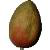

In [170]:


loadedImage1 = x_test[random_index,0,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage1)
random_index
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

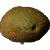

In [171]:
loadedImage2 = x_test[random_index,1,:,:,:]
index = np.random.randint(5000)
save_img('sampleData' + str(index) + '.jpg', loadedImage2)
# load the image to confirm it was saved correctly
Image.open('sampleData' + str(index) + '.jpg')

We can now send construct raw HTTP request and send to the service. Don't forget to add key to the HTTP header.

In [173]:
import requests

# send a random row from the test set to score
key1 = 'l8lLC4temcoIM93LKI108YovO0gbE6xV'

input_data = "{\"input_1\":[" + str(list(x_test[random_index, 0])) + "], \"input_2\":[" + str(list(x_test[random_index, 1])) + "]}"

test_samples1 = json.dumps({"input_1": x_test[random_index:random_index + 1, 0].tolist(), "input_2": x_test[random_index:random_index + 1, 1].tolist()})
test_samples1 = bytes(test_samples1, encoding='utf8')

headers = {'Content-Type':'application/json', 'Authorization': 'Bearer ' + key1}

resp = requests.post('http://fae6c4c6-e314-4964-8508-bdfddd72f799.eastus.azurecontainer.io/score', test_samples1, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("prediction:", resp.text)

POST to url http://fae6c4c6-e314-4964-8508-bdfddd72f799.eastus.azurecontainer.io/score
prediction: [true]


In [174]:
resp

<Response [200]>

Let's look at the workspace after the web service was deployed. You should see 
* a registered model named 'keras-mlp-mnist' and with the id 'model:1'
* an image called 'keras-mnist-svc' and with a docker image location pointing to your workspace's Azure Container Registry (ACR)  
* a webservice called 'keras-mnist-svc' with some scoring URL

In [ ]:
models = ws.models
for name, model in models.items():
    print("Model: {}, ID: {}".format(name, model.id))
    
images = ws.images
for name, image in images.items():
    print("Image: {}, location: {}".format(name, image.image_location))
    
webservices = ws.webservices
for name, webservice in webservices.items():
    print("Webservice: {}, scoring URI: {}".format(name, webservice.scoring_uri))

## Clean up
You can delete the ACI deployment with a simple delete API call.

In [105]:
service.delete()